# Advanced Lane finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Compute the camera calibration matrix and distortion coefficients from chessboard images 

In the next cells the following is done:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import Line
import os
import MyTools

%matplotlib qt
%matplotlib inline

In [2]:
def GetImageAndObjectPoints(imgPaths, doPlots=False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for fname in imgPaths:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            if doPlots == True:
                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
                cv2.imshow('img', img)
                cv2.waitKey(500)

    if doPlots == True:
        cv2.destroyAllWindows()

    return imgpoints, objpoints

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, x_, y_ = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist


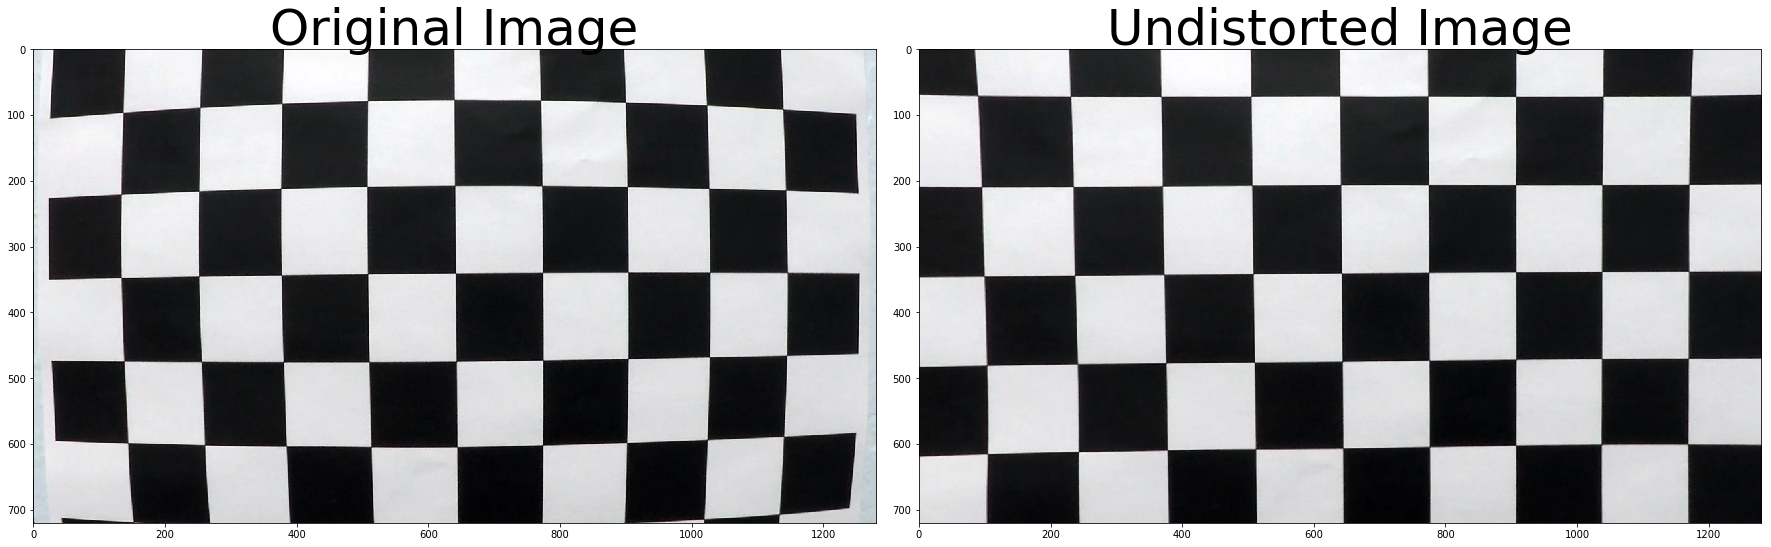

In [4]:
# ImgSavePath
imgSavePath = './output_images/'
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

imgpoints, objpoints = GetImageAndObjectPoints(images, doPlots=False)

# Use the objpoints and imgpoints found to Calibrate the camera and show result in an example image
img = cv2.imread(images[2])
img_undist, mtx, dist = cal_undistort(img, objpoints, imgpoints)

MyTools.MyImageWrite('undistorted_image.jpg', imgSavePath, img_undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Use color and gradient transforms to obtain a binary image
In the following, I use the following techniques to obtain a good binary image of the road:
* Color transform to HSV, using the S channel (best result)
* Then I run a canny transform to get a good binary image
* Merge the transformed images to a best candidate

In [5]:
# Load Test images and undistort
testImages = glob.glob('./test_images/test*.jpg')
testImage = testImages[3] #'./output_images/frame00.jpeg'  # testImages[0]
print('Image being used: ' + testImage)
img = cv2.imread(testImage)
img_undist = cv2.undistort(img, mtx, dist, None, mtx)
MyTools.MyImageWrite('undistorted_roadimage.jpg', imgSavePath, img_undist)

Image being used: ./test_images/test2.jpg


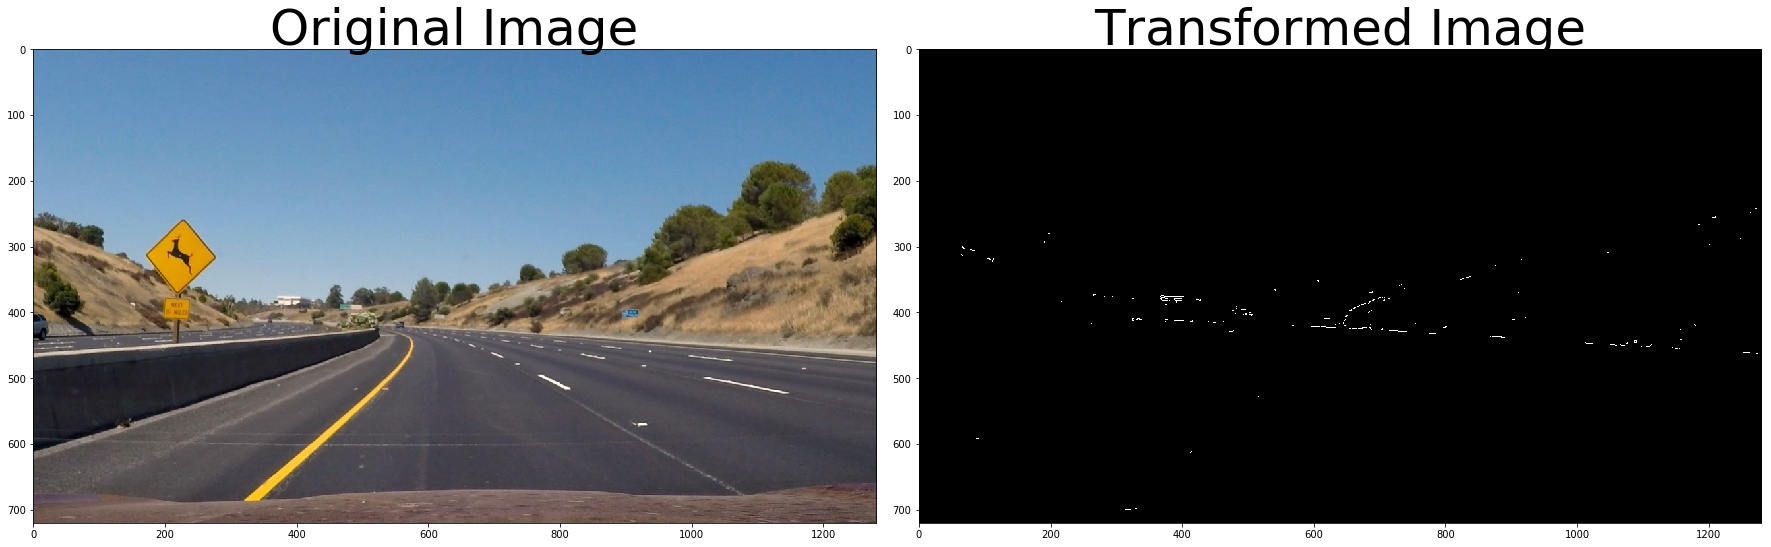

In [6]:
img_canny = MyTools.CannyDetect(img_undist)
# Plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_canny, 'gray')
ax2.set_title('Transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

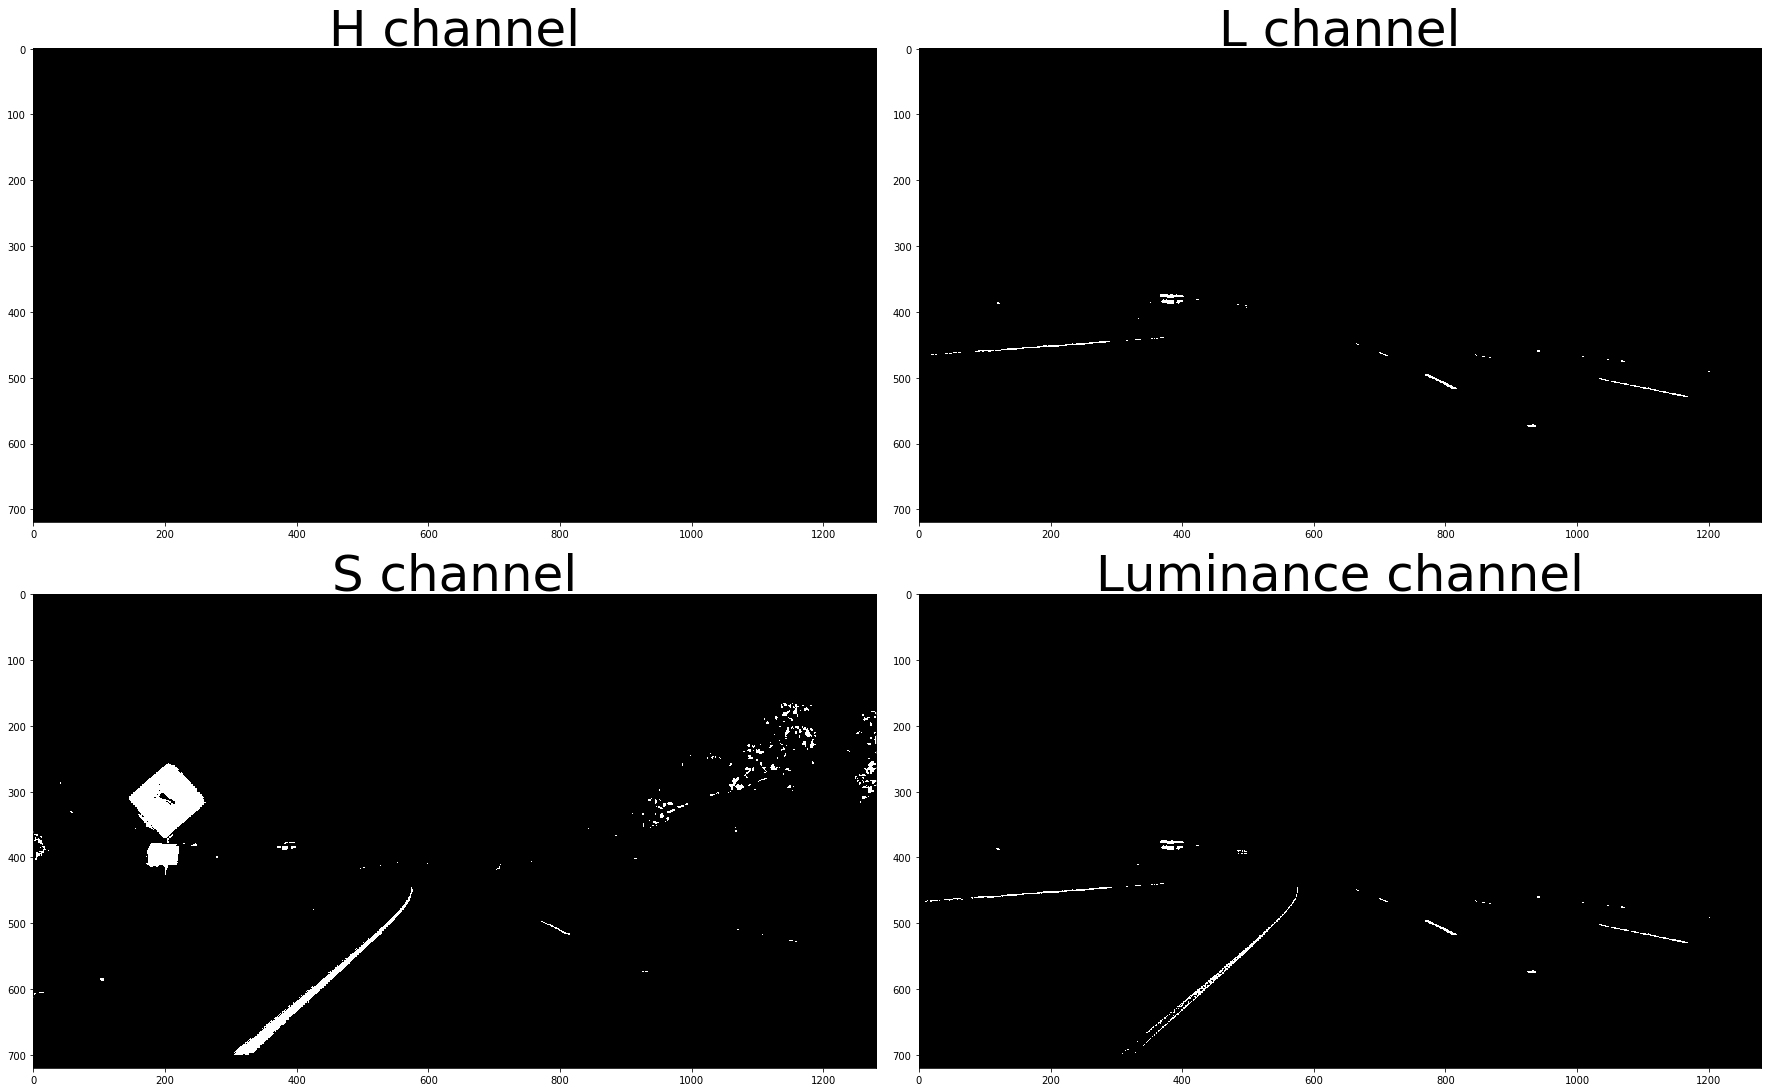

In [7]:
img_hls, h_channel, l_channel, s_channel, lum_channel = MyTools.ColorThreshold(img_undist)

# Plot results
f, (ax1, ax2) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
ax1[0].imshow(h_channel,'gray')
ax1[0].set_title('H channel', fontsize=50)
ax1[1].imshow(l_channel,'gray')
ax1[1].set_title('L channel', fontsize=50)
ax2[0].imshow(s_channel,'gray')
ax2[0].set_title('S channel', fontsize=50)
ax2[1].imshow(lum_channel,'gray')
ax2[1].set_title('Luminance channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1.6, bottom=0.)

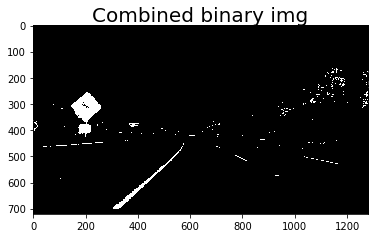

In [8]:
img_binary = MyTools.CombineBinaryImages(img_hls, img_canny)
MyTools.MyImageWrite('binary_combined.jpg', imgSavePath, img_binary)

plt.imshow(img_binary,'gray')
plt.title('Combined binary img', fontsize=20)

## Apply a perspective transform to rectify binary image ("birds-eye view")

* Using a straight road image, find the perspective transform lines (or rectangle points) that can be used to transform images with
* Apply perspective transform using the points find, and draw a rectangle on the image road, and transform the road image back



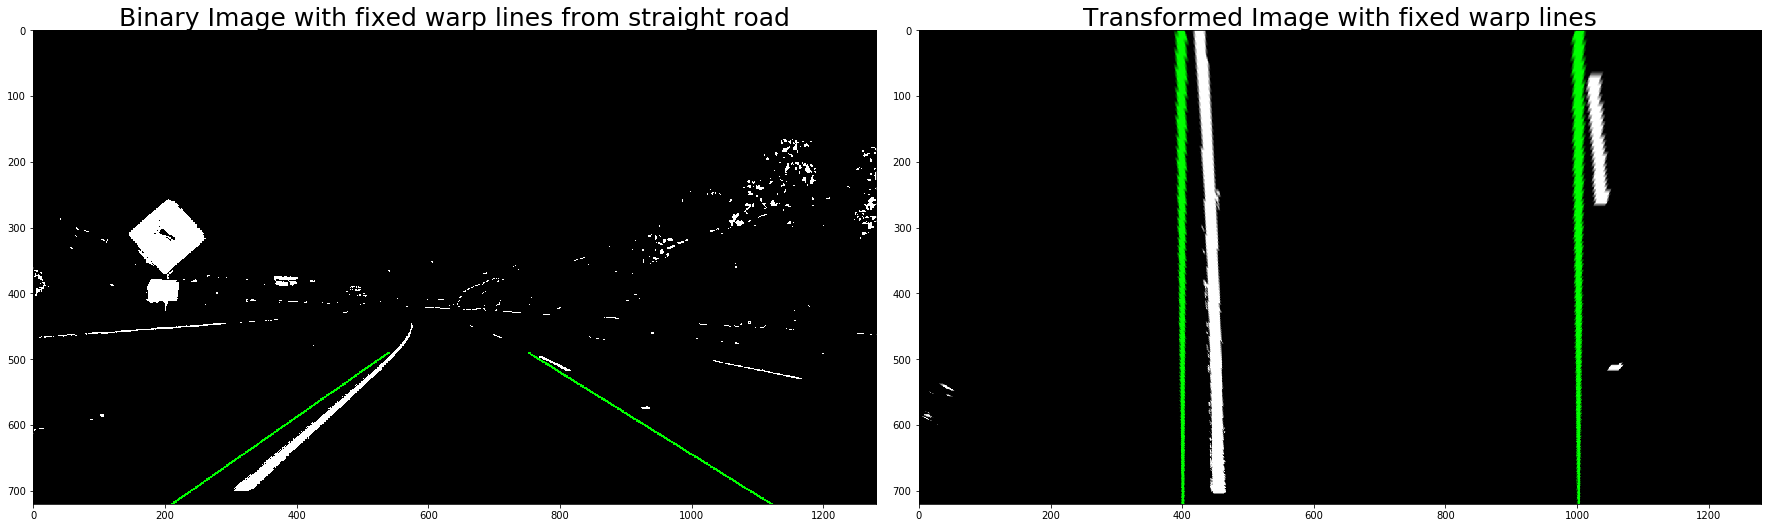

In [9]:
# Define some source points for perspective transform
dimY, dimX = img_binary.shape

#src = np.float32([(210, dimY),(590, 455),(695, 455),(1120, dimY)])
# destination points
dst = np.float32([(400, dimY),(400, 0),(1000, 0),(1000, dimY)])
src, dst = MyTools.CalculatePerspectiveTransform(img_binary.shape, 490)
    
# Create an image to draw the lines on
warp_lines = np.zeros_like(img_binary).astype(np.uint8)
warp_lines = np.dstack((warp_lines, warp_lines, warp_lines))
# Draw the lane onto the warped blank image
cv2.line(warp_lines, (src[0,0],src[0,1]), (src[1,0],src[1,1]),(0,255, 0),2)
cv2.line(warp_lines, (src[2,0],src[2,1]), (src[3,0],src[3,1]),(0,255, 0),2)

# Add Warp lines and binary image together as color image
img_binary_col = np.dstack((img_binary,img_binary,img_binary)) + warp_lines

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Warp the image using OpenCV warpPerspective()
img_warped_bin_col = cv2.warpPerspective(img_binary_col, M, (dimX, dimY))
img_warped_bin = cv2.warpPerspective(img_binary, M, (dimX, dimY))

# Save images
name = MyTools.GetFileNameFromFilePath(testImage)
MyTools.MyImageWrite(name + '_BinImgWLines.jpg', imgSavePath, img_binary_col)
MyTools.MyImageWrite(name + '_BinImgBirdsEye.jpg', imgSavePath, img_warped_bin_col)

# Plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_binary_col)
ax1.set_title('Binary Image with fixed warp lines from straight road', fontsize=25)
ax2.imshow(img_warped_bin_col)
ax2.set_title('Transformed Image with fixed warp lines', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

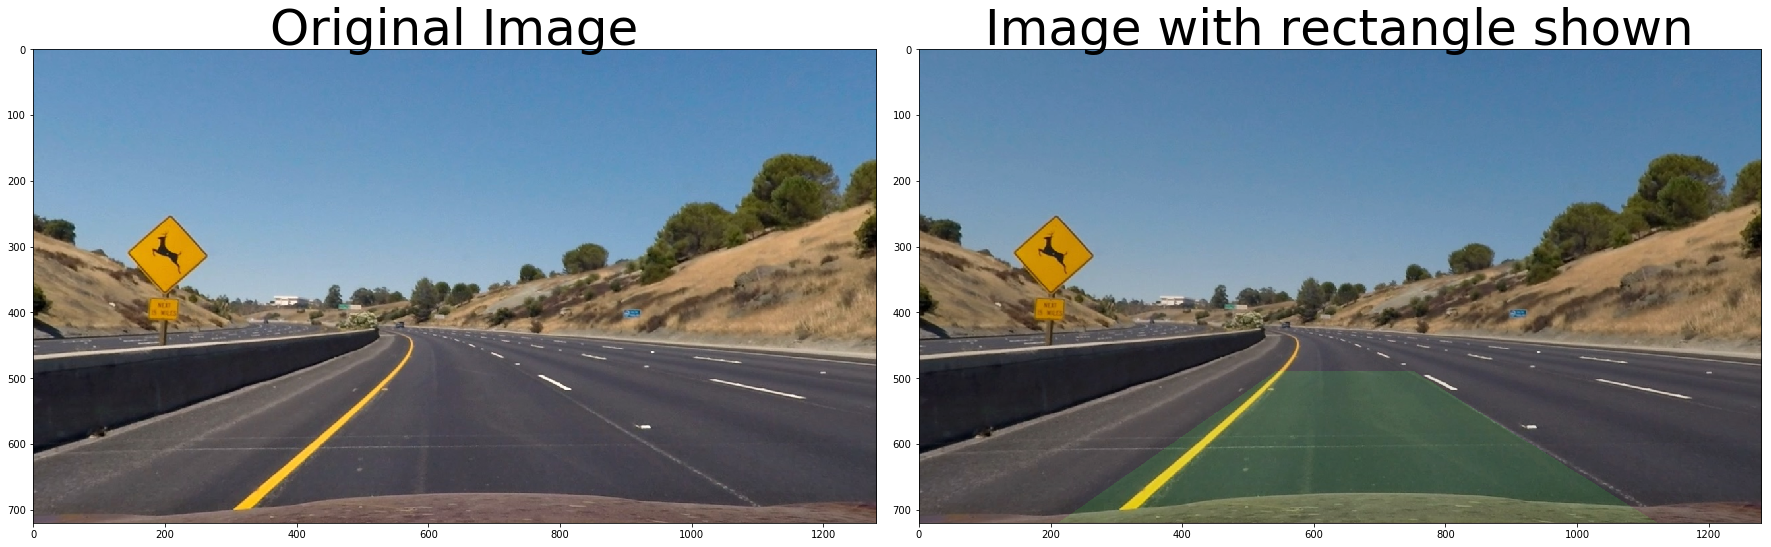

In [10]:
# Transform original image to birds eye, and apply a green rectangle and inverse transform image back to 
# drivers view

# Create rectangle image in birds eye view
img_rect = np.zeros_like(img_undist)
cv2.rectangle(img_rect, (dst[0,0],dst[0,1]), (dst[2,0],dst[2,1]), (0,255, 0),-1)
# Warp the rectangle using OpenCV warpPerspective() with inverse(M) 
img_rect_trans = cv2.warpPerspective(img_rect, np.linalg.inv(M), (dimX, dimY))

img_with_rect = cv2.addWeighted(img_undist, 0.9, img_rect_trans, 0.1, 0.0)

# Save images
name = MyTools.GetFileNameFromFilePath(testImage)
MyTools.MyImageWrite(name + '_ImageWRectangle.jpg', imgSavePath, img_with_rect)

# plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(img_with_rect, cv2.COLOR_BGR2RGB))
ax2.set_title('Image with rectangle shown', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Calculate line curvature from lane pixels
Using the Line() class with the binary and birds eye transformed image the following is done:
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.

left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 1434 
Pixels found in left window: 1 pixels: 1700 
Pixels found in left window: 2 pixels: 1692 
Pixels found in left window: 3 pixels: 1804 
Pixels found in left window: 4 pixels: 1790 
Pixels found in left window: 5 pixels: 1933 
Pixels found in left window: 6 pixels: 1743 
Pixels found in left window: 7 pixels: 1772 
Pixels found in left window: 8 pixels: 1799 
left lane detected: True
Pixels found in left poly pixels: 15667 
right lane, find line from scratch using windowing!!
Pixels found in right window: 5 pixels: 757 
Pixels found in right window: 6 pixels: 2011 
Pixels found in right window: 7 pixels: 2058 
right lane detected: True
Pixels found in right poly pixels: 4826 
Left and right line search x-val start 452.30246498521865 and 1022.396901004102


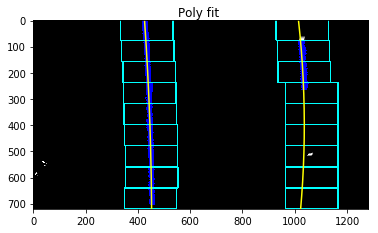

In [11]:
# get left and right lane Line objects:
LeftLane = Line.Line('left')
RightLane = Line.Line('right')

# Find lane pixels
LeftLane.find_lane_pixels(img_warped_bin)
RightLane.find_lane_pixels(img_warped_bin)
print('Left and right line search x-val start {} and {}'.format(LeftLane.bestx, RightLane.bestx))

img_plot = LeftLane.PlotPolynomialFit(img_warped_bin)
img_plot = RightLane.PlotPolynomialFit(img_plot)

MyTools.MyImageWrite('Window_Search.jpg', imgSavePath, img_plot)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

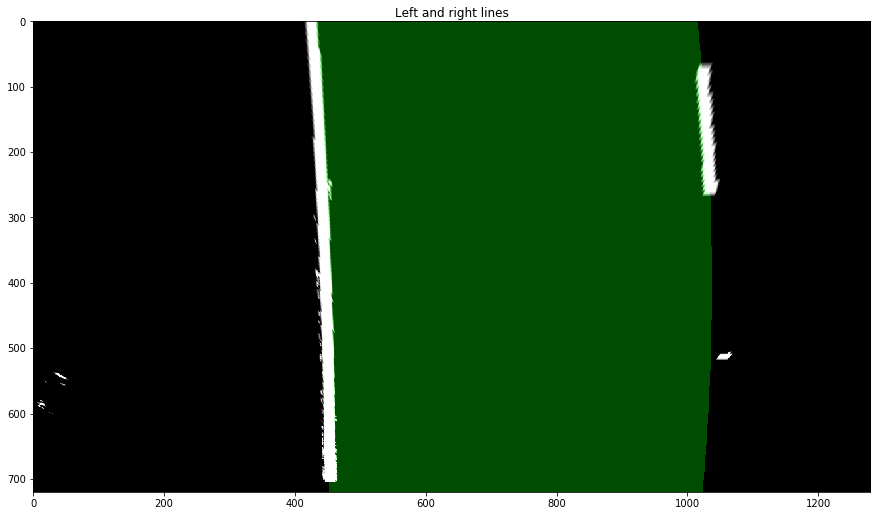

In [12]:
# Get image with green poly curve
img_polyfit = MyTools.BirdsEyeLaneFromLeftAndRightPolynomials(img_warped_bin, LeftLane.best_fit, RightLane.best_fit)

# Plot image ontop of binary warped image
MyTools.MergeAndPlotBGRImages(cv2.cvtColor(img_warped_bin, cv2.COLOR_GRAY2BGR), img_polyfit, 'Left and right lines');


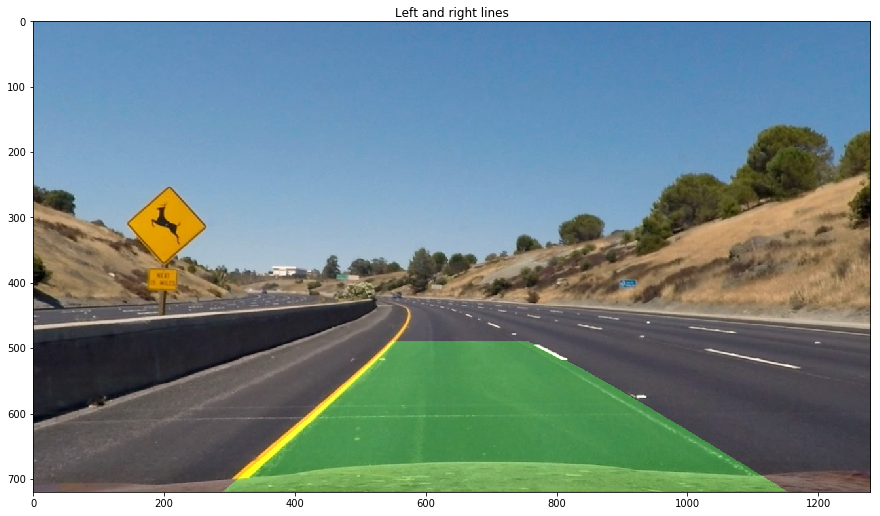

In [13]:
# Warp green poly curve image to drivers view
img_polyfit_warped = cv2.warpPerspective(img_polyfit, np.linalg.inv(M), (dimX, dimY))

# plot warped poly curve image ontop of road image
img_ex_out = MyTools.MergeAndPlotBGRImages(img_undist, img_polyfit_warped, 'Left and right lines')

MyTools.MyImageWrite('example_output.jpg', imgSavePath, img_ex_out)

## Create Pipeline for video

In [14]:

    
def LanePipeline(img):
    dimY, dimX = img.shape[:2]
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)    
    img_canny  = MyTools.CannyDetect(img_undist)
    img_col, h_channel, l_channel, s_channel, lum = MyTools.ColorThreshold(img_undist)
    img_binary = MyTools.CombineBinaryImages(img_canny, img_col)
    img_warped = cv2.warpPerspective(img_binary, M, (dimX, dimY))
    
    # Get an estimate on the left and right base x values
    LeftLane.find_lane_pixels(img_warped)
    RightLane.find_lane_pixels(img_warped)  
    # Compare lane curvatures
    LeftLane.CompareLaneCurvatures(RightLane)
    
    img_polyfit = MyTools.BirdsEyeLaneFromLeftAndRightPolynomials(img_warped, LeftLane.best_fit, RightLane.best_fit)
    img_polyfit_warped = cv2.warpPerspective(img_polyfit, np.linalg.inv(M), (dimX, dimY))

    LaneOffset = 'Offset:       {:.2f}m'.format(MyTools.CalculateLaneOffset(LeftLane,RightLane))
    LaneCurveL = 'Radius Left:  {:.0f}m'.format(LeftLane.best_radius)
    LaneCurveR = 'Radius Right: {:.0f}m'.format(RightLane.best_radius)
    BadLFrame = 'Bad frame L: {}'.format(LeftLane.NrOfBadFrames)
    BadRFrame = 'Bad frame R: {}'.format(RightLane.NrOfBadFrames)
    cv2.putText(img_undist, LaneOffset, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0),3)
    cv2.putText(img_undist, LaneCurveL, (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0),3)    
    cv2.putText(img_undist, LaneCurveR, (50,150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0),3)
    cv2.putText(img_undist, BadLFrame, (700,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0),3)
    cv2.putText(img_undist, BadRFrame, (700,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0),3)
    
    if debug == 0:
        img_out = cv2.addWeighted(img_undist, 1, img_polyfit_warped, 0.3, 0)   
    #MyTools.MergeAndPlotBGRImages(img_undist, img_polyfit_warped, 'Left and right lines')
    else:
        img_out = LeftLane.PlotPolynomialFit(img_warped,plot=0)
        img_out = RightLane.PlotPolynomialFit(img_out,plot=0)
        
    return img_out
    

left lane, find line from scratch using windowing!!
Pixels found in left window: 2 pixels: 728 
Pixels found in left window: 3 pixels: 898 
Pixels found in left window: 4 pixels: 1003 
Pixels found in left window: 5 pixels: 766 
Pixels found in left window: 6 pixels: 776 
Pixels found in left window: 7 pixels: 867 
left lane detected: True
Pixels found in left poly pixels: 5038 
right lane, find line from scratch using windowing!!
Pixels found in right window: 1 pixels: 1481 
Pixels found in right window: 2 pixels: 1128 
Pixels found in right window: 7 pixels: 2026 
right lane detected: True
Pixels found in right poly pixels: 4635 
Pixels found in left poly pixels: 5630 
Pixels found in right poly pixels: 5446 


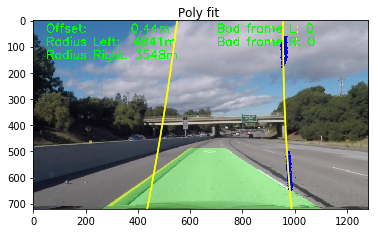

In [15]:
# get left and right lane Line objects:
LeftLane = Line.Line('left')
RightLane = Line.Line('right')
testImage = './output_images/frame002.jpeg'
img = cv2.imread(testImage)

debug = 0
for n in range(2):
    img_out = LanePipeline(img);
    #cv2.imshow('img',img_out)
    LeftLane.PlotPolynomialFit(img_out,plot=1)
    RightLane.PlotPolynomialFit(img_out,plot=1)
    cv2.waitKey(2000)
    #cv2.destroyAllWindows()

5630
5446


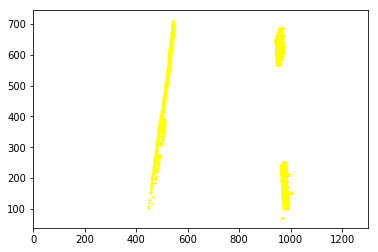

In [17]:
print(len(LeftLane.allx))
print(len(RightLane.allx))
plt.scatter(RightLane.allx, 750 - RightLane.ally,color='yellow',s=1)
plt.xlim([0,1300])
plt.hold
plt.scatter(LeftLane.allx, 750 - LeftLane.ally,color='yellow',s=0.1)

In [16]:
# Run Lane pipeline on videoclip
debug = 0
LeftLane = Line.Line('left')
RightLane = Line.Line('right')
MyTools.ProcessVideo('./challenge_video.mp4', './output_images/', LanePipeline)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 5 pixels: 771 
Pixels found in left window: 6 pixels: 888 
Pixels found in left window: 7 pixels: 582 
left lane detected: True
Pixels found in left poly pixels: 2241 
right lane, find line from scratch using windowing!!
Pixels found in right window: 1 pixels: 1209 
Pixels found in right window: 2 pixels: 1268 
right lane detected: False
Pixels found in right poly pixels: 2477 
right lineCurvature: 762, x-poly: 1019, x_diff: 9.8, badPos: False, Too few pixels: True, lane detected: False
Moviepy - Building video ./output_images/challenge_video.mp4.
Moviepy - Writing video ./output_images/challenge_video.mp4

Pixels found in left poly pixels: 3203 
right lane, find line from scratch using windowing!!
Pixels found in right window: 1 pixels: 1209 
Pixels found in right window: 2 pixels: 1268 
right lane detected: False
Pixels found in right poly pixels: 2477 
right lineCurvature: 762, x-poly: 1019, x_diff: 9.8

t:   1%|          | 5/485 [00:00<00:33, 14.27it/s, now=None]

Pixels found in left poly pixels: 3321 
right lane, find line from scratch using windowing!!
Pixels found in right window: 1 pixels: 1378 
Pixels found in right window: 2 pixels: 630 
right lane detected: False
Pixels found in right poly pixels: 2008 
right lineCurvature: 905, x-poly: 1015, x_diff: 9.9, badPos: False, Too few pixels: True, lane detected: False
Pixels found in left poly pixels: 2648 
right lane, find line from scratch using windowing!!
Pixels found in right window: 0 pixels: 1150 
Pixels found in right window: 1 pixels: 1353 
right lane detected: False
Pixels found in right poly pixels: 2503 
right lineCurvature: 100, x-poly: 994, x_diff: 10.6, badPos: False, Too few pixels: True, lane detected: False
Pixels found in left poly pixels: 2302 
right lane, find line from scratch using windowing!!
Pixels found in right window: 0 pixels: 1307 
Pixels found in right window: 1 pixels: 790 
right lane detected: False
Pixels found in right poly pixels: 2097 
right lineCurvature: 

t:   2%|▏         | 8/485 [00:00<00:37, 12.81it/s, now=None]

Pixels found in left poly pixels: 2243 
right lane, find line from scratch using windowing!!
Pixels found in right window: 0 pixels: 1240 
right lane detected: False
Pixels found in right poly pixels: 1240 
right lineCurvature: 34, x-poly: 995, x_diff: 10.7, badPos: False, Too few pixels: True, lane detected: False
Pixels found in left poly pixels: 2193 
right lane, find line from scratch using windowing!!
Pixels found in right window: 0 pixels: 693 
right lane detected: False
Pixels found in right poly pixels: 693 
right lineCurvature: 38, x-poly: 1007, x_diff: 0.8, badPos: False, Too few pixels: True, lane detected: False
Pixels found in left poly pixels: 2139 
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1005.0, badPos: True, Too few pixels: True, lane detected: False


t:   2%|▏         | 10/485 [00:00<00:37, 12.59it/s, now=None]

Pixels found in left poly pixels: 1764 
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 997.0, badPos: True, Too few pixels: True, lane detected: False
Pixels found in left poly pixels: 1844 
right lane, find line from scratch using windowing!!
Pixels found in right window: 8 pixels: 809 
right lane detected: False
Pixels found in right poly pixels: 809 
right lineCurvature: 1002, x-poly: 1032, x_diff: 48.7, badPos: False, Too few pixels: True, lane detected: False
Pixels found in left poly pixels: 1776 
right lane, find line from scratch using windowing!!
Pixels found in right window: 8 pixels: 1490 
right lane detected: False
Pixels found in right poly pixels: 1490 
right lineCurvature: 478, x-poly: 684, x_diff: 300.4, badPos: False, Too few pixels: True, lane detected: False


t:   2%|▏         | 12/485 [00:00<00:38, 12.40it/s, now=None]

Pixels found in left poly pixels: 1158 
left lineCurvature: 3194, x-poly: 453, x_diff: 4.0, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 8 pixels: 1857 
right lane detected: False
Pixels found in right poly pixels: 1857 
right lineCurvature: 128, x-poly: 290, x_diff: 695.1, badPos: True, Too few pixels: True, lane detected: False
Pixels found in left poly pixels: 1117 
left lineCurvature: 5221, x-poly: 449, x_diff: 7.9, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 8 pixels: 2010 
right lane detected: False
Pixels found in right poly pixels: 2010 
right lineCurvature: 337, x-poly: 649, x_diff: 339.9, badPos: False, Too few pixels: True, lane detected: False
Pixels found in left poly pixels: 1423 
right lane, find line from scratch using windowing!!
Pixels found in right window: 7 pixels: 777 
Pixels 

t:   3%|▎         | 16/485 [00:01<00:39, 11.85it/s, now=None]

Pixels found in left poly pixels: 2177 
right lane, find line from scratch using windowing!!
Pixels found in right window: 7 pixels: 1360 
Pixels found in right window: 8 pixels: 1925 
right lane detected: False
Pixels found in right poly pixels: 3285 
right lineCurvature: 1780, x-poly: 1008, x_diff: 15.7, badPos: False, Too few pixels: True, lane detected: False
Pixels found in left poly pixels: 2420 
right lane, find line from scratch using windowing!!
Pixels found in right window: 2 pixels: 574 
Pixels found in right window: 7 pixels: 1997 
Pixels found in right window: 8 pixels: 1296 
right lane detected: True
Pixels found in right poly pixels: 3867 
Pixels found in left poly pixels: 3768 
Pixels found in right poly pixels: 4147 


t:   4%|▍         | 20/485 [00:01<00:39, 11.66it/s, now=None]

Pixels found in left poly pixels: 3637 
Pixels found in right poly pixels: 4116 
Pixels found in left poly pixels: 3460 
Pixels found in right poly pixels: 4160 
Pixels found in left poly pixels: 3484 
Pixels found in right poly pixels: 3876 


t:   5%|▍         | 22/485 [00:01<00:40, 11.50it/s, now=None]

Pixels found in left poly pixels: 3111 
Pixels found in right poly pixels: 3778 
Pixels found in left poly pixels: 3239 
Pixels found in right poly pixels: 3466 
Pixels found in left poly pixels: 3116 
Pixels found in right poly pixels: 3168 


t:   5%|▌         | 26/485 [00:02<00:39, 11.70it/s, now=None]

Pixels found in left poly pixels: 3176 
Pixels found in right poly pixels: 3351 
Pixels found in left poly pixels: 2853 
Pixels found in right poly pixels: 3455 
Pixels found in left poly pixels: 3269 
Pixels found in right poly pixels: 3974 


t:   6%|▌         | 28/485 [00:02<00:38, 11.77it/s, now=None]

Pixels found in left poly pixels: 2911 
Pixels found in right poly pixels: 4882 
Pixels found in left poly pixels: 2893 
Pixels found in right poly pixels: 5358 
Pixels found in left poly pixels: 4258 
Pixels found in right poly pixels: 5731 


t:   7%|▋         | 32/485 [00:02<00:37, 12.06it/s, now=None]

Pixels found in left poly pixels: 3723 
Pixels found in right poly pixels: 5631 
Pixels found in left poly pixels: 3202 
Pixels found in right poly pixels: 5463 
Pixels found in left poly pixels: 1961 
Pixels found in right poly pixels: 5564 


t:   7%|▋         | 34/485 [00:02<00:38, 11.66it/s, now=None]

Pixels found in left poly pixels: 2105 
Pixels found in right poly pixels: 5285 
Pixels found in left poly pixels: 2064 
Pixels found in right poly pixels: 4657 
Pixels found in left poly pixels: 1670 
Pixels found in right poly pixels: 3944 


t:   8%|▊         | 38/485 [00:03<00:37, 11.98it/s, now=None]

Pixels found in left poly pixels: 2381 
Pixels found in right poly pixels: 3132 
Pixels found in left poly pixels: 1927 
Pixels found in right poly pixels: 2705 
Pixels found in left poly pixels: 1930 
Pixels found in right poly pixels: 3113 


t:   8%|▊         | 40/485 [00:03<00:38, 11.65it/s, now=None]

Pixels found in left poly pixels: 2155 
Pixels found in right poly pixels: 3683 
Pixels found in left poly pixels: 1598 
Pixels found in right poly pixels: 4376 
Pixels found in left poly pixels: 1047 
left lineCurvature: 961, x-poly: 393, x_diff: 44.9, badPos: False, Too few pixels: True, lane detected: True


t:   9%|▊         | 42/485 [00:03<00:40, 10.95it/s, now=None]

Pixels found in right poly pixels: 4957 
Pixels found in left poly pixels: 1031 
left lineCurvature: 2973, x-poly: 424, x_diff: 14.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5146 
Pixels found in left poly pixels: 1189 
left lineCurvature: 389, x-poly: 555, x_diff: 116.9, badPos: False, Too few pixels: True, lane detected: True


t:   9%|▉         | 44/485 [00:03<00:41, 10.59it/s, now=None]

Pixels found in right poly pixels: 5511 
Pixels found in left poly pixels: 885 
left lineCurvature: 1529, x-poly: 451, x_diff: 13.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5571 


t:   9%|▉         | 46/485 [00:03<00:43, 10.17it/s, now=None]

Pixels found in left poly pixels: 912 
left lineCurvature: 369, x-poly: 543, x_diff: 105.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5297 
Pixels found in left poly pixels: 1410 
Pixels found in right poly pixels: 5333 
Pixels found in left poly pixels: 1326 
left lineCurvature: 514, x-poly: 478, x_diff: 41.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5375 


t:  10%|▉         | 48/485 [00:04<00:42, 10.38it/s, now=None]

Pixels found in left poly pixels: 1581 
Pixels found in right poly pixels: 4975 
Pixels found in left poly pixels: 3112 
Pixels found in right poly pixels: 4209 


t:  10%|█         | 50/485 [00:04<00:42, 10.17it/s, now=None]

Pixels found in left poly pixels: 2700 
Pixels found in right poly pixels: 3418 
Pixels found in left poly pixels: 2107 
Pixels found in right poly pixels: 2851 
Pixels found in left poly pixels: 1747 


t:  11%|█         | 52/485 [00:04<00:42, 10.19it/s, now=None]

Pixels found in right poly pixels: 3055 
Pixels found in left poly pixels: 1594 
Pixels found in right poly pixels: 3621 
Pixels found in left poly pixels: 1343 
left lineCurvature: 1688, x-poly: 424, x_diff: 15.9, badPos: False, Too few pixels: True, lane detected: True


t:  11%|█         | 54/485 [00:04<00:42, 10.11it/s, now=None]

Pixels found in right poly pixels: 4149 
Pixels found in left poly pixels: 2150 
Pixels found in right poly pixels: 4351 


t:  12%|█▏        | 57/485 [00:05<00:43,  9.76it/s, now=None]

Pixels found in left poly pixels: 1568 
Pixels found in right poly pixels: 4776 
Pixels found in left poly pixels: 1359 
left lineCurvature: 1555, x-poly: 433, x_diff: 4.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5091 


t:  12%|█▏        | 59/485 [00:05<00:43,  9.84it/s, now=None]

Pixels found in left poly pixels: 1301 
left lineCurvature: 2941, x-poly: 422, x_diff: 16.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5145 
Pixels found in left poly pixels: 1007 
left lineCurvature: 3070, x-poly: 418, x_diff: 19.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5041 


t:  13%|█▎        | 61/485 [00:05<00:45,  9.34it/s, now=None]

Pixels found in left poly pixels: 767 
left lineCurvature: 1602, x-poly: 423, x_diff: 14.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5030 
Pixels found in left poly pixels: 504 
left lineCurvature: 2167, x-poly: 421, x_diff: 17.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4880 


t:  13%|█▎        | 63/485 [00:05<00:45,  9.23it/s, now=None]

Pixels found in left poly pixels: 4144 
Pixels found in right poly pixels: 4503 
Pixels found in left poly pixels: 3372 
Pixels found in right poly pixels: 3959 
Pixels found in left poly pixels: 3122 


t:  13%|█▎        | 65/485 [00:05<00:42,  9.81it/s, now=None]

Pixels found in right poly pixels: 3207 
Pixels found in left poly pixels: 2868 
Pixels found in right poly pixels: 2626 
Pixels found in left poly pixels: 3043 
Pixels found in right poly pixels: 3011 


t:  14%|█▍        | 67/485 [00:06<00:40, 10.28it/s, now=None]

Pixels found in left poly pixels: 2897 
Pixels found in right poly pixels: 3397 
Pixels found in left poly pixels: 2610 
Pixels found in right poly pixels: 4003 
Pixels found in left poly pixels: 1787 


t:  15%|█▍        | 71/485 [00:06<00:39, 10.46it/s, now=None]

Pixels found in right poly pixels: 4328 
Pixels found in left poly pixels: 1125 
left lineCurvature: 865, x-poly: 447, x_diff: 10.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4823 
Pixels found in left poly pixels: 764 
left lineCurvature: 1314, x-poly: 435, x_diff: 1.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5173 


t:  15%|█▌        | 73/485 [00:06<00:38, 10.57it/s, now=None]

Pixels found in left poly pixels: 478 
left lineCurvature: 741, x-poly: 451, x_diff: 15.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5147 
Pixels found in left poly pixels: 386 
left lineCurvature: 5026, x-poly: 446, x_diff: 10.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5426 


t:  15%|█▌        | 75/485 [00:06<00:39, 10.40it/s, now=None]

Pixels found in left poly pixels: 397 
left lineCurvature: 402, x-poly: 464, x_diff: 27.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5177 
Pixels found in left poly pixels: 492 
left lineCurvature: 181, x-poly: 591, x_diff: 155.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5714 
Pixels found in left poly pixels: 328 
left lineCurvature: 217, x-poly: 526, x_diff: 89.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4856 


t:  16%|█▌        | 77/485 [00:07<00:38, 10.56it/s, now=None]

Pixels found in left poly pixels: 437 
left lineCurvature: 1643, x-poly: 452, x_diff: 16.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4332 
Pixels found in left poly pixels: 479 
left lineCurvature: 1028, x-poly: 453, x_diff: 17.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3573 
Pixels found in left poly pixels: 318 
left lineCurvature: 199, x-poly: 351, x_diff: 85.0, badPos: False, Too few pixels: True, lane detected: True


t:  17%|█▋        | 81/485 [00:07<00:38, 10.52it/s, now=None]

Pixels found in right poly pixels: 2982 
Pixels found in left poly pixels: 177 
left lineCurvature: 227, x-poly: 372, x_diff: 63.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3000 
Pixels found in left poly pixels: 683 
left lineCurvature: 6188, x-poly: 427, x_diff: 8.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2980 


t:  17%|█▋        | 83/485 [00:07<00:38, 10.45it/s, now=None]

Pixels found in left poly pixels: 1071 
left lineCurvature: 464, x-poly: 409, x_diff: 26.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3463 
Pixels found in left poly pixels: 779 
left lineCurvature: 395, x-poly: 410, x_diff: 26.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3555 
Pixels found in left poly pixels: 1000 
left lineCurvature: 94, x-poly: 303, x_diff: 133.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4079 


t:  18%|█▊        | 85/485 [00:07<00:37, 10.64it/s, now=None]

Pixels found in left poly pixels: 1416 
Pixels found in right poly pixels: 4713 
Pixels found in left poly pixels: 950 
left lineCurvature: 834, x-poly: 457, x_diff: 20.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5440 


t:  18%|█▊        | 87/485 [00:07<00:39, 10.07it/s, now=None]

Pixels found in left poly pixels: 900 
left lineCurvature: 683, x-poly: 455, x_diff: 18.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5902 
Pixels found in left poly pixels: 718 
left lineCurvature: 5369, x-poly: 438, x_diff: 1.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5645 


t:  19%|█▊        | 90/485 [00:08<00:40,  9.71it/s, now=None]

Pixels found in left poly pixels: 510 
left lineCurvature: 1722, x-poly: 459, x_diff: 22.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5345 
Pixels found in left poly pixels: 861 
left lineCurvature: 619, x-poly: 468, x_diff: 31.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4576 
Pixels found in left poly pixels: 955 
left lineCurvature: 405, x-poly: 475, x_diff: 38.8, badPos: False, Too few pixels: True, lane detected: True


t:  19%|█▉        | 92/485 [00:08<00:38, 10.10it/s, now=None]

Pixels found in right poly pixels: 4091 
Pixels found in left poly pixels: 6688 
Pixels found in right poly pixels: 3218 
Pixels found in left poly pixels: 3025 
Pixels found in right poly pixels: 2996 


t:  19%|█▉        | 94/485 [00:08<00:38, 10.24it/s, now=None]

Pixels found in left poly pixels: 2522 
Pixels found in right poly pixels: 2929 
Pixels found in left poly pixels: 3687 
Pixels found in right poly pixels: 2901 


t:  20%|█▉        | 96/485 [00:08<00:38,  9.99it/s, now=None]

Pixels found in left poly pixels: 4559 
Pixels found in right poly pixels: 3162 
Pixels found in left poly pixels: 4092 
Pixels found in right poly pixels: 3848 


t:  20%|██        | 98/485 [00:09<00:40,  9.66it/s, now=None]

Pixels found in left poly pixels: 2940 
Pixels found in right poly pixels: 4783 
Pixels found in left poly pixels: 2276 
Pixels found in right poly pixels: 5148 
Pixels found in left poly pixels: 2144 


t:  21%|██        | 102/485 [00:09<00:38, 10.07it/s, now=None]

Pixels found in right poly pixels: 5034 
Pixels found in left poly pixels: 1782 
Pixels found in right poly pixels: 5167 
Pixels found in left poly pixels: 3525 
Pixels found in right poly pixels: 5295 


t:  21%|██▏       | 104/485 [00:09<00:36, 10.56it/s, now=None]

Pixels found in left poly pixels: 3613 
Pixels found in right poly pixels: 5302 
Pixels found in left poly pixels: 6128 
Pixels found in right poly pixels: 5092 
Pixels found in left poly pixels: 6900 
Pixels found in right poly pixels: 4500 


t:  22%|██▏       | 106/485 [00:09<00:37, 10.22it/s, now=None]

Pixels found in left poly pixels: 7863 
Pixels found in right poly pixels: 3693 
Pixels found in left poly pixels: 6743 
Pixels found in right poly pixels: 3329 


t:  22%|██▏       | 108/485 [00:10<00:37, 10.05it/s, now=None]

Pixels found in left poly pixels: 6703 
Pixels found in right poly pixels: 3408 
Pixels found in left poly pixels: 6643 
Pixels found in right poly pixels: 3271 


t:  23%|██▎       | 110/485 [00:10<00:38,  9.65it/s, now=None]

Pixels found in left poly pixels: 6287 
Pixels found in right poly pixels: 3126 
Pixels found in left poly pixels: 6980 
Pixels found in right poly pixels: 3747 
Pixels found in left poly pixels: 9571 


t:  24%|██▎       | 114/485 [00:10<00:36, 10.23it/s, now=None]

Pixels found in right poly pixels: 4540 
Pixels found in left poly pixels: 9853 
Pixels found in right poly pixels: 5415 
Pixels found in left poly pixels: 9084 
Pixels found in right poly pixels: 5749 


t:  24%|██▍       | 116/485 [00:10<00:37,  9.97it/s, now=None]

Pixels found in left poly pixels: 8409 
Pixels found in right poly pixels: 5997 
Pixels found in left poly pixels: 8012 
Pixels found in right poly pixels: 6147 


t:  24%|██▍       | 118/485 [00:11<00:37,  9.89it/s, now=None]

Pixels found in left poly pixels: 7857 
Pixels found in right poly pixels: 6229 
Pixels found in left poly pixels: 7013 
Pixels found in right poly pixels: 5203 
Pixels found in left poly pixels: 6268 


t:  25%|██▍       | 119/485 [00:11<00:37,  9.85it/s, now=None]

Pixels found in right poly pixels: 4865 
Pixels found in left poly pixels: 5472 
Pixels found in right poly pixels: 3658 
Pixels found in left poly pixels: 4602 
Pixels found in right poly pixels: 3271 


t:  25%|██▌       | 123/485 [00:11<00:37,  9.55it/s, now=None]

Pixels found in left poly pixels: 4217 
Pixels found in right poly pixels: 3326 
Pixels found in left poly pixels: 3931 
Pixels found in right poly pixels: 3184 
Pixels found in left poly pixels: 3320 
Pixels found in right poly pixels: 3161 


t:  26%|██▌       | 125/485 [00:11<00:36,  9.95it/s, now=None]

Pixels found in left poly pixels: 3001 
Pixels found in right poly pixels: 3240 
Pixels found in left poly pixels: 2890 
Pixels found in right poly pixels: 3215 
Pixels found in left poly pixels: 2522 


t:  26%|██▋       | 128/485 [00:12<00:36,  9.77it/s, now=None]

Pixels found in right poly pixels: 3037 
Pixels found in left poly pixels: 2271 
Pixels found in right poly pixels: 3113 
Pixels found in left poly pixels: 2067 


t:  27%|██▋       | 130/485 [00:12<00:35,  9.93it/s, now=None]

Pixels found in right poly pixels: 3156 
Pixels found in left poly pixels: 1499 
Pixels found in right poly pixels: 3203 
Pixels found in left poly pixels: 927 
left lineCurvature: 273, x-poly: 454, x_diff: 2.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2740 


t:  27%|██▋       | 132/485 [00:12<00:37,  9.43it/s, now=None]

Pixels found in left poly pixels: 392 
left lineCurvature: 183, x-poly: 453, x_diff: 2.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1882 
right lineCurvature: 113, x-poly: 952, x_diff: 1.1, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 175 
left lineCurvature: 1796, x-poly: 373, x_diff: 77.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1015 
right lineCurvature: 690, x-poly: 958, x_diff: 5.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 179 
left lineCurvature: 51349, x-poly: 348, x_diff: 102.8, badPos: False, Too few pixels: True, lane detected: True


t:  28%|██▊       | 135/485 [00:12<00:36,  9.50it/s, now=None]

Pixels found in right poly pixels: 177 
right lineCurvature: 39, x-poly: 956, x_diff: 2.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 329 
left lineCurvature: 2277, x-poly: 507, x_diff: 56.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 953.0, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 393 


t:  28%|██▊       | 137/485 [00:13<00:36,  9.50it/s, now=None]

left lineCurvature: 596, x-poly: 421, x_diff: 29.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 953.0, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 57 
left lineCurvature: 1080316, x-poly: 459, x_diff: 8.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 953.0, badPos: True, Too few pixels: True, lane detected: True


t:  28%|██▊       | 138/485 [00:13<00:37,  9.30it/s, now=None]

Pixels found in left poly pixels: 1295 
left lineCurvature: 1923, x-poly: 441, x_diff: 9.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 953.0, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 1313 
left lineCurvature: 827, x-poly: 440, x_diff: 10.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 116 
right lineCurvature: 47810534435479, x-poly: 752, x_diff: 200.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 1234 
left lineCurvature: 1060, x-poly: 438, x_diff: 12.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 698 
right lineCurvature: 115, x-poly: 3781, x_diff: 2828.0, badPos: False, Too few pixels: True, lane detected: True


t:  29%|██▉       | 142/485 [00:13<00:33, 10.22it/s, now=None]

Pixels found in left poly pixels: 182 
left lineCurvature: 812, x-poly: 422, x_diff: 29.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1536 
Pixels found in left poly pixels: 15 
left lineCurvature: 6266, x-poly: 492, x_diff: 41.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2200 
right lineCurvature: 280, x-poly: 1370, x_diff: 418.8, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 451.0, badPos: False, Too few pixels: True, lane detected: True


t:  30%|██▉       | 144/485 [00:13<00:34,  9.86it/s, now=None]

Pixels found in right poly pixels: 2486 
right lineCurvature: 213, x-poly: 1529, x_diff: 577.7, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 839 
left lineCurvature: 126, x-poly: -202, x_diff: 653.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2476 
right lineCurvature: 210, x-poly: 1470, x_diff: 518.0, badPos: False, Too few pixels: False, lane detected: True


t:  30%|██▉       | 145/485 [00:13<00:34,  9.78it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 451.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2625 
right lineCurvature: 267, x-poly: 1282, x_diff: 330.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 451.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3102 
right lineCurvature: 289, x-poly: 668, x_diff: 283.8, badPos: False, Too few pixels: False, lane detected: True


t:  31%|███       | 148/485 [00:14<00:35,  9.52it/s, now=None]

Pixels found in left poly pixels: 816 
left lineCurvature: 116, x-poly: 2928, x_diff: 2476.7, badPos: True, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3845 
right lineCurvature: 146, x-poly: 485, x_diff: 466.7, badPos: True, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 1428 
left lineCurvature: 126, x-poly: 3771, x_diff: 3320.4, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 6064 
right lineCurvature: 1239, x-poly: 850, x_diff: 101.5, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 3364 


t:  31%|███       | 150/485 [00:14<00:33,  9.91it/s, now=None]

Pixels found in right poly pixels: 8854 
right lineCurvature: 932, x-poly: 835, x_diff: 117.1, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 6396 
left lineCurvature: 994, x-poly: 549, x_diff: 95.5, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 8727 
right lineCurvature: 289, x-poly: 748, x_diff: 203.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 7085 
left lineCurvature: 850, x-poly: 545, x_diff: 91.9, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 6569 
right lineCurvature: 422, x-poly: 824, x_diff: 128.1, badPos: False, Too few pixels: False, lane detected: True


t:  31%|███▏      | 152/485 [00:14<00:33,  9.95it/s, now=None]

Pixels found in left poly pixels: 9552 
Pixels found in right poly pixels: 4792 
Pixels found in left poly pixels: 9376 
Pixels found in right poly pixels: 5172 
Pixels found in left poly pixels: 9643 
Pixels found in right poly pixels: 6288 


t:  32%|███▏      | 156/485 [00:14<00:33,  9.82it/s, now=None]

Pixels found in left poly pixels: 8997 
Pixels found in right poly pixels: 6697 
Pixels found in left poly pixels: 8356 
Pixels found in right poly pixels: 6737 


t:  33%|███▎      | 158/485 [00:15<00:34,  9.49it/s, now=None]

Pixels found in left poly pixels: 8919 
Pixels found in right poly pixels: 7554 
Pixels found in left poly pixels: 10034 
Pixels found in right poly pixels: 7425 


t:  33%|███▎      | 160/485 [00:15<00:34,  9.46it/s, now=None]

Pixels found in left poly pixels: 10133 
Pixels found in right poly pixels: 6714 
Pixels found in left poly pixels: 10876 
Pixels found in right poly pixels: 5717 
Pixels found in left poly pixels: 11138 


t:  33%|███▎      | 162/485 [00:15<00:33,  9.68it/s, now=None]

Pixels found in right poly pixels: 4650 
Pixels found in left poly pixels: 10237 
Pixels found in right poly pixels: 3898 
Pixels found in left poly pixels: 9735 
Pixels found in right poly pixels: 3684 


t:  34%|███▍      | 164/485 [00:15<00:31, 10.05it/s, now=None]

Pixels found in left poly pixels: 10998 
Pixels found in right poly pixels: 3513 
Pixels found in left poly pixels: 12633 
Pixels found in right poly pixels: 3541 
Pixels found in left poly pixels: 12916 


t:  34%|███▍      | 166/485 [00:15<00:31, 10.08it/s, now=None]

Pixels found in right poly pixels: 3883 
Pixels found in left poly pixels: 12516 
Pixels found in right poly pixels: 4782 


t:  35%|███▍      | 169/485 [00:16<00:32,  9.62it/s, now=None]

Pixels found in left poly pixels: 12850 
Pixels found in right poly pixels: 5216 
Pixels found in left poly pixels: 11247 
Pixels found in right poly pixels: 5939 


t:  35%|███▌      | 171/485 [00:16<00:32,  9.55it/s, now=None]

Pixels found in left poly pixels: 12108 
Pixels found in right poly pixels: 6270 
Pixels found in left poly pixels: 11978 
Pixels found in right poly pixels: 6195 


t:  36%|███▌      | 173/485 [00:16<00:34,  9.16it/s, now=None]

Pixels found in left poly pixels: 11317 
Pixels found in right poly pixels: 5864 
Pixels found in left poly pixels: 10818 
Pixels found in right poly pixels: 5168 


t:  36%|███▌      | 175/485 [00:16<00:32,  9.42it/s, now=None]

Pixels found in left poly pixels: 10453 
Pixels found in right poly pixels: 4213 
Pixels found in left poly pixels: 9780 
Pixels found in right poly pixels: 3468 


t:  36%|███▋      | 176/485 [00:17<00:32,  9.56it/s, now=None]

Pixels found in left poly pixels: 8936 
Pixels found in right poly pixels: 3107 
Pixels found in left poly pixels: 8579 
Pixels found in right poly pixels: 3150 
Pixels found in left poly pixels: 8328 


t:  37%|███▋      | 179/485 [00:17<00:31,  9.63it/s, now=None]

Pixels found in right poly pixels: 3256 
Pixels found in left poly pixels: 12007 
Pixels found in right poly pixels: 3454 


t:  37%|███▋      | 181/485 [00:17<00:34,  8.82it/s, now=None]

Pixels found in left poly pixels: 11925 
Pixels found in right poly pixels: 3773 
Pixels found in left poly pixels: 10547 
Pixels found in right poly pixels: 4930 


t:  38%|███▊      | 183/485 [00:17<00:33,  8.99it/s, now=None]

Pixels found in left poly pixels: 13677 
Pixels found in right poly pixels: 5465 
Pixels found in left poly pixels: 12919 
Pixels found in right poly pixels: 6266 


t:  38%|███▊      | 185/485 [00:18<00:33,  9.03it/s, now=None]

Pixels found in left poly pixels: 12724 
Pixels found in right poly pixels: 6146 
Pixels found in left poly pixels: 12436 
Pixels found in right poly pixels: 6783 


t:  39%|███▊      | 187/485 [00:18<00:33,  8.92it/s, now=None]

Pixels found in left poly pixels: 11570 
Pixels found in right poly pixels: 5956 
Pixels found in left poly pixels: 10344 
Pixels found in right poly pixels: 5079 


t:  39%|███▉      | 189/485 [00:18<00:31,  9.39it/s, now=None]

Pixels found in left poly pixels: 9907 
Pixels found in right poly pixels: 4237 
Pixels found in left poly pixels: 7772 
Pixels found in right poly pixels: 3302 


t:  39%|███▉      | 190/485 [00:18<00:31,  9.41it/s, now=None]

Pixels found in left poly pixels: 8107 
Pixels found in right poly pixels: 3049 
Pixels found in left poly pixels: 7846 
Pixels found in right poly pixels: 3039 
Pixels found in left poly pixels: 8254 
Pixels found in right poly pixels: 3149 


t:  40%|████      | 194/485 [00:18<00:28, 10.17it/s, now=None]

Pixels found in left poly pixels: 8385 
Pixels found in right poly pixels: 3746 
Pixels found in left poly pixels: 10188 
Pixels found in right poly pixels: 4450 
Pixels found in left poly pixels: 9668 
Pixels found in right poly pixels: 5350 


t:  41%|████      | 198/485 [00:19<00:27, 10.48it/s, now=None]

Pixels found in left poly pixels: 9660 
Pixels found in right poly pixels: 5682 
Pixels found in left poly pixels: 8522 
Pixels found in right poly pixels: 5682 
Pixels found in left poly pixels: 9057 
Pixels found in right poly pixels: 5588 


t:  41%|████      | 200/485 [00:19<00:28, 10.17it/s, now=None]

Pixels found in left poly pixels: 8162 
Pixels found in right poly pixels: 5836 
Pixels found in left poly pixels: 7724 
Pixels found in right poly pixels: 5293 


t:  42%|████▏     | 202/485 [00:19<00:28,  9.98it/s, now=None]

Pixels found in left poly pixels: 7605 
Pixels found in right poly pixels: 4607 
Pixels found in left poly pixels: 7470 
Pixels found in right poly pixels: 3712 
Pixels found in left poly pixels: 6492 


t:  42%|████▏     | 204/485 [00:19<00:27, 10.28it/s, now=None]

Pixels found in right poly pixels: 3021 
Pixels found in left poly pixels: 7237 
Pixels found in right poly pixels: 2925 
Pixels found in left poly pixels: 6605 
Pixels found in right poly pixels: 3011 


t:  42%|████▏     | 206/485 [00:20<00:26, 10.39it/s, now=None]

Pixels found in left poly pixels: 7245 
Pixels found in right poly pixels: 3854 
Pixels found in left poly pixels: 7075 
Pixels found in right poly pixels: 4292 


t:  43%|████▎     | 208/485 [00:20<00:28,  9.87it/s, now=None]

Pixels found in left poly pixels: 6525 
Pixels found in right poly pixels: 4544 
Pixels found in left poly pixels: 7001 
Pixels found in right poly pixels: 5001 
Pixels found in left poly pixels: 8433 
Pixels found in right poly pixels: 5548 


t:  44%|████▎     | 212/485 [00:20<00:27,  9.78it/s, now=None]

Pixels found in left poly pixels: 7859 
Pixels found in right poly pixels: 5453 
Pixels found in left poly pixels: 8629 
Pixels found in right poly pixels: 5505 


t:  44%|████▍     | 214/485 [00:20<00:29,  9.31it/s, now=None]

Pixels found in left poly pixels: 5525 
Pixels found in right poly pixels: 5076 
Pixels found in left poly pixels: 7243 
Pixels found in right poly pixels: 4660 


t:  45%|████▍     | 216/485 [00:21<00:27,  9.63it/s, now=None]

Pixels found in left poly pixels: 7874 
Pixels found in right poly pixels: 3988 
Pixels found in left poly pixels: 7737 
Pixels found in right poly pixels: 3255 
Pixels found in left poly pixels: 7204 


t:  45%|████▍     | 218/485 [00:21<00:27,  9.79it/s, now=None]

Pixels found in right poly pixels: 2941 
Pixels found in left poly pixels: 7391 
Pixels found in right poly pixels: 2830 


t:  45%|████▌     | 220/485 [00:21<00:29,  8.92it/s, now=None]

Pixels found in left poly pixels: 7429 
Pixels found in right poly pixels: 3183 
Pixels found in left poly pixels: 7190 
Pixels found in right poly pixels: 3760 


t:  46%|████▌     | 222/485 [00:21<00:28,  9.39it/s, now=None]

Pixels found in left poly pixels: 7122 
Pixels found in right poly pixels: 4186 
Pixels found in left poly pixels: 7397 
Pixels found in right poly pixels: 4764 


t:  46%|████▌     | 224/485 [00:21<00:27,  9.59it/s, now=None]

Pixels found in left poly pixels: 7182 
Pixels found in right poly pixels: 5221 
Pixels found in left poly pixels: 7686 
Pixels found in right poly pixels: 5593 


t:  47%|████▋     | 226/485 [00:22<00:27,  9.57it/s, now=None]

Pixels found in left poly pixels: 6349 
Pixels found in right poly pixels: 5663 
Pixels found in left poly pixels: 6809 
Pixels found in right poly pixels: 5845 


t:  47%|████▋     | 228/485 [00:22<00:26,  9.77it/s, now=None]

Pixels found in left poly pixels: 6864 
Pixels found in right poly pixels: 5377 
Pixels found in left poly pixels: 6247 
Pixels found in right poly pixels: 4595 


t:  47%|████▋     | 230/485 [00:22<00:27,  9.22it/s, now=None]

Pixels found in left poly pixels: 5588 
Pixels found in right poly pixels: 3747 
Pixels found in left poly pixels: 4397 
Pixels found in right poly pixels: 2911 
Pixels found in left poly pixels: 3822 


t:  48%|████▊     | 232/485 [00:22<00:26,  9.68it/s, now=None]

Pixels found in right poly pixels: 3077 
Pixels found in left poly pixels: 3673 
Pixels found in right poly pixels: 3198 
Pixels found in left poly pixels: 4398 


t:  48%|████▊     | 234/485 [00:22<00:26,  9.62it/s, now=None]

Pixels found in right poly pixels: 3547 
Pixels found in left poly pixels: 4279 
Pixels found in right poly pixels: 4144 
Pixels found in left poly pixels: 4306 
Pixels found in right poly pixels: 4605 


t:  49%|████▉     | 238/485 [00:23<00:23, 10.35it/s, now=None]

Pixels found in left poly pixels: 5035 
Pixels found in right poly pixels: 4976 
Pixels found in left poly pixels: 5021 
Pixels found in right poly pixels: 5223 
Pixels found in left poly pixels: 5084 
Pixels found in right poly pixels: 4807 


t:  49%|████▉     | 240/485 [00:23<00:24, 10.00it/s, now=None]

Pixels found in left poly pixels: 4755 
Pixels found in right poly pixels: 4938 
Pixels found in left poly pixels: 4469 
Pixels found in right poly pixels: 4745 


t:  50%|████▉     | 242/485 [00:23<00:23, 10.24it/s, now=None]

Pixels found in left poly pixels: 3878 
Pixels found in right poly pixels: 4455 
Pixels found in left poly pixels: 5605 
Pixels found in right poly pixels: 4099 
Pixels found in left poly pixels: 5570 


t:  50%|█████     | 244/485 [00:23<00:24,  9.89it/s, now=None]

Pixels found in right poly pixels: 3544 
Pixels found in left poly pixels: 4293 
Pixels found in right poly pixels: 2813 


t:  51%|█████     | 245/485 [00:24<00:25,  9.59it/s, now=None]

Pixels found in left poly pixels: 4734 
Pixels found in right poly pixels: 2741 
Pixels found in left poly pixels: 4543 
Pixels found in right poly pixels: 2965 
Pixels found in left poly pixels: 5350 
Pixels found in right poly pixels: 3267 


t:  51%|█████▏    | 249/485 [00:24<00:24,  9.77it/s, now=None]

Pixels found in left poly pixels: 5345 
Pixels found in right poly pixels: 3931 
Pixels found in left poly pixels: 5458 
Pixels found in right poly pixels: 4505 


t:  52%|█████▏    | 251/485 [00:24<00:23,  9.90it/s, now=None]

Pixels found in left poly pixels: 5725 
Pixels found in right poly pixels: 5071 
Pixels found in left poly pixels: 5549 
Pixels found in right poly pixels: 5474 
Pixels found in left poly pixels: 5253 
Pixels found in right poly pixels: 5352 


t:  52%|█████▏    | 253/485 [00:24<00:23,  9.97it/s, now=None]

Pixels found in left poly pixels: 4860 
Pixels found in right poly pixels: 5808 
Pixels found in left poly pixels: 5971 
Pixels found in right poly pixels: 5844 
Pixels found in left poly pixels: 5544 


t:  53%|█████▎    | 257/485 [00:25<00:22, 10.20it/s, now=None]

Pixels found in right poly pixels: 5292 
Pixels found in left poly pixels: 5744 
Pixels found in right poly pixels: 4557 
Pixels found in left poly pixels: 5265 
Pixels found in right poly pixels: 3794 


t:  53%|█████▎    | 259/485 [00:25<00:22, 10.16it/s, now=None]

Pixels found in left poly pixels: 5560 
Pixels found in right poly pixels: 3274 
Pixels found in left poly pixels: 5198 
Pixels found in right poly pixels: 3133 


t:  54%|█████▍    | 261/485 [00:25<00:22, 10.10it/s, now=None]

Pixels found in left poly pixels: 4657 
Pixels found in right poly pixels: 3119 
Pixels found in left poly pixels: 4656 
Pixels found in right poly pixels: 3265 
Pixels found in left poly pixels: 4836 
Pixels found in right poly pixels: 4106 


t:  54%|█████▍    | 263/485 [00:25<00:21, 10.24it/s, now=None]

Pixels found in left poly pixels: 4645 
Pixels found in right poly pixels: 4688 
Pixels found in left poly pixels: 5037 
Pixels found in right poly pixels: 5301 
Pixels found in left poly pixels: 6139 


t:  55%|█████▍    | 265/485 [00:26<00:21, 10.23it/s, now=None]

Pixels found in right poly pixels: 5454 
Pixels found in left poly pixels: 6415 
Pixels found in right poly pixels: 5308 
Pixels found in left poly pixels: 5981 


t:  55%|█████▌    | 267/485 [00:26<00:21, 10.07it/s, now=None]

Pixels found in right poly pixels: 5454 
Pixels found in left poly pixels: 5913 
Pixels found in right poly pixels: 5842 


t:  56%|█████▌    | 271/485 [00:26<00:20, 10.34it/s, now=None]

Pixels found in left poly pixels: 6006 
Pixels found in right poly pixels: 5098 
Pixels found in left poly pixels: 6297 
Pixels found in right poly pixels: 4445 
Pixels found in left poly pixels: 6069 
Pixels found in right poly pixels: 3805 


t:  56%|█████▋    | 273/485 [00:26<00:20, 10.29it/s, now=None]

Pixels found in left poly pixels: 5711 
Pixels found in right poly pixels: 3107 
Pixels found in left poly pixels: 5003 
Pixels found in right poly pixels: 2969 
Pixels found in left poly pixels: 4052 
Pixels found in right poly pixels: 3374 


t:  57%|█████▋    | 275/485 [00:27<00:20, 10.34it/s, now=None]

Pixels found in left poly pixels: 3523 
Pixels found in right poly pixels: 4000 
Pixels found in left poly pixels: 4818 
Pixels found in right poly pixels: 4724 
Pixels found in left poly pixels: 4869 


t:  57%|█████▋    | 277/485 [00:27<00:20, 10.21it/s, now=None]

Pixels found in right poly pixels: 5235 
Pixels found in left poly pixels: 4784 
Pixels found in right poly pixels: 5130 


t:  58%|█████▊    | 279/485 [00:27<00:20,  9.95it/s, now=None]

Pixels found in left poly pixels: 5334 
Pixels found in right poly pixels: 4913 
Pixels found in left poly pixels: 5587 
Pixels found in right poly pixels: 4817 
Pixels found in left poly pixels: 5615 


t:  58%|█████▊    | 281/485 [00:27<00:20, 10.00it/s, now=None]

Pixels found in right poly pixels: 4820 
Pixels found in left poly pixels: 5652 
Pixels found in right poly pixels: 4870 


t:  59%|█████▉    | 285/485 [00:28<00:19, 10.28it/s, now=None]

Pixels found in left poly pixels: 5241 
Pixels found in right poly pixels: 4268 
Pixels found in left poly pixels: 5027 
Pixels found in right poly pixels: 3666 
Pixels found in left poly pixels: 4578 
Pixels found in right poly pixels: 3093 


t:  59%|█████▉    | 287/485 [00:28<00:18, 10.43it/s, now=None]

Pixels found in left poly pixels: 4314 
Pixels found in right poly pixels: 2801 
Pixels found in left poly pixels: 5427 
Pixels found in right poly pixels: 2815 
Pixels found in left poly pixels: 7526 
Pixels found in right poly pixels: 3012 


t:  60%|█████▉    | 289/485 [00:28<00:19, 10.29it/s, now=None]

Pixels found in left poly pixels: 7342 
Pixels found in right poly pixels: 3729 
Pixels found in left poly pixels: 7621 
Pixels found in right poly pixels: 4476 
Pixels found in left poly pixels: 6774 


t:  60%|██████    | 291/485 [00:28<00:18, 10.25it/s, now=None]

Pixels found in right poly pixels: 5027 
Pixels found in left poly pixels: 7258 
Pixels found in right poly pixels: 5561 
Pixels found in left poly pixels: 5918 
Pixels found in right poly pixels: 5270 


t:  61%|██████    | 295/485 [00:28<00:18, 10.23it/s, now=None]

Pixels found in left poly pixels: 5077 
Pixels found in right poly pixels: 5661 
Pixels found in left poly pixels: 6398 
Pixels found in right poly pixels: 5550 


t:  61%|██████    | 297/485 [00:29<00:18,  9.92it/s, now=None]

Pixels found in left poly pixels: 6052 
Pixels found in right poly pixels: 5470 
Pixels found in left poly pixels: 5308 
Pixels found in right poly pixels: 4855 
Pixels found in left poly pixels: 5165 
Pixels found in right poly pixels: 4150 


t:  62%|██████▏   | 299/485 [00:29<00:18, 10.13it/s, now=None]

Pixels found in left poly pixels: 4572 
Pixels found in right poly pixels: 3251 
Pixels found in left poly pixels: 3864 
Pixels found in right poly pixels: 3117 
Pixels found in left poly pixels: 4612 
Pixels found in right poly pixels: 3118 


t:  62%|██████▏   | 303/485 [00:29<00:17, 10.43it/s, now=None]

Pixels found in left poly pixels: 5440 
Pixels found in right poly pixels: 3112 
Pixels found in left poly pixels: 5372 
Pixels found in right poly pixels: 3348 


t:  63%|██████▎   | 305/485 [00:29<00:17, 10.43it/s, now=None]

Pixels found in left poly pixels: 5750 
Pixels found in right poly pixels: 3816 
Pixels found in left poly pixels: 4584 
Pixels found in right poly pixels: 4671 
Pixels found in left poly pixels: 4212 
Pixels found in right poly pixels: 5265 


t:  63%|██████▎   | 307/485 [00:30<00:17, 10.09it/s, now=None]

Pixels found in left poly pixels: 4650 
Pixels found in right poly pixels: 5359 
Pixels found in left poly pixels: 4965 
Pixels found in right poly pixels: 5615 
Pixels found in left poly pixels: 4823 
Pixels found in right poly pixels: 5439 


t:  64%|██████▍   | 311/485 [00:30<00:17, 10.11it/s, now=None]

Pixels found in left poly pixels: 5354 
Pixels found in right poly pixels: 5256 
Pixels found in left poly pixels: 4235 
Pixels found in right poly pixels: 4675 
Pixels found in left poly pixels: 4147 


t:  65%|██████▍   | 313/485 [00:30<00:16, 10.26it/s, now=None]

Pixels found in right poly pixels: 3887 
Pixels found in left poly pixels: 3922 
Pixels found in right poly pixels: 3145 
Pixels found in left poly pixels: 5224 
Pixels found in right poly pixels: 3072 


t:  65%|██████▍   | 315/485 [00:30<00:16, 10.33it/s, now=None]

Pixels found in left poly pixels: 4836 
Pixels found in right poly pixels: 3116 
Pixels found in left poly pixels: 4315 
Pixels found in right poly pixels: 3095 
Pixels found in left poly pixels: 6111 
Pixels found in right poly pixels: 3483 


t:  66%|██████▌   | 319/485 [00:31<00:15, 10.55it/s, now=None]

Pixels found in left poly pixels: 5566 
Pixels found in right poly pixels: 4003 
Pixels found in left poly pixels: 4986 
Pixels found in right poly pixels: 4931 
Pixels found in left poly pixels: 4959 
Pixels found in right poly pixels: 5515 


t:  66%|██████▌   | 321/485 [00:31<00:15, 10.79it/s, now=None]

Pixels found in left poly pixels: 4164 
Pixels found in right poly pixels: 6003 
Pixels found in left poly pixels: 4558 
Pixels found in right poly pixels: 5954 
Pixels found in left poly pixels: 4007 


t:  67%|██████▋   | 323/485 [00:31<00:15, 10.63it/s, now=None]

Pixels found in right poly pixels: 5808 
Pixels found in left poly pixels: 3411 
Pixels found in right poly pixels: 5462 


t:  67%|██████▋   | 325/485 [00:31<00:15, 10.24it/s, now=None]

Pixels found in left poly pixels: 3400 
Pixels found in right poly pixels: 4821 
Pixels found in left poly pixels: 4429 
Pixels found in right poly pixels: 3765 
Pixels found in left poly pixels: 4761 


t:  67%|██████▋   | 327/485 [00:32<00:15, 10.27it/s, now=None]

Pixels found in right poly pixels: 2887 
Pixels found in left poly pixels: 4624 
Pixels found in right poly pixels: 2909 


t:  68%|██████▊   | 331/485 [00:32<00:15, 10.26it/s, now=None]

Pixels found in left poly pixels: 4429 
Pixels found in right poly pixels: 3098 
Pixels found in left poly pixels: 4438 
Pixels found in right poly pixels: 3647 
Pixels found in left poly pixels: 4226 
Pixels found in right poly pixels: 4491 


t:  69%|██████▊   | 333/485 [00:32<00:14, 10.22it/s, now=None]

Pixels found in left poly pixels: 5061 
Pixels found in right poly pixels: 5180 
Pixels found in left poly pixels: 5292 
Pixels found in right poly pixels: 5341 


t:  69%|██████▉   | 335/485 [00:32<00:14, 10.30it/s, now=None]

Pixels found in left poly pixels: 3702 
Pixels found in right poly pixels: 5527 
Pixels found in left poly pixels: 3640 
Pixels found in right poly pixels: 5681 
Pixels found in left poly pixels: 2239 


t:  69%|██████▉   | 337/485 [00:33<00:14, 10.05it/s, now=None]

Pixels found in right poly pixels: 5584 
Pixels found in left poly pixels: 2910 
Pixels found in right poly pixels: 5570 
Pixels found in left poly pixels: 2857 


t:  70%|██████▉   | 339/485 [00:33<00:14, 10.32it/s, now=None]

Pixels found in right poly pixels: 5362 
Pixels found in left poly pixels: 2409 
Pixels found in right poly pixels: 4487 
Pixels found in left poly pixels: 2944 
Pixels found in right poly pixels: 3724 


t:  70%|███████   | 341/485 [00:33<00:13, 10.67it/s, now=None]

Pixels found in left poly pixels: 3159 
Pixels found in right poly pixels: 2922 
Pixels found in left poly pixels: 3245 
Pixels found in right poly pixels: 3068 


t:  71%|███████   | 343/485 [00:33<00:13, 10.31it/s, now=None]

Pixels found in left poly pixels: 3994 
Pixels found in right poly pixels: 3342 
Pixels found in left poly pixels: 3997 
Pixels found in right poly pixels: 4258 
Pixels found in left poly pixels: 4522 


t:  72%|███████▏  | 347/485 [00:34<00:13, 10.57it/s, now=None]

Pixels found in right poly pixels: 4623 
Pixels found in left poly pixels: 5436 
Pixels found in right poly pixels: 4498 
Pixels found in left poly pixels: 5272 
Pixels found in right poly pixels: 5499 


t:  72%|███████▏  | 349/485 [00:34<00:12, 10.79it/s, now=None]

Pixels found in left poly pixels: 5112 
Pixels found in right poly pixels: 5541 
Pixels found in left poly pixels: 3948 
Pixels found in right poly pixels: 5336 
Pixels found in left poly pixels: 4760 
Pixels found in right poly pixels: 5496 


t:  72%|███████▏  | 351/485 [00:34<00:12, 11.07it/s, now=None]

Pixels found in left poly pixels: 4797 
Pixels found in right poly pixels: 5268 
Pixels found in left poly pixels: 5108 
Pixels found in right poly pixels: 4673 


t:  73%|███████▎  | 355/485 [00:34<00:11, 11.02it/s, now=None]

Pixels found in left poly pixels: 4231 
Pixels found in right poly pixels: 3966 
Pixels found in left poly pixels: 6220 
Pixels found in right poly pixels: 3199 
Pixels found in left poly pixels: 6998 
Pixels found in right poly pixels: 2893 


t:  74%|███████▎  | 357/485 [00:34<00:11, 10.98it/s, now=None]

Pixels found in left poly pixels: 6881 
Pixels found in right poly pixels: 3192 
Pixels found in left poly pixels: 6746 
Pixels found in right poly pixels: 3844 
Pixels found in left poly pixels: 5434 


t:  74%|███████▍  | 359/485 [00:35<00:11, 10.63it/s, now=None]

Pixels found in right poly pixels: 4357 
Pixels found in left poly pixels: 6260 
Pixels found in right poly pixels: 4988 
Pixels found in left poly pixels: 5745 
Pixels found in right poly pixels: 5656 


t:  75%|███████▍  | 363/485 [00:35<00:11, 10.88it/s, now=None]

Pixels found in left poly pixels: 4904 
Pixels found in right poly pixels: 5698 
Pixels found in left poly pixels: 5250 
Pixels found in right poly pixels: 5743 
Pixels found in left poly pixels: 4535 
Pixels found in right poly pixels: 5623 


t:  75%|███████▌  | 365/485 [00:35<00:11, 10.75it/s, now=None]

Pixels found in left poly pixels: 4116 
Pixels found in right poly pixels: 5814 
Pixels found in left poly pixels: 4440 
Pixels found in right poly pixels: 5922 
Pixels found in left poly pixels: 4306 
Pixels found in right poly pixels: 4993 


t:  76%|███████▌  | 367/485 [00:35<00:11, 10.70it/s, now=None]

Pixels found in left poly pixels: 3458 
Pixels found in right poly pixels: 3899 
Pixels found in left poly pixels: 2953 
Pixels found in right poly pixels: 3463 


t:  76%|███████▌  | 369/485 [00:36<00:11, 10.39it/s, now=None]

Pixels found in left poly pixels: 3419 
Pixels found in right poly pixels: 3501 
Pixels found in left poly pixels: 3902 
Pixels found in right poly pixels: 3862 


t:  76%|███████▋  | 371/485 [00:36<00:11, 10.24it/s, now=None]

Pixels found in left poly pixels: 3935 
Pixels found in right poly pixels: 3764 
Pixels found in left poly pixels: 3205 
Pixels found in right poly pixels: 4175 
Pixels found in left poly pixels: 3600 


t:  77%|███████▋  | 375/485 [00:36<00:10, 10.63it/s, now=None]

Pixels found in right poly pixels: 4767 
Pixels found in left poly pixels: 3315 
Pixels found in right poly pixels: 5144 
Pixels found in left poly pixels: 3141 
Pixels found in right poly pixels: 5673 


t:  78%|███████▊  | 377/485 [00:36<00:10, 10.75it/s, now=None]

Pixels found in left poly pixels: 4590 
Pixels found in right poly pixels: 6045 
Pixels found in left poly pixels: 3393 
Pixels found in right poly pixels: 5736 
Pixels found in left poly pixels: 3380 
Pixels found in right poly pixels: 5786 


t:  79%|███████▊  | 381/485 [00:37<00:09, 10.92it/s, now=None]

Pixels found in left poly pixels: 2860 
Pixels found in right poly pixels: 5677 
Pixels found in left poly pixels: 3873 
Pixels found in right poly pixels: 5012 
Pixels found in left poly pixels: 3836 
Pixels found in right poly pixels: 4222 


t:  79%|███████▉  | 383/485 [00:37<00:09, 11.33it/s, now=None]

Pixels found in left poly pixels: 4942 
Pixels found in right poly pixels: 3443 
Pixels found in left poly pixels: 5030 
Pixels found in right poly pixels: 3167 
Pixels found in left poly pixels: 4823 
Pixels found in right poly pixels: 3076 


t:  79%|███████▉  | 385/485 [00:37<00:08, 11.12it/s, now=None]

Pixels found in left poly pixels: 5078 
Pixels found in right poly pixels: 3079 
Pixels found in left poly pixels: 4561 
Pixels found in right poly pixels: 3441 


t:  80%|███████▉  | 387/485 [00:37<00:09, 10.68it/s, now=None]

Pixels found in left poly pixels: 3730 
Pixels found in right poly pixels: 4306 
Pixels found in left poly pixels: 3828 
Pixels found in right poly pixels: 5037 
Pixels found in left poly pixels: 2892 
Pixels found in right poly pixels: 5484 


t:  81%|████████  | 391/485 [00:38<00:08, 11.09it/s, now=None]

Pixels found in left poly pixels: 3735 
Pixels found in right poly pixels: 5866 
Pixels found in left poly pixels: 4813 
Pixels found in right poly pixels: 5928 
Pixels found in left poly pixels: 4531 
Pixels found in right poly pixels: 6337 


t:  81%|████████  | 393/485 [00:38<00:08, 10.71it/s, now=None]

Pixels found in left poly pixels: 4425 
Pixels found in right poly pixels: 5736 
Pixels found in left poly pixels: 4612 
Pixels found in right poly pixels: 4981 


t:  81%|████████▏ | 395/485 [00:38<00:08, 10.39it/s, now=None]

Pixels found in left poly pixels: 4608 
Pixels found in right poly pixels: 4283 
Pixels found in left poly pixels: 4478 
Pixels found in right poly pixels: 3476 


t:  82%|████████▏ | 397/485 [00:38<00:08, 10.09it/s, now=None]

Pixels found in left poly pixels: 2653 
Pixels found in right poly pixels: 3178 
Pixels found in left poly pixels: 2802 
Pixels found in right poly pixels: 3000 


t:  82%|████████▏ | 399/485 [00:38<00:08, 10.00it/s, now=None]

Pixels found in left poly pixels: 3286 
Pixels found in right poly pixels: 3258 
Pixels found in left poly pixels: 3195 
Pixels found in right poly pixels: 4176 
Pixels found in left poly pixels: 5221 


t:  83%|████████▎ | 401/485 [00:39<00:08,  9.97it/s, now=None]

Pixels found in right poly pixels: 4707 
Pixels found in left poly pixels: 4501 
Pixels found in right poly pixels: 5090 
Pixels found in left poly pixels: 3177 
Pixels found in right poly pixels: 5309 


t:  84%|████████▎ | 405/485 [00:39<00:07, 10.25it/s, now=None]

Pixels found in left poly pixels: 4247 
Pixels found in right poly pixels: 5555 
Pixels found in left poly pixels: 5509 
Pixels found in right poly pixels: 5482 


t:  84%|████████▍ | 407/485 [00:39<00:07, 10.59it/s, now=None]

Pixels found in left poly pixels: 5535 
Pixels found in right poly pixels: 5203 
Pixels found in left poly pixels: 4546 
Pixels found in right poly pixels: 4642 
Pixels found in left poly pixels: 3678 
Pixels found in right poly pixels: 4112 


t:  84%|████████▍ | 409/485 [00:39<00:07, 10.69it/s, now=None]

Pixels found in left poly pixels: 3385 
Pixels found in right poly pixels: 3328 
Pixels found in left poly pixels: 3172 
Pixels found in right poly pixels: 2608 


t:  85%|████████▍ | 411/485 [00:40<00:07, 10.07it/s, now=None]

Pixels found in left poly pixels: 3277 
Pixels found in right poly pixels: 2715 
Pixels found in left poly pixels: 3214 
Pixels found in right poly pixels: 2734 
Pixels found in left poly pixels: 3149 


t:  85%|████████▌ | 413/485 [00:40<00:07, 10.16it/s, now=None]

Pixels found in right poly pixels: 3313 
Pixels found in left poly pixels: 3077 
Pixels found in right poly pixels: 3870 


t:  86%|████████▌ | 415/485 [00:40<00:07,  9.74it/s, now=None]

Pixels found in left poly pixels: 2907 
Pixels found in right poly pixels: 4817 
Pixels found in left poly pixels: 3279 
Pixels found in right poly pixels: 4988 
Pixels found in left poly pixels: 3620 


t:  86%|████████▌ | 417/485 [00:40<00:06,  9.89it/s, now=None]

Pixels found in right poly pixels: 5119 
Pixels found in left poly pixels: 3130 
Pixels found in right poly pixels: 5030 
Pixels found in left poly pixels: 3928 
Pixels found in right poly pixels: 5058 


t:  87%|████████▋ | 421/485 [00:41<00:06, 10.35it/s, now=None]

Pixels found in left poly pixels: 3534 
Pixels found in right poly pixels: 5003 
Pixels found in left poly pixels: 3448 
Pixels found in right poly pixels: 4942 
Pixels found in left poly pixels: 4603 
Pixels found in right poly pixels: 4340 


t:  88%|████████▊ | 425/485 [00:41<00:05, 10.63it/s, now=None]

Pixels found in left poly pixels: 4328 
Pixels found in right poly pixels: 3731 
Pixels found in left poly pixels: 3614 
Pixels found in right poly pixels: 3222 
Pixels found in left poly pixels: 2902 
Pixels found in right poly pixels: 3060 


t:  88%|████████▊ | 427/485 [00:41<00:05, 10.47it/s, now=None]

Pixels found in left poly pixels: 2566 
Pixels found in right poly pixels: 3351 
Pixels found in left poly pixels: 2325 
Pixels found in right poly pixels: 3871 


t:  88%|████████▊ | 429/485 [00:41<00:05, 10.12it/s, now=None]

Pixels found in left poly pixels: 1754 
Pixels found in right poly pixels: 4968 
Pixels found in left poly pixels: 1333 
left lineCurvature: 17820, x-poly: 435, x_diff: 8.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5408 


t:  89%|████████▉ | 431/485 [00:42<00:05, 10.27it/s, now=None]

Pixels found in left poly pixels: 1033 
left lineCurvature: 461530, x-poly: 439, x_diff: 12.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5743 
Pixels found in left poly pixels: 934 
left lineCurvature: 123393, x-poly: 438, x_diff: 11.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5817 
Pixels found in left poly pixels: 1028 
left lineCurvature: 4468, x-poly: 424, x_diff: 2.1, badPos: False, Too few pixels: True, lane detected: True


t:  89%|████████▉ | 433/485 [00:42<00:05, 10.06it/s, now=None]

Pixels found in right poly pixels: 5948 
Pixels found in left poly pixels: 1368 
left lineCurvature: 3007, x-poly: 417, x_diff: 9.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5999 
Pixels found in left poly pixels: 1421 


t:  90%|████████▉ | 435/485 [00:42<00:05,  9.67it/s, now=None]

Pixels found in right poly pixels: 6600 
Pixels found in left poly pixels: 1882 
Pixels found in right poly pixels: 6173 


t:  90%|█████████ | 437/485 [00:42<00:05,  9.48it/s, now=None]

Pixels found in left poly pixels: 1799 
Pixels found in right poly pixels: 5333 
Pixels found in left poly pixels: 2163 
Pixels found in right poly pixels: 4400 


t:  91%|█████████ | 439/485 [00:42<00:04,  9.77it/s, now=None]

Pixels found in left poly pixels: 1871 
Pixels found in right poly pixels: 3515 
Pixels found in left poly pixels: 1716 
Pixels found in right poly pixels: 3299 


t:  91%|█████████ | 441/485 [00:43<00:04,  9.41it/s, now=None]

Pixels found in left poly pixels: 1284 
left lineCurvature: 5167, x-poly: 448, x_diff: 14.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3261 
Pixels found in left poly pixels: 1453 
Pixels found in right poly pixels: 3684 


t:  92%|█████████▏| 444/485 [00:43<00:04,  9.95it/s, now=None]

Pixels found in left poly pixels: 1129 
left lineCurvature: 3544, x-poly: 429, x_diff: 5.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3870 
Pixels found in left poly pixels: 729 
left lineCurvature: 16278, x-poly: 439, x_diff: 4.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4368 
Pixels found in left poly pixels: 2610 
Pixels found in right poly pixels: 5179 


t:  92%|█████████▏| 446/485 [00:43<00:03, 10.10it/s, now=None]

Pixels found in left poly pixels: 249 
left lineCurvature: 213, x-poly: 333, x_diff: 104.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5980 
Pixels found in left poly pixels: 2976 
Pixels found in right poly pixels: 6167 
Pixels found in left poly pixels: 3209 


t:  92%|█████████▏| 448/485 [00:43<00:03, 10.08it/s, now=None]

Pixels found in right poly pixels: 6194 
Pixels found in left poly pixels: 3148 
Pixels found in right poly pixels: 5934 
Pixels found in left poly pixels: 2855 
Pixels found in right poly pixels: 5691 


t:  93%|█████████▎| 450/485 [00:43<00:03, 10.11it/s, now=None]

Pixels found in left poly pixels: 3131 
Pixels found in right poly pixels: 4945 
Pixels found in left poly pixels: 2573 
Pixels found in right poly pixels: 4173 


t:  93%|█████████▎| 452/485 [00:44<00:03,  9.89it/s, now=None]

Pixels found in left poly pixels: 1202 
left lineCurvature: 72299, x-poly: 455, x_diff: 9.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3304 
Pixels found in left poly pixels: 1330 
left lineCurvature: 32839, x-poly: 455, x_diff: 9.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3247 
Pixels found in left poly pixels: 986 
left lineCurvature: 12616, x-poly: 453, x_diff: 7.4, badPos: False, Too few pixels: True, lane detected: True


t:  94%|█████████▍| 455/485 [00:44<00:03,  9.72it/s, now=None]

Pixels found in right poly pixels: 3258 
Pixels found in left poly pixels: 951 
left lineCurvature: 7824, x-poly: 450, x_diff: 4.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3265 


t:  94%|█████████▍| 457/485 [00:44<00:03,  9.05it/s, now=None]

Pixels found in left poly pixels: 1028 
left lineCurvature: 13884, x-poly: 454, x_diff: 8.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3612 
Pixels found in left poly pixels: 1118 
left lineCurvature: 4125, x-poly: 451, x_diff: 5.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4154 


t:  95%|█████████▍| 459/485 [00:44<00:02,  8.92it/s, now=None]

Pixels found in left poly pixels: 1608 
Pixels found in right poly pixels: 5162 
Pixels found in left poly pixels: 1055 
left lineCurvature: 3269, x-poly: 455, x_diff: 8.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 6218 


t:  95%|█████████▌| 461/485 [00:45<00:02,  9.27it/s, now=None]

Pixels found in left poly pixels: 1044 
left lineCurvature: 1251, x-poly: 470, x_diff: 23.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 6676 
Pixels found in left poly pixels: 1430 
Pixels found in right poly pixels: 6511 


t:  95%|█████████▌| 463/485 [00:45<00:02,  9.05it/s, now=None]

Pixels found in left poly pixels: 1822 
Pixels found in right poly pixels: 6833 
Pixels found in left poly pixels: 1312 
left lineCurvature: 1193, x-poly: 467, x_diff: 17.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5922 


t:  96%|█████████▌| 465/485 [00:45<00:02,  8.93it/s, now=None]

Pixels found in left poly pixels: 1262 
left lineCurvature: 1603, x-poly: 472, x_diff: 23.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5265 
Pixels found in left poly pixels: 1030 
left lineCurvature: 1916, x-poly: 470, x_diff: 21.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4630 


t:  96%|█████████▋| 467/485 [00:45<00:01,  9.11it/s, now=None]

Pixels found in left poly pixels: 951 
left lineCurvature: 1879, x-poly: 461, x_diff: 12.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3880 
Pixels found in left poly pixels: 1088 
left lineCurvature: 2876, x-poly: 458, x_diff: 9.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3797 
Pixels found in left poly pixels: 2311 


t:  97%|█████████▋| 469/485 [00:46<00:01,  9.64it/s, now=None]

Pixels found in right poly pixels: 3531 
Pixels found in left poly pixels: 2887 
Pixels found in right poly pixels: 3387 
Pixels found in left poly pixels: 2469 
Pixels found in right poly pixels: 3511 


t:  97%|█████████▋| 472/485 [00:46<00:01,  9.18it/s, now=None]

Pixels found in left poly pixels: 3185 
Pixels found in right poly pixels: 3677 
Pixels found in left poly pixels: 3553 
Pixels found in right poly pixels: 4229 


t:  98%|█████████▊| 474/485 [00:46<00:01,  9.36it/s, now=None]

Pixels found in left poly pixels: 4043 
Pixels found in right poly pixels: 5841 
Pixels found in left poly pixels: 4392 
Pixels found in right poly pixels: 6168 


t:  98%|█████████▊| 475/485 [00:46<00:01,  9.38it/s, now=None]

Pixels found in left poly pixels: 3742 
Pixels found in right poly pixels: 6380 
Pixels found in left poly pixels: 4219 
Pixels found in right poly pixels: 6209 


t:  99%|█████████▉| 479/485 [00:47<00:00, 10.11it/s, now=None]

Pixels found in left poly pixels: 3412 
Pixels found in right poly pixels: 5501 
Pixels found in left poly pixels: 3996 
Pixels found in right poly pixels: 4534 
Pixels found in left poly pixels: 4521 
Pixels found in right poly pixels: 3708 


t:  99%|█████████▉| 481/485 [00:47<00:00, 10.06it/s, now=None]

Pixels found in left poly pixels: 4392 
Pixels found in right poly pixels: 3002 
Pixels found in left poly pixels: 4465 
Pixels found in right poly pixels: 2775 
Pixels found in left poly pixels: 5184 
Pixels found in right poly pixels: 2918 


t: 100%|█████████▉| 484/485 [00:47<00:00,  9.83it/s, now=None]

Pixels found in left poly pixels: 3841 
Pixels found in right poly pixels: 3549 
Pixels found in left poly pixels: 3227 
Pixels found in right poly pixels: 3934 
Pixels found in left poly pixels: 5087 


Pixels found in right poly pixels: 4540 
Pixels found in left poly pixels: 5087 
Pixels found in right poly pixels: 4540 
Moviepy - Done !
Moviepy - video ready ./output_images/challenge_video.mp4


In [33]:
# Run Lane pipeline on videoclip
LeftLane = Line.Line('left')
RightLane = Line.Line('right')
MyTools.ProcessVideo('./harder_challenge_video.mp4', './output_images/', LanePipeline)

t:   0%|          | 2/1199 [00:00<01:03, 18.95it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 3113 
Pixels found in left window: 1 pixels: 3799 
Pixels found in left window: 2 pixels: 3872 
Pixels found in left window: 3 pixels: 4241 
Pixels found in left window: 4 pixels: 4608 
Pixels found in left window: 5 pixels: 4556 
Pixels found in left window: 6 pixels: 4617 
Pixels found in left window: 7 pixels: 4882 
Pixels found in left window: 8 pixels: 4634 
left lane detected: True
Pixels found in left poly pixels: 38322 
right lane, find line from scratch using windowing!!
Pixels found in right window: 0 pixels: 1940 
Pixels found in right window: 1 pixels: 3281 
Pixels found in right window: 2 pixels: 2569 
Pixels found in right window: 3 pixels: 3019 
Pixels found in right window: 4 pixels: 4168 
Pixels found in right window: 5 pixels: 4053 
Pixels found in right window: 6 pixels: 4310 
Pixels found in right window: 7 pixels: 3992 
Pixels found in right window: 8 pixels: 3111 
right lane

t:   0%|          | 4/1199 [00:00<01:38, 12.11it/s, now=None]

Pixels found in left poly pixels: 38459 
Pixels found in right poly pixels: 22856 
Pixels found in left poly pixels: 38521 
Pixels found in right poly pixels: 21668 


t:   1%|          | 6/1199 [00:00<01:46, 11.18it/s, now=None]

Pixels found in left poly pixels: 38268 
Pixels found in right poly pixels: 21708 
Pixels found in left poly pixels: 38185 
Pixels found in right poly pixels: 21842 


t:   1%|          | 8/1199 [00:00<01:49, 10.84it/s, now=None]

Pixels found in left poly pixels: 37876 
Pixels found in right poly pixels: 21555 
Pixels found in left poly pixels: 36730 
Pixels found in right poly pixels: 21337 


t:   1%|          | 10/1199 [00:00<01:56, 10.22it/s, now=None]

Pixels found in left poly pixels: 36419 
Pixels found in right poly pixels: 21437 
Pixels found in left poly pixels: 35832 
Pixels found in right poly pixels: 21473 


t:   1%|          | 12/1199 [00:01<02:01,  9.78it/s, now=None]

Pixels found in left poly pixels: 33885 
Pixels found in right poly pixels: 21718 
Pixels found in left poly pixels: 34061 
Pixels found in right poly pixels: 21520 


t:   1%|          | 14/1199 [00:01<02:08,  9.22it/s, now=None]

Pixels found in left poly pixels: 33105 
Pixels found in right poly pixels: 21776 
Pixels found in left poly pixels: 32766 
Pixels found in right poly pixels: 21649 


t:   1%|▏         | 16/1199 [00:01<02:03,  9.55it/s, now=None]

Pixels found in left poly pixels: 31378 
Pixels found in right poly pixels: 22033 
Pixels found in left poly pixels: 29341 
Pixels found in right poly pixels: 21593 


t:   2%|▏         | 18/1199 [00:01<02:06,  9.36it/s, now=None]

Pixels found in left poly pixels: 28286 
Pixels found in right poly pixels: 21042 
Pixels found in left poly pixels: 26553 
Pixels found in right poly pixels: 19715 


t:   2%|▏         | 20/1199 [00:02<02:04,  9.47it/s, now=None]

Pixels found in left poly pixels: 24994 
Pixels found in right poly pixels: 18837 
Pixels found in left poly pixels: 23896 
Pixels found in right poly pixels: 16689 
Pixels found in left poly pixels: 24407 


t:   2%|▏         | 22/1199 [00:02<01:57, 10.03it/s, now=None]

Pixels found in right poly pixels: 15859 
Pixels found in left poly pixels: 24435 
Pixels found in right poly pixels: 15606 
Pixels found in left poly pixels: 23783 
Pixels found in right poly pixels: 15590 


t:   2%|▏         | 25/1199 [00:02<02:03,  9.52it/s, now=None]

Pixels found in left poly pixels: 22861 
Pixels found in right poly pixels: 15895 
Pixels found in left poly pixels: 22490 
Pixels found in right poly pixels: 15779 


t:   2%|▏         | 27/1199 [00:02<02:05,  9.33it/s, now=None]

Pixels found in left poly pixels: 21557 
Pixels found in right poly pixels: 15398 
Pixels found in left poly pixels: 20469 
Pixels found in right poly pixels: 15012 


t:   2%|▏         | 29/1199 [00:02<02:00,  9.71it/s, now=None]

Pixels found in left poly pixels: 19257 
Pixels found in right poly pixels: 14938 
Pixels found in left poly pixels: 18660 
Pixels found in right poly pixels: 14690 
Pixels found in left poly pixels: 18199 


t:   3%|▎         | 32/1199 [00:03<01:56, 10.01it/s, now=None]

Pixels found in right poly pixels: 14730 
Pixels found in left poly pixels: 17585 
Pixels found in right poly pixels: 15060 
Pixels found in left poly pixels: 16562 
Pixels found in right poly pixels: 16194 


t:   3%|▎         | 34/1199 [00:03<01:55, 10.13it/s, now=None]

Pixels found in left poly pixels: 16320 
Pixels found in right poly pixels: 17200 
Pixels found in left poly pixels: 16574 
Pixels found in right poly pixels: 18270 


t:   3%|▎         | 36/1199 [00:03<01:56,  9.95it/s, now=None]

Pixels found in left poly pixels: 17117 
Pixels found in right poly pixels: 19031 
Pixels found in left poly pixels: 18707 
Pixels found in right poly pixels: 18679 
Pixels found in left poly pixels: 19659 


t:   3%|▎         | 38/1199 [00:03<01:54, 10.15it/s, now=None]

Pixels found in right poly pixels: 18598 
Pixels found in left poly pixels: 20397 
Pixels found in right poly pixels: 18271 
Pixels found in left poly pixels: 20436 
Pixels found in right poly pixels: 17759 


t:   3%|▎         | 40/1199 [00:03<01:52, 10.26it/s, now=None]

Pixels found in left poly pixels: 21167 
Pixels found in right poly pixels: 16995 
Pixels found in left poly pixels: 21209 
Pixels found in right poly pixels: 16688 
Pixels found in left poly pixels: 20950 


t:   4%|▎         | 44/1199 [00:04<01:52, 10.31it/s, now=None]

Pixels found in right poly pixels: 16010 
Pixels found in left poly pixels: 20841 
Pixels found in right poly pixels: 15571 
Pixels found in left poly pixels: 20454 
Pixels found in right poly pixels: 15194 


t:   4%|▍         | 46/1199 [00:04<01:55, 10.01it/s, now=None]

Pixels found in left poly pixels: 20353 
Pixels found in right poly pixels: 15035 
Pixels found in left poly pixels: 20141 
Pixels found in right poly pixels: 15169 


t:   4%|▍         | 48/1199 [00:04<01:55,  9.99it/s, now=None]

Pixels found in left poly pixels: 19822 
Pixels found in right poly pixels: 14540 
Pixels found in left poly pixels: 19415 
Pixels found in right poly pixels: 16039 
Pixels found in left poly pixels: 19214 


t:   4%|▍         | 50/1199 [00:04<01:57,  9.75it/s, now=None]

Pixels found in right poly pixels: 16494 
Pixels found in left poly pixels: 18890 
Pixels found in right poly pixels: 16623 


t:   4%|▍         | 51/1199 [00:05<02:06,  9.09it/s, now=None]

Pixels found in left poly pixels: 20008 
Pixels found in right poly pixels: 16495 
Pixels found in left poly pixels: 20465 
Pixels found in right poly pixels: 16756 


t:   5%|▍         | 54/1199 [00:05<02:05,  9.09it/s, now=None]

Pixels found in left poly pixels: 20562 
Pixels found in right poly pixels: 16459 
Pixels found in left poly pixels: 21015 
Pixels found in right poly pixels: 17245 


t:   5%|▍         | 55/1199 [00:05<02:06,  9.01it/s, now=None]

Pixels found in left poly pixels: 21331 
Pixels found in right poly pixels: 16721 
Pixels found in left poly pixels: 21551 
Pixels found in right poly pixels: 17266 
Pixels found in left poly pixels: 21940 
Pixels found in right poly pixels: 17758 


t:   5%|▍         | 58/1199 [00:05<02:06,  9.00it/s, now=None]

Pixels found in left poly pixels: 22257 
Pixels found in right poly pixels: 17544 
Pixels found in left poly pixels: 22412 
Pixels found in right poly pixels: 16896 


t:   5%|▌         | 61/1199 [00:06<02:10,  8.72it/s, now=None]

Pixels found in left poly pixels: 22851 
Pixels found in right poly pixels: 16895 
Pixels found in left poly pixels: 22846 
Pixels found in right poly pixels: 17211 


t:   5%|▌         | 63/1199 [00:06<02:09,  8.79it/s, now=None]

Pixels found in left poly pixels: 23030 
Pixels found in right poly pixels: 17969 
Pixels found in left poly pixels: 22555 
Pixels found in right poly pixels: 17903 
Lane curvature difference too high!


t:   5%|▌         | 64/1199 [00:06<02:08,  8.87it/s, now=None]

Pixels found in left poly pixels: 22157 
Pixels found in right poly pixels: 18766 
Lane curvature difference too high!
Pixels found in left poly pixels: 21743 
Pixels found in right poly pixels: 17959 
Lane curvature difference too high!


t:   6%|▌         | 67/1199 [00:06<02:04,  9.12it/s, now=None]

Pixels found in left poly pixels: 20690 
Pixels found in right poly pixels: 16818 
Lane curvature difference too high!
Pixels found in left poly pixels: 20219 
Pixels found in right poly pixels: 16824 
Lane curvature difference too high!


t:   6%|▌         | 69/1199 [00:07<02:01,  9.33it/s, now=None]

Pixels found in left poly pixels: 19832 
Pixels found in right poly pixels: 16770 
Lane curvature difference too high!
Pixels found in left poly pixels: 19246 
Pixels found in right poly pixels: 16629 
Lane curvature difference too high!


t:   6%|▌         | 71/1199 [00:07<02:03,  9.16it/s, now=None]

Pixels found in left poly pixels: 19029 
Pixels found in right poly pixels: 15774 
Lane curvature difference too high!
Pixels found in left poly pixels: 18410 
Pixels found in right poly pixels: 16804 
Lane curvature difference too high!


t:   6%|▌         | 72/1199 [00:07<02:06,  8.88it/s, now=None]

Pixels found in left poly pixels: 17826 
Pixels found in right poly pixels: 16377 
Lane curvature difference too high!
Pixels found in left poly pixels: 17362 
Pixels found in right poly pixels: 17646 
Lane curvature difference too high!
Pixels found in left poly pixels: 17174 
Pixels found in right poly pixels: 17848 


t:   6%|▋         | 75/1199 [00:07<02:00,  9.30it/s, now=None]

Lane curvature difference too high!
Pixels found in left poly pixels: 16872 
Pixels found in right poly pixels: 18152 
Lane curvature difference too high!
Pixels found in left poly pixels: 16977 


t:   6%|▋         | 77/1199 [00:07<02:03,  9.11it/s, now=None]

Pixels found in right poly pixels: 18340 
Lane curvature difference too high!
Pixels found in left poly pixels: 17309 
Pixels found in right poly pixels: 18055 
Lane curvature difference too high!


t:   7%|▋         | 79/1199 [00:08<02:08,  8.71it/s, now=None]

Pixels found in left poly pixels: 16679 
Pixels found in right poly pixels: 17944 
Lane curvature difference too high!
Pixels found in left poly pixels: 16123 
Pixels found in right poly pixels: 17771 
Lane curvature difference too high!


t:   7%|▋         | 81/1199 [00:08<02:03,  9.03it/s, now=None]

Pixels found in left poly pixels: 16165 
Pixels found in right poly pixels: 17906 
Lane curvature difference too high!
Pixels found in left poly pixels: 16429 
Pixels found in right poly pixels: 17303 
Lane curvature difference too high!


t:   7%|▋         | 83/1199 [00:08<01:59,  9.33it/s, now=None]

Pixels found in left poly pixels: 16363 
Pixels found in right poly pixels: 17133 
Lane curvature difference too high!
Pixels found in left poly pixels: 16725 
Pixels found in right poly pixels: 17333 


t:   7%|▋         | 85/1199 [00:08<01:59,  9.34it/s, now=None]

Pixels found in left poly pixels: 17099 
Pixels found in right poly pixels: 16833 
Pixels found in left poly pixels: 17425 
Pixels found in right poly pixels: 16303 


t:   7%|▋         | 87/1199 [00:09<01:55,  9.60it/s, now=None]

Pixels found in left poly pixels: 17726 
Pixels found in right poly pixels: 15873 
Pixels found in left poly pixels: 17680 
Pixels found in right poly pixels: 15643 


t:   7%|▋         | 88/1199 [00:09<01:59,  9.34it/s, now=None]

Pixels found in left poly pixels: 17714 
Pixels found in right poly pixels: 14260 
Pixels found in left poly pixels: 17165 
Pixels found in right poly pixels: 13052 
Pixels found in left poly pixels: 14939 
Pixels found in right poly pixels: 12202 


t:   8%|▊         | 92/1199 [00:09<01:59,  9.27it/s, now=None]

Pixels found in left poly pixels: 12711 
Pixels found in right poly pixels: 12747 
Pixels found in left poly pixels: 8429 
Pixels found in right poly pixels: 15717 


t:   8%|▊         | 94/1199 [00:09<02:11,  8.41it/s, now=None]

Pixels found in left poly pixels: 8143 
Pixels found in right poly pixels: 14969 
Pixels found in left poly pixels: 8829 
Pixels found in right poly pixels: 14980 


t:   8%|▊         | 96/1199 [00:10<02:04,  8.89it/s, now=None]

Pixels found in left poly pixels: 10016 
Pixels found in right poly pixels: 13381 
Pixels found in left poly pixels: 11867 
Pixels found in right poly pixels: 12784 


t:   8%|▊         | 97/1199 [00:10<02:02,  9.02it/s, now=None]

Pixels found in left poly pixels: 13857 
Pixels found in right poly pixels: 12944 
Pixels found in left poly pixels: 17089 
Pixels found in right poly pixels: 14226 
Pixels found in left poly pixels: 20524 


t:   8%|▊         | 100/1199 [00:10<02:01,  9.07it/s, now=None]

Pixels found in right poly pixels: 14909 
Pixels found in left poly pixels: 22863 
Pixels found in right poly pixels: 16229 


t:   9%|▊         | 102/1199 [00:10<02:05,  8.72it/s, now=None]

Pixels found in left poly pixels: 23932 
Pixels found in right poly pixels: 16954 
Pixels found in left poly pixels: 23901 
Pixels found in right poly pixels: 18211 


t:   9%|▊         | 104/1199 [00:10<02:09,  8.44it/s, now=None]

Pixels found in left poly pixels: 24258 
Pixels found in right poly pixels: 19205 
Pixels found in left poly pixels: 23905 
Pixels found in right poly pixels: 18152 


t:   9%|▉         | 106/1199 [00:11<02:08,  8.49it/s, now=None]

Pixels found in left poly pixels: 23744 
Pixels found in right poly pixels: 17124 
Pixels found in left poly pixels: 23244 
Pixels found in right poly pixels: 16115 


t:   9%|▉         | 108/1199 [00:11<02:08,  8.52it/s, now=None]

Pixels found in left poly pixels: 22158 
Pixels found in right poly pixels: 14438 
Pixels found in left poly pixels: 21625 
Pixels found in right poly pixels: 13580 


t:   9%|▉         | 110/1199 [00:11<02:01,  8.96it/s, now=None]

Pixels found in left poly pixels: 20987 
Pixels found in right poly pixels: 12258 
Pixels found in left poly pixels: 19943 
Pixels found in right poly pixels: 10586 


t:   9%|▉         | 112/1199 [00:11<02:02,  8.85it/s, now=None]

Pixels found in left poly pixels: 18850 
Pixels found in right poly pixels: 9216 
Pixels found in left poly pixels: 17737 
Pixels found in right poly pixels: 7712 


t:  10%|▉         | 114/1199 [00:12<01:59,  9.10it/s, now=None]

Pixels found in left poly pixels: 17312 
Pixels found in right poly pixels: 7122 
Pixels found in left poly pixels: 16161 
Pixels found in right poly pixels: 7000 


t:  10%|▉         | 116/1199 [00:12<01:56,  9.30it/s, now=None]

Pixels found in left poly pixels: 15456 
Pixels found in right poly pixels: 7862 
Pixels found in left poly pixels: 15190 
Pixels found in right poly pixels: 9922 


t:  10%|▉         | 118/1199 [00:12<01:54,  9.46it/s, now=None]

Pixels found in left poly pixels: 14158 
Pixels found in right poly pixels: 12932 
Pixels found in left poly pixels: 12512 
Pixels found in right poly pixels: 15720 
Pixels found in left poly pixels: 11310 


t:  10%|█         | 120/1199 [00:12<01:52,  9.55it/s, now=None]

Pixels found in right poly pixels: 16688 
Pixels found in left poly pixels: 10664 
Pixels found in right poly pixels: 15693 


t:  10%|█         | 122/1199 [00:12<01:56,  9.26it/s, now=None]

Pixels found in left poly pixels: 9357 
Pixels found in right poly pixels: 14802 
Pixels found in left poly pixels: 8317 
Pixels found in right poly pixels: 13871 


t:  10%|█         | 124/1199 [00:13<01:54,  9.41it/s, now=None]

Pixels found in left poly pixels: 7031 
Pixels found in right poly pixels: 12587 
Pixels found in left poly pixels: 5833 
Pixels found in right poly pixels: 11702 


t:  11%|█         | 126/1199 [00:13<01:55,  9.27it/s, now=None]

Pixels found in left poly pixels: 5135 
Pixels found in right poly pixels: 10862 
Pixels found in left poly pixels: 4099 
Pixels found in right poly pixels: 10029 


t:  11%|█         | 128/1199 [00:13<01:59,  8.97it/s, now=None]

Pixels found in left poly pixels: 3521 
Pixels found in right poly pixels: 9160 
Pixels found in left poly pixels: 3663 
left lineCurvature: 135, x-poly: 415, x_diff: 10.9, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 8343 


t:  11%|█         | 130/1199 [00:13<02:00,  8.85it/s, now=None]

Pixels found in left poly pixels: 3706 
left lineCurvature: 113, x-poly: 406, x_diff: 20.2, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 7535 
Pixels found in left poly pixels: 4219 
left lineCurvature: 83, x-poly: 390, x_diff: 35.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 6756 


t:  11%|█         | 131/1199 [00:13<02:02,  8.74it/s, now=None]

Pixels found in left poly pixels: 5200 
left lineCurvature: 90, x-poly: 406, x_diff: 19.5, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 6113 
Pixels found in left poly pixels: 5385 
left lineCurvature: 81, x-poly: 422, x_diff: 3.8, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 5665 
Pixels found in left poly pixels: 4867 
left lineCurvature: 56, x-poly: 416, x_diff: 10.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 5142 


t:  11%|█▏        | 135/1199 [00:14<01:53,  9.40it/s, now=None]

Pixels found in left poly pixels: 4252 
left lineCurvature: 43, x-poly: 412, x_diff: 14.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 4760 
Pixels found in left poly pixels: 4125 
left lineCurvature: 35, x-poly: 415, x_diff: 10.9, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 4435 


t:  11%|█▏        | 137/1199 [00:14<01:54,  9.26it/s, now=None]

Pixels found in left poly pixels: 3793 
left lineCurvature: 50, x-poly: 423, x_diff: 2.9, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 4098 
Pixels found in left poly pixels: 3340 
Pixels found in right poly pixels: 3742 
Lane curvature difference too high!


t:  12%|█▏        | 139/1199 [00:14<01:57,  9.01it/s, now=None]

Pixels found in left poly pixels: 3745 
Pixels found in right poly pixels: 3444 
Pixels found in left poly pixels: 4697 
Pixels found in right poly pixels: 3212 


t:  12%|█▏        | 140/1199 [00:14<01:54,  9.29it/s, now=None]

Pixels found in left poly pixels: 5577 
Pixels found in right poly pixels: 3056 
Pixels found in left poly pixels: 6038 
Pixels found in right poly pixels: 2850 


t:  12%|█▏        | 143/1199 [00:15<01:51,  9.45it/s, now=None]

Pixels found in left poly pixels: 6596 
left lineCurvature: 147, x-poly: 432, x_diff: 2.2, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 2697 
Pixels found in left poly pixels: 6401 
Pixels found in right poly pixels: 2543 
right lineCurvature: 132, x-poly: 963, x_diff: 9.2, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 6677 


t:  12%|█▏        | 145/1199 [00:15<01:48,  9.68it/s, now=None]

Pixels found in right poly pixels: 2315 
right lineCurvature: 112, x-poly: 963, x_diff: 8.5, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 6818 
Pixels found in right poly pixels: 2117 
right lineCurvature: 84, x-poly: 963, x_diff: 8.7, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 6947 


t:  12%|█▏        | 147/1199 [00:15<01:52,  9.35it/s, now=None]

Pixels found in right poly pixels: 1923 
right lineCurvature: 50, x-poly: 960, x_diff: 11.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 7130 
Pixels found in right poly pixels: 1703 
right lineCurvature: 33, x-poly: 958, x_diff: 13.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 7464 
Pixels found in right poly pixels: 1543 
right lineCurvature: 28, x-poly: 957, x_diff: 15.1, badPos: False, Too few pixels: False, lane detected: True


t:  13%|█▎        | 150/1199 [00:15<01:52,  9.30it/s, now=None]

Pixels found in left poly pixels: 8168 
Pixels found in right poly pixels: 1405 
right lineCurvature: 31, x-poly: 953, x_diff: 18.8, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 8395 
Pixels found in right poly pixels: 1248 
right lineCurvature: 55, x-poly: 948, x_diff: 23.7, badPos: False, Too few pixels: True, lane detected: True


t:  13%|█▎        | 152/1199 [00:16<01:51,  9.35it/s, now=None]

Pixels found in left poly pixels: 8492 
Pixels found in right poly pixels: 1128 
right lineCurvature: 78, x-poly: 948, x_diff: 24.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 8762 
left lineCurvature: 133, x-poly: 402, x_diff: 26.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 1000 
right lineCurvature: 202, x-poly: 937, x_diff: 34.6, badPos: False, Too few pixels: True, lane detected: True


t:  13%|█▎        | 154/1199 [00:16<01:53,  9.18it/s, now=None]

Pixels found in left poly pixels: 9713 
Pixels found in right poly pixels: 880 
right lineCurvature: 296, x-poly: 935, x_diff: 36.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 10817 
Pixels found in right poly pixels: 782 
right lineCurvature: 336, x-poly: 937, x_diff: 35.1, badPos: False, Too few pixels: True, lane detected: True


t:  13%|█▎        | 156/1199 [00:16<01:51,  9.38it/s, now=None]

Pixels found in left poly pixels: 11419 
Pixels found in right poly pixels: 679 
right lineCurvature: 91, x-poly: 964, x_diff: 8.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 11288 
Pixels found in right poly pixels: 661 
right lineCurvature: 85, x-poly: 963, x_diff: 8.8, badPos: False, Too few pixels: True, lane detected: True


t:  13%|█▎        | 158/1199 [00:16<02:02,  8.49it/s, now=None]

Pixels found in left poly pixels: 10751 
Pixels found in right poly pixels: 741 
right lineCurvature: 97, x-poly: 967, x_diff: 5.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 11348 
Pixels found in right poly pixels: 1105 
right lineCurvature: 17196, x-poly: 998, x_diff: 26.4, badPos: False, Too few pixels: True, lane detected: True


t:  13%|█▎        | 160/1199 [00:16<01:57,  8.85it/s, now=None]

Pixels found in left poly pixels: 12503 
Pixels found in right poly pixels: 1650 
Pixels found in left poly pixels: 13230 
Pixels found in right poly pixels: 2058 
Lane curvature difference too high!


t:  13%|█▎        | 161/1199 [00:17<01:57,  8.83it/s, now=None]

Pixels found in left poly pixels: 13487 
Pixels found in right poly pixels: 3164 
Pixels found in left poly pixels: 12871 
Pixels found in right poly pixels: 2791 


t:  14%|█▎        | 164/1199 [00:17<01:55,  8.99it/s, now=None]

Pixels found in left poly pixels: 11945 
Pixels found in right poly pixels: 1354 
right lineCurvature: 559, x-poly: 1022, x_diff: 41.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 9768 
Pixels found in right poly pixels: 463 
right lineCurvature: 176, x-poly: 994, x_diff: 13.7, badPos: False, Too few pixels: True, lane detected: True


t:  14%|█▍        | 166/1199 [00:17<01:54,  9.02it/s, now=None]

Pixels found in left poly pixels: 8401 
Pixels found in right poly pixels: 618 
right lineCurvature: 1219, x-poly: 1018, x_diff: 37.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 8687 
Pixels found in right poly pixels: 268 
right lineCurvature: 1630, x-poly: 942, x_diff: 38.9, badPos: False, Too few pixels: True, lane detected: True


t:  14%|█▍        | 167/1199 [00:17<01:51,  9.24it/s, now=None]

Pixels found in left poly pixels: 8840 
Pixels found in right poly pixels: 253 
right lineCurvature: 6885, x-poly: 915, x_diff: 65.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 9129 
Pixels found in right poly pixels: 288 
right lineCurvature: 2621, x-poly: 925, x_diff: 55.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 9719 
Pixels found in right poly pixels: 233 


t:  14%|█▍        | 170/1199 [00:18<01:50,  9.34it/s, now=None]

right lineCurvature: 23697, x-poly: 876, x_diff: 103.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 9614 
Pixels found in right poly pixels: 181 
right lineCurvature: 30599, x-poly: 865, x_diff: 115.5, badPos: False, Too few pixels: True, lane detected: True


t:  14%|█▍        | 171/1199 [00:18<01:47,  9.53it/s, now=None]

Pixels found in left poly pixels: 10006 
left lineCurvature: 111, x-poly: 374, x_diff: 37.9, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 193 
right lineCurvature: 97119, x-poly: 827, x_diff: 153.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 9556 
Pixels found in right poly pixels: 226 
right lineCurvature: 50581, x-poly: 843, x_diff: 136.9, badPos: False, Too few pixels: True, lane detected: True


t:  15%|█▍        | 174/1199 [00:18<01:52,  9.07it/s, now=None]

Pixels found in left poly pixels: 9217 
Pixels found in right poly pixels: 206 
right lineCurvature: 14065, x-poly: 913, x_diff: 67.3, badPos: False, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 9045 
left lineCurvature: 129, x-poly: 382, x_diff: 24.8, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 184 
right lineCurvature: 214620, x-poly: 801, x_diff: 179.7, badPos: False, Too few pixels: True, lane detected: True
Lane curvature difference too high!


t:  15%|█▍        | 175/1199 [00:18<01:51,  9.14it/s, now=None]

Pixels found in left poly pixels: 8809 
left lineCurvature: 93, x-poly: 384, x_diff: 23.2, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 152 
right lineCurvature: 571426, x-poly: 785, x_diff: 195.6, badPos: False, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 8516 
left lineCurvature: 76, x-poly: 384, x_diff: 22.5, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 171 
right lineCurvature: 6922, x-poly: 904, x_diff: 76.3, badPos: False, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 8209 
left lineCurvature: 58, x-poly: 384, x_diff: 22.7, badPos: False, Too few pixels: False, lane detected: True


t:  15%|█▍        | 178/1199 [00:18<01:48,  9.42it/s, now=None]

Pixels found in right poly pixels: 158 
right lineCurvature: 558646, x-poly: 763, x_diff: 217.1, badPos: False, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 7944 
left lineCurvature: 59, x-poly: 388, x_diff: 18.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 177 
right lineCurvature: 1312386, x-poly: 627, x_diff: 353.2, badPos: True, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 7475 


t:  15%|█▍        | 179/1199 [00:18<01:47,  9.52it/s, now=None]

Pixels found in right poly pixels: 158 
right lineCurvature: 1009818, x-poly: 688, x_diff: 292.0, badPos: False, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 7120 
left lineCurvature: 96, x-poly: 397, x_diff: 8.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 174 
right lineCurvature: 399566, x-poly: 828, x_diff: 152.2, badPos: False, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 6245 
right lane, find line from scratch using windowing!!
Pixels found in right window: 0 pixels: 1420 
Pixels found in right window: 1 pixels: 1878 
Pixels found in right window: 2 pixels: 1532 
right lane detected: True
Pixels found in right poly pixels: 4830 


t:  15%|█▌        | 183/1199 [00:19<01:44,  9.69it/s, now=None]

Pixels found in left poly pixels: 5707 
Pixels found in right poly pixels: 4543 
Pixels found in left poly pixels: 4530 
left lineCurvature: 73, x-poly: 403, x_diff: 0.2, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 3888 
Pixels found in left poly pixels: 3127 
left lineCurvature: 95, x-poly: 398, x_diff: 5.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 3383 


t:  15%|█▌        | 185/1199 [00:19<01:40, 10.10it/s, now=None]

Pixels found in left poly pixels: 2669 
left lineCurvature: 27, x-poly: 383, x_diff: 19.9, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 2751 
Pixels found in left poly pixels: 1857 
Pixels found in right poly pixels: 2262 
Pixels found in left poly pixels: 1502 
left lineCurvature: 113, x-poly: 374, x_diff: 27.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 1642 


t:  16%|█▌        | 189/1199 [00:19<01:36, 10.45it/s, now=None]

Pixels found in left poly pixels: 699 
left lineCurvature: 14490, x-poly: 335, x_diff: 66.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1180 
right lineCurvature: 536, x-poly: 1035, x_diff: 41.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 173 
left lineCurvature: 139888, x-poly: 219, x_diff: 182.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 689 
right lineCurvature: 670, x-poly: 1037, x_diff: 43.4, badPos: False, Too few pixels: True, lane detected: True


t:  16%|█▌        | 191/1199 [00:20<01:38, 10.20it/s, now=None]

Pixels found in left poly pixels: 198 
left lineCurvature: 55072, x-poly: 253, x_diff: 148.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 323 
right lineCurvature: 111, x-poly: 1029, x_diff: 35.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 257 
left lineCurvature: 156084, x-poly: 240, x_diff: 161.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 199 
right lineCurvature: 76, x-poly: 1028, x_diff: 34.9, badPos: False, Too few pixels: True, lane detected: True


t:  16%|█▌        | 193/1199 [00:20<01:36, 10.42it/s, now=None]

Pixels found in left poly pixels: 236 
left lineCurvature: 10290, x-poly: 276, x_diff: 126.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 153 
right lineCurvature: 380, x-poly: 1026, x_diff: 32.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 259 
left lineCurvature: 2443, x-poly: 294, x_diff: 108.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 169 
right lineCurvature: 253, x-poly: 1024, x_diff: 30.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 268 
left lineCurvature: 1466, x-poly: 293, x_diff: 109.4, badPos: False, Too few pixels: True, lane detected: True


t:  16%|█▋        | 195/1199 [00:20<01:41,  9.92it/s, now=None]

Pixels found in right poly pixels: 176 
right lineCurvature: 282, x-poly: 1051, x_diff: 57.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 280 
left lineCurvature: 7647, x-poly: 283, x_diff: 119.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 181 
right lineCurvature: 281, x-poly: 1048, x_diff: 54.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 271 
left lineCurvature: 21429, x-poly: 277, x_diff: 125.2, badPos: False, Too few pixels: True, lane detected: True


t:  16%|█▋        | 197/1199 [00:20<01:41,  9.89it/s, now=None]

Pixels found in right poly pixels: 151 
right lineCurvature: 1767, x-poly: 1056, x_diff: 62.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 402.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 612 
right lineCurvature: 335, x-poly: 1050, x_diff: 56.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 402.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1287 
right lineCurvature: 452, x-poly: 1045, x_diff: 51.7, badPos: False, Too few pixels: True, lane detected: True


t:  17%|█▋        | 200/1199 [00:21<01:43,  9.65it/s, now=None]

Pixels found in left poly pixels: 670 
left lineCurvature: 1866, x-poly: 423, x_diff: 20.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2337 
Pixels found in left poly pixels: 2022 
left lineCurvature: 154, x-poly: 1561, x_diff: 1158.9, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 3377 
right lineCurvature: 462, x-poly: 1101, x_diff: 106.9, badPos: False, Too few pixels: False, lane detected: True


t:  17%|█▋        | 202/1199 [00:21<01:45,  9.49it/s, now=None]

Pixels found in left poly pixels: 1282 
left lineCurvature: 1206, x-poly: 460, x_diff: 58.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3680 
right lineCurvature: 333, x-poly: 1107, x_diff: 113.5, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 22 
left lineCurvature: 289147, x-poly: 203, x_diff: 198.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3617 
right lineCurvature: 347, x-poly: 1092, x_diff: 98.2, badPos: False, Too few pixels: False, lane detected: True


t:  17%|█▋        | 204/1199 [00:21<01:44,  9.48it/s, now=None]

Pixels found in left poly pixels: 414 
left lineCurvature: 148, x-poly: 402, x_diff: 0.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3607 
Pixels found in left poly pixels: 1468 
Pixels found in right poly pixels: 3849 


t:  17%|█▋        | 206/1199 [00:21<01:43,  9.63it/s, now=None]

Pixels found in left poly pixels: 2357 
Pixels found in right poly pixels: 4095 
Pixels found in left poly pixels: 3071 
Pixels found in right poly pixels: 4589 


t:  17%|█▋        | 207/1199 [00:21<01:42,  9.63it/s, now=None]

Pixels found in left poly pixels: 3380 
Pixels found in right poly pixels: 4327 
Pixels found in left poly pixels: 2692 
Pixels found in right poly pixels: 4628 


t:  18%|█▊        | 210/1199 [00:22<01:45,  9.35it/s, now=None]

Pixels found in left poly pixels: 3965 
Pixels found in right poly pixels: 4895 
Pixels found in left poly pixels: 12038 
Pixels found in right poly pixels: 5998 


t:  18%|█▊        | 212/1199 [00:22<01:48,  9.12it/s, now=None]

Pixels found in left poly pixels: 13859 
Pixels found in right poly pixels: 7406 
Pixels found in left poly pixels: 11780 
Pixels found in right poly pixels: 9807 
right lineCurvature: 97, x-poly: 965, x_diff: 50.2, badPos: False, Too few pixels: False, lane detected: True


t:  18%|█▊        | 214/1199 [00:22<01:53,  8.71it/s, now=None]

Pixels found in left poly pixels: 8015 
Pixels found in right poly pixels: 11073 
right lineCurvature: 80, x-poly: 965, x_diff: 50.7, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 4004 
Pixels found in right poly pixels: 12280 
right lineCurvature: 83, x-poly: 975, x_diff: 40.7, badPos: False, Too few pixels: False, lane detected: True


t:  18%|█▊        | 215/1199 [00:22<01:49,  8.98it/s, now=None]

Pixels found in left poly pixels: 1707 
Pixels found in right poly pixels: 13437 
right lineCurvature: 107, x-poly: 986, x_diff: 29.5, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 988 
left lineCurvature: 597, x-poly: 416, x_diff: 18.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 14095 


t:  18%|█▊        | 218/1199 [00:23<01:50,  8.88it/s, now=None]

Pixels found in left poly pixels: 974 
left lineCurvature: 1794, x-poly: 392, x_diff: 5.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 13480 
Pixels found in left poly pixels: 1185 
left lineCurvature: 1684, x-poly: 382, x_diff: 15.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 12923 


t:  18%|█▊        | 220/1199 [00:23<01:46,  9.20it/s, now=None]

Pixels found in left poly pixels: 1520 
Pixels found in right poly pixels: 12178 
Pixels found in left poly pixels: 3716 
Pixels found in right poly pixels: 11593 


t:  19%|█▊        | 222/1199 [00:23<01:55,  8.50it/s, now=None]

Pixels found in left poly pixels: 4707 
Pixels found in right poly pixels: 10936 
Pixels found in left poly pixels: 5949 
Pixels found in right poly pixels: 11495 


t:  19%|█▊        | 224/1199 [00:23<01:59,  8.15it/s, now=None]

Pixels found in left poly pixels: 6941 
Pixels found in right poly pixels: 10642 
Pixels found in left poly pixels: 7929 
Pixels found in right poly pixels: 9324 


t:  19%|█▉        | 226/1199 [00:23<01:52,  8.63it/s, now=None]

Pixels found in left poly pixels: 8654 
Pixels found in right poly pixels: 8144 
Pixels found in left poly pixels: 8963 
Pixels found in right poly pixels: 6744 


t:  19%|█▉        | 228/1199 [00:24<01:52,  8.67it/s, now=None]

Pixels found in left poly pixels: 8421 
Pixels found in right poly pixels: 6905 
Pixels found in left poly pixels: 9531 
Pixels found in right poly pixels: 9699 


t:  19%|█▉        | 230/1199 [00:24<01:53,  8.55it/s, now=None]

Pixels found in left poly pixels: 9643 
left lineCurvature: 224, x-poly: 303, x_diff: 90.7, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 13723 
Pixels found in left poly pixels: 10462 
left lineCurvature: 192, x-poly: 294, x_diff: 99.8, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 17366 


t:  19%|█▉        | 232/1199 [00:24<01:54,  8.45it/s, now=None]

Pixels found in left poly pixels: 10339 
left lineCurvature: 190, x-poly: 296, x_diff: 98.1, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 18754 
Pixels found in left poly pixels: 10188 
Pixels found in right poly pixels: 19301 


t:  20%|█▉        | 234/1199 [00:24<01:47,  8.97it/s, now=None]

Pixels found in left poly pixels: 10149 
Pixels found in right poly pixels: 17739 
Pixels found in left poly pixels: 7988 
Pixels found in right poly pixels: 17988 


t:  20%|█▉        | 236/1199 [00:25<01:48,  8.88it/s, now=None]

Pixels found in left poly pixels: 5955 
Pixels found in right poly pixels: 19259 
Pixels found in left poly pixels: 5007 
Pixels found in right poly pixels: 21506 


t:  20%|█▉        | 238/1199 [00:25<01:49,  8.79it/s, now=None]

Pixels found in left poly pixels: 5193 
Pixels found in right poly pixels: 24480 
Pixels found in left poly pixels: 5180 
Pixels found in right poly pixels: 26409 


t:  20%|██        | 240/1199 [00:25<01:48,  8.81it/s, now=None]

Pixels found in left poly pixels: 6097 
Pixels found in right poly pixels: 26612 
Pixels found in left poly pixels: 4693 
Pixels found in right poly pixels: 27021 


t:  20%|██        | 242/1199 [00:25<01:57,  8.18it/s, now=None]

Pixels found in left poly pixels: 4870 
Pixels found in right poly pixels: 26793 
Pixels found in left poly pixels: 5022 
Pixels found in right poly pixels: 26946 


t:  20%|██        | 244/1199 [00:26<02:00,  7.94it/s, now=None]

Pixels found in left poly pixels: 4987 
Pixels found in right poly pixels: 25936 
Pixels found in left poly pixels: 5576 
Pixels found in right poly pixels: 24620 


t:  21%|██        | 246/1199 [00:26<01:52,  8.44it/s, now=None]

Pixels found in left poly pixels: 5298 
Pixels found in right poly pixels: 22854 
Pixels found in left poly pixels: 5139 
Pixels found in right poly pixels: 21443 


t:  21%|██        | 248/1199 [00:26<01:49,  8.67it/s, now=None]

Pixels found in left poly pixels: 5911 
Pixels found in right poly pixels: 20799 
Pixels found in left poly pixels: 5854 
Pixels found in right poly pixels: 16957 


t:  21%|██        | 250/1199 [00:26<01:51,  8.47it/s, now=None]

Pixels found in left poly pixels: 5907 
Pixels found in right poly pixels: 16838 
Pixels found in left poly pixels: 5988 
Pixels found in right poly pixels: 14694 


t:  21%|██        | 252/1199 [00:27<01:52,  8.41it/s, now=None]

Pixels found in left poly pixels: 5973 
left lineCurvature: 139, x-poly: 397, x_diff: 8.9, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 14457 
Pixels found in left poly pixels: 5326 
left lineCurvature: 74, x-poly: 397, x_diff: 8.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 11857 


t:  21%|██        | 254/1199 [00:27<01:55,  8.16it/s, now=None]

Pixels found in left poly pixels: 4727 
left lineCurvature: 124, x-poly: 399, x_diff: 10.7, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 10429 
Pixels found in left poly pixels: 4273 
left lineCurvature: 84, x-poly: 397, x_diff: 9.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 10405 


t:  21%|██▏       | 256/1199 [00:27<01:52,  8.40it/s, now=None]

Pixels found in left poly pixels: 4269 
Pixels found in right poly pixels: 10411 
Pixels found in left poly pixels: 3982 
Pixels found in right poly pixels: 11829 


t:  22%|██▏       | 258/1199 [00:27<01:47,  8.75it/s, now=None]

Pixels found in left poly pixels: 4329 
Pixels found in right poly pixels: 12728 
Pixels found in left poly pixels: 4958 
Pixels found in right poly pixels: 15750 


t:  22%|██▏       | 260/1199 [00:27<01:46,  8.83it/s, now=None]

Pixels found in left poly pixels: 5787 
Pixels found in right poly pixels: 18346 
Pixels found in left poly pixels: 6169 
Pixels found in right poly pixels: 19977 


t:  22%|██▏       | 262/1199 [00:28<01:43,  9.07it/s, now=None]

Pixels found in left poly pixels: 6597 
Pixels found in right poly pixels: 19788 
Pixels found in left poly pixels: 6880 
Pixels found in right poly pixels: 19877 


t:  22%|██▏       | 264/1199 [00:28<01:50,  8.49it/s, now=None]

Pixels found in left poly pixels: 7244 
Pixels found in right poly pixels: 18070 
Pixels found in left poly pixels: 7627 
Pixels found in right poly pixels: 17210 


t:  22%|██▏       | 266/1199 [00:28<01:44,  8.92it/s, now=None]

Pixels found in left poly pixels: 8297 
Pixels found in right poly pixels: 16162 
Pixels found in left poly pixels: 9228 
Pixels found in right poly pixels: 14453 


t:  22%|██▏       | 268/1199 [00:28<01:45,  8.85it/s, now=None]

Pixels found in left poly pixels: 9576 
Pixels found in right poly pixels: 13150 
Pixels found in left poly pixels: 9887 
Pixels found in right poly pixels: 14312 


t:  23%|██▎       | 270/1199 [00:29<01:45,  8.79it/s, now=None]

Pixels found in left poly pixels: 9560 
Pixels found in right poly pixels: 18283 
Pixels found in left poly pixels: 8610 
Pixels found in right poly pixels: 22468 


t:  23%|██▎       | 272/1199 [00:29<01:44,  8.86it/s, now=None]

Pixels found in left poly pixels: 7187 
Pixels found in right poly pixels: 24534 
Pixels found in left poly pixels: 6365 
Pixels found in right poly pixels: 22769 


t:  23%|██▎       | 273/1199 [00:29<01:47,  8.63it/s, now=None]

Pixels found in left poly pixels: 5411 
Pixels found in right poly pixels: 20421 
Pixels found in left poly pixels: 4493 
left lineCurvature: 90, x-poly: 412, x_diff: 4.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 16955 


t:  23%|██▎       | 276/1199 [00:29<01:46,  8.67it/s, now=None]

Pixels found in left poly pixels: 3542 
left lineCurvature: 42, x-poly: 409, x_diff: 0.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 14683 
Pixels found in left poly pixels: 2800 
Pixels found in right poly pixels: 11359 


t:  23%|██▎       | 277/1199 [00:29<01:47,  8.60it/s, now=None]

Pixels found in left poly pixels: 1940 
left lineCurvature: 101, x-poly: 409, x_diff: 0.2, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 8721 
right lineCurvature: 33, x-poly: 1016, x_diff: 21.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 1101 
left lineCurvature: 81, x-poly: 409, x_diff: 0.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 6523 
Pixels found in left poly pixels: 757 
left lineCurvature: 140, x-poly: 407, x_diff: 1.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4176 


t:  23%|██▎       | 281/1199 [00:30<01:37,  9.41it/s, now=None]

Pixels found in left poly pixels: 999 
left lineCurvature: 66, x-poly: 406, x_diff: 2.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1726 
Pixels found in left poly pixels: 1019 
left lineCurvature: 64, x-poly: 405, x_diff: 3.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 534 
right lineCurvature: 195, x-poly: 1047, x_diff: 9.8, badPos: False, Too few pixels: True, lane detected: True


t:  24%|██▎       | 283/1199 [00:30<01:39,  9.22it/s, now=None]

Pixels found in left poly pixels: 1118 
left lineCurvature: 1650, x-poly: 411, x_diff: 2.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 290 
right lineCurvature: 75, x-poly: 1008, x_diff: 29.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 1037 
left lineCurvature: 106, x-poly: 406, x_diff: 2.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 233 
right lineCurvature: 177, x-poly: 1032, x_diff: 5.0, badPos: False, Too few pixels: True, lane detected: True


t:  24%|██▍       | 285/1199 [00:30<01:40,  9.11it/s, now=None]

Pixels found in left poly pixels: 1145 
left lineCurvature: 976, x-poly: 410, x_diff: 1.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 659 
right lineCurvature: 573, x-poly: 1028, x_diff: 9.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 1285 
left lineCurvature: 834, x-poly: 409, x_diff: 0.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1195 
right lineCurvature: 429, x-poly: 1032, x_diff: 5.6, badPos: False, Too few pixels: True, lane detected: True


t:  24%|██▍       | 287/1199 [00:30<01:39,  9.19it/s, now=None]

Pixels found in left poly pixels: 1051 
left lineCurvature: 1052, x-poly: 416, x_diff: 7.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1414 
Pixels found in left poly pixels: 897 
left lineCurvature: 2379, x-poly: 421, x_diff: 12.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1701 


t:  24%|██▍       | 289/1199 [00:31<01:39,  9.15it/s, now=None]

Pixels found in left poly pixels: 632 
left lineCurvature: 1236, x-poly: 434, x_diff: 25.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2346 
right lineCurvature: 37, x-poly: 946, x_diff: 89.5, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 815 
left lineCurvature: 172, x-poly: 511, x_diff: 102.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3361 


t:  24%|██▍       | 290/1199 [00:31<01:43,  8.79it/s, now=None]

Pixels found in left poly pixels: 3083 
Pixels found in right poly pixels: 5967 
Pixels found in left poly pixels: 3732 
Pixels found in right poly pixels: 7317 
Pixels found in left poly pixels: 5988 
Pixels found in right poly pixels: 9952 


t:  25%|██▍       | 294/1199 [00:31<01:39,  9.07it/s, now=None]

Pixels found in left poly pixels: 6727 
Pixels found in right poly pixels: 10993 
Pixels found in left poly pixels: 8182 
Pixels found in right poly pixels: 10533 


t:  25%|██▍       | 296/1199 [00:31<01:42,  8.85it/s, now=None]

Pixels found in left poly pixels: 9385 
Pixels found in right poly pixels: 13240 
Pixels found in left poly pixels: 9545 
Pixels found in right poly pixels: 16371 


t:  25%|██▍       | 298/1199 [00:32<01:46,  8.48it/s, now=None]

Pixels found in left poly pixels: 10177 
Pixels found in right poly pixels: 19719 
Pixels found in left poly pixels: 9736 
Pixels found in right poly pixels: 22129 


t:  25%|██▌       | 300/1199 [00:32<01:44,  8.62it/s, now=None]

Pixels found in left poly pixels: 11401 
Pixels found in right poly pixels: 22180 
Pixels found in left poly pixels: 8892 
Pixels found in right poly pixels: 20802 


t:  25%|██▌       | 302/1199 [00:32<01:42,  8.75it/s, now=None]

Pixels found in left poly pixels: 7367 
Pixels found in right poly pixels: 19583 
Pixels found in left poly pixels: 10911 
Pixels found in right poly pixels: 17549 


t:  25%|██▌       | 304/1199 [00:32<01:37,  9.21it/s, now=None]

Pixels found in left poly pixels: 10805 
Pixels found in right poly pixels: 13926 
Pixels found in left poly pixels: 6407 
Pixels found in right poly pixels: 10615 


t:  25%|██▌       | 305/1199 [00:32<01:38,  9.09it/s, now=None]

Pixels found in left poly pixels: 4542 
Pixels found in right poly pixels: 7800 
Pixels found in left poly pixels: 5279 
Pixels found in right poly pixels: 4379 
Pixels found in left poly pixels: 5096 
Pixels found in right poly pixels: 1337 
right lineCurvature: 314, x-poly: 1052, x_diff: 26.4, badPos: False, Too few pixels: True, lane detected: True


t:  26%|██▌       | 309/1199 [00:33<01:34,  9.46it/s, now=None]

Pixels found in left poly pixels: 4646 
Pixels found in right poly pixels: 574 
right lineCurvature: 304, x-poly: 1054, x_diff: 29.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 3727 
Pixels found in right poly pixels: 50 
right lineCurvature: 444, x-poly: 2544, x_diff: 1518.7, badPos: False, Too few pixels: True, lane detected: True


t:  26%|██▌       | 311/1199 [00:33<01:33,  9.46it/s, now=None]

Pixels found in left poly pixels: 3386 
Pixels found in right poly pixels: 6 
right lineCurvature: 10000, x-poly: 0, x_diff: 1025.4, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 3293 
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1025.4, badPos: True, Too few pixels: True, lane detected: True


t:  26%|██▌       | 312/1199 [00:33<01:33,  9.45it/s, now=None]

Pixels found in left poly pixels: 3059 
Pixels found in right poly pixels: 5 
right lineCurvature: 10000, x-poly: 0, x_diff: 1025.4, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 3083 
Pixels found in right poly pixels: 4 
right lineCurvature: 10000, x-poly: 0, x_diff: 1025.4, badPos: True, Too few pixels: True, lane detected: True


t:  26%|██▋       | 315/1199 [00:34<01:37,  9.08it/s, now=None]

Pixels found in left poly pixels: 3847 
Pixels found in right poly pixels: 1525 
Lane curvature difference too high!
Pixels found in left poly pixels: 6592 
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1026.4, badPos: True, Too few pixels: True, lane detected: True
Lane curvature difference too high!


t:  26%|██▋       | 316/1199 [00:34<01:36,  9.18it/s, now=None]

Pixels found in left poly pixels: 1415 
left lineCurvature: 29, x-poly: 426, x_diff: 12.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 6 
right lineCurvature: 10000, x-poly: 0, x_diff: 1026.4, badPos: True, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 820 
left lineCurvature: 102, x-poly: 432, x_diff: 6.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1026.4, badPos: True, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 558 
left lineCurvature: 71, x-poly: 439, x_diff: 1.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1026.4, badPos: True, Too few pixels: True, lane detected: True
Lane curvature difference too high!


t:  27%|██▋       | 319/1199 [00:34<01:32,  9.56it/s, now=None]

Pixels found in left poly pixels: 396 
left lineCurvature: 309, x-poly: 467, x_diff: 28.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1026.4, badPos: True, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 395 
left lineCurvature: 321, x-poly: 457, x_diff: 19.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1026.4, badPos: True, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 545 
left lineCurvature: 371, x-poly: 446, x_diff: 8.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1026.4, badPos: True, Too few pixels: True, lane detected: True
Lane curvature difference too high!


t:  27%|██▋       | 323/1199 [00:34<01:30,  9.66it/s, now=None]

Pixels found in left poly pixels: 671 
left lineCurvature: 1137, x-poly: 449, x_diff: 10.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1026.4, badPos: True, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 560 
left lineCurvature: 1101, x-poly: 450, x_diff: 11.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1026.4, badPos: True, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 518 
left lineCurvature: 449, x-poly: 456, x_diff: 17.4, badPos: False, Too few pixels: True, lane detected: True


t:  27%|██▋       | 325/1199 [00:34<01:27,  9.96it/s, now=None]

Pixels found in right poly pixels: 9 
right lineCurvature: 10000, x-poly: 0, x_diff: 1026.4, badPos: True, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 695 
left lineCurvature: 184, x-poly: 423, x_diff: 15.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1026.4, badPos: True, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 492 
left lineCurvature: 4650, x-poly: 438, x_diff: 0.1, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 2 pixels: 523 
right lane detected: False
Pixels found in right poly pixels: 523 
right lineCurvature: 147, x-poly: 1303, x_diff: 339.1, badPos: False, Too few pixels: True, lane detected: False
Lane curvature difference too high!


t:  27%|██▋       | 328/1199 [00:35<01:30,  9.66it/s, now=None]

left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 445.0, badPos: False, Too few pixels: True, lane detected: False
right lane, find line from scratch using windowing!!
Pixels found in right window: 7 pixels: 619 
right lane detected: False
Pixels found in right poly pixels: 619 
right lineCurvature: nan, x-poly: -1547, x_diff: 2508.6, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 925 
left lane detected: False
Pixels found in left poly pixels: 925 
left lineCurvature: 30335, x-poly: 383, x_diff: 56.4, badPos: False, Too few pixels: True, lane detected: False
right lane, find line from scratch using windowing!!
Pixels found in right window: 7 pixels: 658 
right lane detected: False
Pixels found in right poly pixels: 658 
right lineCurvature: 

t:  27%|██▋       | 329/1199 [00:35<01:29,  9.69it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 771 
left lane detected: False
Pixels found in left poly pixels: 771 
left lineCurvature: 3909, x-poly: 318, x_diff: 122.9, badPos: False, Too few pixels: True, lane detected: False
right lane, find line from scratch using windowing!!
Pixels found in right window: 7 pixels: 523 
Pixels found in right window: 8 pixels: 1426 
right lane detected: False
Pixels found in right poly pixels: 1949 
right lineCurvature: 200, x-poly: 1444, x_diff: 485.3, badPos: False, Too few pixels: True, lane detected: False
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 447.0, badPos: False, Too few pixels: True, lane detected: False
right lane, find line from scratch using windowing!!
Pixels found in right window: 1 pixels: 505 
Pixels found in right window: 8 pixels: 20

t:  28%|██▊       | 331/1199 [00:35<01:27,  9.97it/s, now=None]

right lane detected: True
Pixels found in right poly pixels: 15607 
right lineCurvature: 83, x-poly: 388, x_diff: 565.8, badPos: True, Too few pixels: False, lane detected: True
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 489.0, badPos: False, Too few pixels: True, lane detected: False
right lane, find line from scratch using windowing!!
Pixels found in right window: 4 pixels: 661 
Pixels found in right window: 5 pixels: 1407 
Pixels found in right window: 6 pixels: 4031 
Pixels found in right window: 7 pixels: 2152 
Pixels found in right window: 8 pixels: 12192 
right lane detected: True
Pixels found in right poly pixels: 20443 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 486.0, badPo

t:  28%|██▊       | 335/1199 [00:35<01:24, 10.19it/s, now=None]

left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 483.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 16356 
right lineCurvature: 321, x-poly: 907, x_diff: 115.7, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 638 
left lane detected: False
Pixels found in left poly pixels: 638 
left lineCurvature: 1369, x-poly: 524, x_diff: 81.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 17055 
right lineCurvature: 337, x-poly: 917, x_diff: 105.5, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!


t:  28%|██▊       | 337/1199 [00:36<01:27,  9.83it/s, now=None]

left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 478.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 17416 
right lineCurvature: 310, x-poly: 908, x_diff: 115.2, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 444.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 18449 
Lane curvature difference too high!


t:  28%|██▊       | 339/1199 [00:36<01:33,  9.18it/s, now=None]

left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 490.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 19961 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 473.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 22117 
Lane curvature difference too high!


t:  28%|██▊       | 341/1199 [00:36<01:36,  8.92it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 8 pixels: 673 
left lane detected: False
Pixels found in left poly pixels: 673 
left lineCurvature: 158, x-poly: 1890, x_diff: 1409.3, badPos: True, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 24169 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 8 pixels: 2067 
left lane detected: False
Pixels found in left poly pixels: 2067 
left lineCurvature: 626, x-poly: 762, x_diff: 283.7, badPos: True, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 26439 
Lane curvature difference too high!


t:  29%|██▊       | 343/1199 [00:36<01:38,  8.71it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 7 pixels: 1228 
Pixels found in left window: 8 pixels: 9408 
left lane detected: False
Pixels found in left poly pixels: 10636 
left lineCurvature: 4, x-poly: -1823, x_diff: 2293.8, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 28676 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 7 pixels: 2444 
Pixels found in left window: 8 pixels: 9143 
left lane detected: False
Pixels found in left poly pixels: 11587 
left lineCurvature: 60, x-poly: -588, x_diff: 1053.3, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 30406 
Lane curvature difference too high!


t:  29%|██▉       | 345/1199 [00:37<01:45,  8.06it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 6 pixels: 855 
Pixels found in left window: 7 pixels: 10735 
Pixels found in left window: 8 pixels: 10713 
left lane detected: True
Pixels found in left poly pixels: 22303 
Pixels found in right poly pixels: 30918 
Lane curvature difference too high!
Pixels found in left poly pixels: 20220 
left lineCurvature: 304, x-poly: 816, x_diff: 370.9, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 32082 
Lane curvature difference too high!


t:  29%|██▉       | 347/1199 [00:37<01:42,  8.29it/s, now=None]

Pixels found in left poly pixels: 19890 
left lineCurvature: 204, x-poly: 1023, x_diff: 578.2, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 33318 
Lane curvature difference too high!
Pixels found in left poly pixels: 19606 
left lineCurvature: 276, x-poly: 788, x_diff: 343.4, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 33763 
Lane curvature difference too high!


t:  29%|██▉       | 349/1199 [00:37<01:44,  8.17it/s, now=None]

Pixels found in left poly pixels: 18827 
left lineCurvature: 598, x-poly: 596, x_diff: 150.7, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 35673 
Lane curvature difference too high!
Pixels found in left poly pixels: 17272 
left lineCurvature: 425, x-poly: 624, x_diff: 179.2, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 33451 
Lane curvature difference too high!


t:  29%|██▉       | 351/1199 [00:37<01:40,  8.40it/s, now=None]

Pixels found in left poly pixels: 17177 
left lineCurvature: 434, x-poly: 607, x_diff: 161.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 32078 
Lane curvature difference too high!
Pixels found in left poly pixels: 16297 
left lineCurvature: 490, x-poly: 571, x_diff: 126.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 30085 
Lane curvature difference too high!


t:  29%|██▉       | 353/1199 [00:38<01:43,  8.17it/s, now=None]

Pixels found in left poly pixels: 18987 
Pixels found in right poly pixels: 27940 
Lane curvature difference too high!
Pixels found in left poly pixels: 18453 
Pixels found in right poly pixels: 26030 


t:  30%|██▉       | 355/1199 [00:38<01:39,  8.52it/s, now=None]

Pixels found in left poly pixels: 18802 
Pixels found in right poly pixels: 22468 
Pixels found in left poly pixels: 21550 
Pixels found in right poly pixels: 20937 


t:  30%|██▉       | 357/1199 [00:38<01:33,  9.03it/s, now=None]

Pixels found in left poly pixels: 19183 
Pixels found in right poly pixels: 18341 
Pixels found in left poly pixels: 19112 
Pixels found in right poly pixels: 15803 


t:  30%|██▉       | 359/1199 [00:38<01:41,  8.31it/s, now=None]

Pixels found in left poly pixels: 17505 
Pixels found in right poly pixels: 14154 
Pixels found in left poly pixels: 16167 
Pixels found in right poly pixels: 13693 


t:  30%|███       | 361/1199 [00:39<01:42,  8.20it/s, now=None]

Pixels found in left poly pixels: 11226 
Pixels found in right poly pixels: 21442 
Pixels found in left poly pixels: 11663 
Pixels found in right poly pixels: 27928 


t:  30%|███       | 363/1199 [00:39<01:43,  8.11it/s, now=None]

Pixels found in left poly pixels: 13092 
Pixels found in right poly pixels: 33118 
Pixels found in left poly pixels: 17263 
Pixels found in right poly pixels: 37669 


t:  30%|███       | 365/1199 [00:39<01:45,  7.89it/s, now=None]

Pixels found in left poly pixels: 16990 
Pixels found in right poly pixels: 39207 
Pixels found in left poly pixels: 23866 
Pixels found in right poly pixels: 42773 


t:  31%|███       | 367/1199 [00:39<01:43,  8.02it/s, now=None]

Pixels found in left poly pixels: 28336 
Pixels found in right poly pixels: 45215 
Pixels found in left poly pixels: 34422 
Pixels found in right poly pixels: 47309 


t:  31%|███       | 369/1199 [00:40<01:48,  7.62it/s, now=None]

Pixels found in left poly pixels: 37831 
Pixels found in right poly pixels: 48613 
Pixels found in left poly pixels: 38600 
Pixels found in right poly pixels: 50459 


t:  31%|███       | 371/1199 [00:40<01:55,  7.16it/s, now=None]

Pixels found in left poly pixels: 34870 
Pixels found in right poly pixels: 49351 
Pixels found in left poly pixels: 34859 
Pixels found in right poly pixels: 43713 


t:  31%|███       | 373/1199 [00:40<01:56,  7.09it/s, now=None]

Pixels found in left poly pixels: 33374 
Pixels found in right poly pixels: 38627 
Pixels found in left poly pixels: 37056 
Pixels found in right poly pixels: 38084 


t:  31%|███▏      | 375/1199 [00:40<01:54,  7.20it/s, now=None]

Pixels found in left poly pixels: 31875 
Pixels found in right poly pixels: 35726 
Pixels found in left poly pixels: 33600 
Pixels found in right poly pixels: 37458 


t:  31%|███▏      | 377/1199 [00:41<01:47,  7.64it/s, now=None]

Pixels found in left poly pixels: 34630 
Pixels found in right poly pixels: 40964 
Pixels found in left poly pixels: 37036 
Pixels found in right poly pixels: 41129 


t:  32%|███▏      | 379/1199 [00:41<01:56,  7.05it/s, now=None]

Pixels found in left poly pixels: 37478 
Pixels found in right poly pixels: 41610 
Pixels found in left poly pixels: 36791 
Pixels found in right poly pixels: 41541 


t:  32%|███▏      | 381/1199 [00:41<01:57,  6.96it/s, now=None]

Pixels found in left poly pixels: 37554 
Pixels found in right poly pixels: 42591 
Pixels found in left poly pixels: 36896 
Pixels found in right poly pixels: 43490 


t:  32%|███▏      | 383/1199 [00:42<01:53,  7.20it/s, now=None]

Pixels found in left poly pixels: 36561 
Pixels found in right poly pixels: 45968 
Pixels found in left poly pixels: 39819 
Pixels found in right poly pixels: 47545 


t:  32%|███▏      | 385/1199 [00:42<01:55,  7.04it/s, now=None]

Pixels found in left poly pixels: 39372 
Pixels found in right poly pixels: 47943 
Pixels found in left poly pixels: 39627 
Pixels found in right poly pixels: 50386 


t:  32%|███▏      | 387/1199 [00:42<01:58,  6.85it/s, now=None]

Pixels found in left poly pixels: 42519 
Pixels found in right poly pixels: 53150 
Pixels found in left poly pixels: 41659 
Pixels found in right poly pixels: 54644 


t:  32%|███▏      | 389/1199 [00:42<01:58,  6.81it/s, now=None]

Pixels found in left poly pixels: 43923 
Pixels found in right poly pixels: 56582 
Pixels found in left poly pixels: 44941 
Pixels found in right poly pixels: 57351 


t:  33%|███▎      | 391/1199 [00:43<01:59,  6.77it/s, now=None]

Pixels found in left poly pixels: 46302 
Pixels found in right poly pixels: 58763 
Pixels found in left poly pixels: 43337 
Pixels found in right poly pixels: 62044 


t:  33%|███▎      | 392/1199 [00:43<02:01,  6.62it/s, now=None]

Pixels found in left poly pixels: 43075 
Pixels found in right poly pixels: 64240 
Pixels found in left poly pixels: 46197 
Pixels found in right poly pixels: 65939 


t:  33%|███▎      | 394/1199 [00:43<02:07,  6.31it/s, now=None]

Pixels found in left poly pixels: 45875 
Pixels found in right poly pixels: 68396 
Pixels found in left poly pixels: 44907 
Pixels found in right poly pixels: 68307 


t:  33%|███▎      | 396/1199 [00:44<02:04,  6.44it/s, now=None]

Pixels found in left poly pixels: 43226 
Pixels found in right poly pixels: 63595 
Pixels found in left poly pixels: 42558 


t:  33%|███▎      | 398/1199 [00:44<02:05,  6.39it/s, now=None]

Pixels found in right poly pixels: 62154 
Pixels found in left poly pixels: 43844 
Pixels found in right poly pixels: 63025 


t:  33%|███▎      | 400/1199 [00:44<01:59,  6.67it/s, now=None]

Pixels found in left poly pixels: 44341 
Pixels found in right poly pixels: 63951 
Pixels found in left poly pixels: 36860 
Pixels found in right poly pixels: 61686 


t:  34%|███▎      | 402/1199 [00:44<01:59,  6.68it/s, now=None]

Pixels found in left poly pixels: 37834 
Pixels found in right poly pixels: 61593 
Pixels found in left poly pixels: 34871 
Pixels found in right poly pixels: 61701 


t:  34%|███▎      | 404/1199 [00:45<01:52,  7.09it/s, now=None]

Pixels found in left poly pixels: 32475 
Pixels found in right poly pixels: 58743 
Pixels found in left poly pixels: 29733 
Pixels found in right poly pixels: 58406 


t:  34%|███▍      | 406/1199 [00:45<01:49,  7.23it/s, now=None]

Pixels found in left poly pixels: 31196 
Pixels found in right poly pixels: 58263 
Pixels found in left poly pixels: 34300 
Pixels found in right poly pixels: 59372 


t:  34%|███▍      | 408/1199 [00:45<01:56,  6.78it/s, now=None]

Pixels found in left poly pixels: 34372 
Pixels found in right poly pixels: 59831 
Pixels found in left poly pixels: 35644 
Pixels found in right poly pixels: 59911 


t:  34%|███▍      | 409/1199 [00:45<02:00,  6.57it/s, now=None]

Pixels found in left poly pixels: 36040 
Pixels found in right poly pixels: 59847 
Pixels found in left poly pixels: 34631 
Pixels found in right poly pixels: 59558 


t:  34%|███▍      | 412/1199 [00:46<01:54,  6.88it/s, now=None]

Pixels found in left poly pixels: 28850 
Pixels found in right poly pixels: 59544 
Pixels found in left poly pixels: 22283 
Pixels found in right poly pixels: 59268 


t:  35%|███▍      | 414/1199 [00:46<01:44,  7.53it/s, now=None]

Pixels found in left poly pixels: 13232 
Pixels found in right poly pixels: 59071 
Pixels found in left poly pixels: 7376 
Pixels found in right poly pixels: 56687 


t:  35%|███▍      | 416/1199 [00:46<01:39,  7.86it/s, now=None]

Pixels found in left poly pixels: 1046 
left lineCurvature: 641, x-poly: 451, x_diff: 25.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 56009 
Pixels found in left poly pixels: 825 
left lineCurvature: 2006, x-poly: 457, x_diff: 19.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 57657 


t:  35%|███▍      | 418/1199 [00:47<01:46,  7.32it/s, now=None]

Pixels found in left poly pixels: 2298 
Pixels found in right poly pixels: 58600 
Pixels found in left poly pixels: 3832 
Pixels found in right poly pixels: 59529 


t:  35%|███▌      | 420/1199 [00:47<01:46,  7.32it/s, now=None]

Pixels found in left poly pixels: 4139 
Pixels found in right poly pixels: 60042 
Pixels found in left poly pixels: 3885 
Pixels found in right poly pixels: 60736 


t:  35%|███▌      | 422/1199 [00:47<01:48,  7.16it/s, now=None]

Pixels found in left poly pixels: 3530 
Pixels found in right poly pixels: 61301 
Pixels found in left poly pixels: 4298 
Pixels found in right poly pixels: 61595 


t:  35%|███▌      | 424/1199 [00:47<01:48,  7.15it/s, now=None]

Pixels found in left poly pixels: 5123 
Pixels found in right poly pixels: 61609 
Pixels found in left poly pixels: 6227 
Pixels found in right poly pixels: 61242 


t:  36%|███▌      | 426/1199 [00:48<01:44,  7.40it/s, now=None]

Pixels found in left poly pixels: 7625 
Pixels found in right poly pixels: 60861 
Pixels found in left poly pixels: 7701 
Pixels found in right poly pixels: 59029 


t:  36%|███▌      | 428/1199 [00:48<01:43,  7.43it/s, now=None]

Pixels found in left poly pixels: 7444 
Pixels found in right poly pixels: 57826 
Pixels found in left poly pixels: 7750 
Pixels found in right poly pixels: 56685 


t:  36%|███▌      | 430/1199 [00:48<01:42,  7.47it/s, now=None]

Pixels found in left poly pixels: 8887 
Pixels found in right poly pixels: 56152 
Pixels found in left poly pixels: 8145 
Pixels found in right poly pixels: 55578 


t:  36%|███▌      | 432/1199 [00:49<01:37,  7.84it/s, now=None]

Pixels found in left poly pixels: 8831 
Pixels found in right poly pixels: 55299 
Pixels found in left poly pixels: 9085 
Pixels found in right poly pixels: 54906 


t:  36%|███▌      | 434/1199 [00:49<01:35,  7.99it/s, now=None]

Pixels found in left poly pixels: 9296 
Pixels found in right poly pixels: 54914 
Pixels found in left poly pixels: 8562 
Pixels found in right poly pixels: 54592 


t:  36%|███▋      | 436/1199 [00:49<01:37,  7.86it/s, now=None]

Pixels found in left poly pixels: 6751 
Pixels found in right poly pixels: 51520 
Pixels found in left poly pixels: 4676 
Pixels found in right poly pixels: 47442 


t:  37%|███▋      | 438/1199 [00:49<01:36,  7.92it/s, now=None]

Pixels found in left poly pixels: 4623 
left lineCurvature: 132, x-poly: 418, x_diff: 56.9, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 46163 
Pixels found in left poly pixels: 4448 
left lineCurvature: 143, x-poly: 471, x_diff: 3.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 45772 


t:  37%|███▋      | 440/1199 [00:50<01:31,  8.33it/s, now=None]

Pixels found in left poly pixels: 4455 
left lineCurvature: 126, x-poly: 428, x_diff: 46.8, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 43608 
Pixels found in left poly pixels: 4315 
left lineCurvature: 117, x-poly: 408, x_diff: 66.7, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 37836 


t:  37%|███▋      | 442/1199 [00:50<01:31,  8.30it/s, now=None]

Pixels found in left poly pixels: 4233 
Pixels found in right poly pixels: 36631 
Pixels found in left poly pixels: 5036 
left lineCurvature: 93, x-poly: 449, x_diff: 25.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 30810 


t:  37%|███▋      | 444/1199 [00:50<01:32,  8.15it/s, now=None]

Pixels found in left poly pixels: 5863 
Pixels found in right poly pixels: 30019 
Pixels found in left poly pixels: 5871 
Pixels found in right poly pixels: 28436 


t:  37%|███▋      | 446/1199 [00:50<01:30,  8.29it/s, now=None]

Pixels found in left poly pixels: 5817 
Pixels found in right poly pixels: 29527 
Pixels found in left poly pixels: 6922 
Pixels found in right poly pixels: 28905 


t:  37%|███▋      | 448/1199 [00:51<01:33,  8.01it/s, now=None]

Pixels found in left poly pixels: 6449 
Pixels found in right poly pixels: 26193 
Pixels found in left poly pixels: 6207 
Pixels found in right poly pixels: 21288 


t:  38%|███▊      | 450/1199 [00:51<01:29,  8.34it/s, now=None]

Pixels found in left poly pixels: 5915 
Pixels found in right poly pixels: 15719 
Pixels found in left poly pixels: 5906 
Pixels found in right poly pixels: 11354 


t:  38%|███▊      | 452/1199 [00:51<01:29,  8.35it/s, now=None]

Pixels found in left poly pixels: 5847 
Pixels found in right poly pixels: 6438 
Pixels found in left poly pixels: 6077 
Pixels found in right poly pixels: 6147 


t:  38%|███▊      | 454/1199 [00:51<01:26,  8.57it/s, now=None]

Pixels found in left poly pixels: 5980 
Pixels found in right poly pixels: 5735 
Pixels found in left poly pixels: 5880 
Pixels found in right poly pixels: 4098 


t:  38%|███▊      | 456/1199 [00:51<01:22,  8.96it/s, now=None]

Pixels found in left poly pixels: 5760 
Pixels found in right poly pixels: 2554 
Pixels found in left poly pixels: 5746 
Pixels found in right poly pixels: 2488 


t:  38%|███▊      | 458/1199 [00:52<01:18,  9.44it/s, now=None]

Pixels found in left poly pixels: 5674 
Pixels found in right poly pixels: 1589 
Pixels found in left poly pixels: 5489 
Pixels found in right poly pixels: 531 
right lineCurvature: 72, x-poly: 959, x_diff: 38.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5457 


t:  38%|███▊      | 460/1199 [00:52<01:19,  9.35it/s, now=None]

Pixels found in right poly pixels: 575 
right lineCurvature: 2705, x-poly: 975, x_diff: 21.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5405 
Pixels found in right poly pixels: 2343 


t:  39%|███▊      | 462/1199 [00:52<01:23,  8.81it/s, now=None]

Pixels found in left poly pixels: 5279 
Pixels found in right poly pixels: 1093 
right lineCurvature: 3316, x-poly: 976, x_diff: 20.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5160 
Pixels found in right poly pixels: 1070 
right lineCurvature: 449, x-poly: 973, x_diff: 23.2, badPos: False, Too few pixels: True, lane detected: True


t:  39%|███▊      | 464/1199 [00:52<01:23,  8.81it/s, now=None]

Pixels found in left poly pixels: 5333 
Pixels found in right poly pixels: 900 
right lineCurvature: 401, x-poly: 976, x_diff: 21.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5427 
Pixels found in right poly pixels: 1223 
right lineCurvature: 281, x-poly: 976, x_diff: 20.4, badPos: False, Too few pixels: True, lane detected: True


t:  39%|███▉      | 465/1199 [00:52<01:23,  8.74it/s, now=None]

Pixels found in left poly pixels: 5577 
left lineCurvature: 143, x-poly: 437, x_diff: 23.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 1796 
right lineCurvature: 136, x-poly: 969, x_diff: 27.5, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 5591 
left lineCurvature: 146, x-poly: 436, x_diff: 24.2, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 965 
right lineCurvature: 129, x-poly: 973, x_diff: 23.7, badPos: False, Too few pixels: True, lane detected: True


t:  39%|███▉      | 469/1199 [00:53<01:16,  9.50it/s, now=None]

Pixels found in left poly pixels: 5773 
left lineCurvature: 146, x-poly: 435, x_diff: 25.8, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 806 
right lineCurvature: 248, x-poly: 983, x_diff: 13.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5852 
left lineCurvature: 148, x-poly: 435, x_diff: 25.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 300 
right lineCurvature: 153, x-poly: 1041, x_diff: 43.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5749 
left lineCurvature: 145, x-poly: 430, x_diff: 30.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 297 
right lineCurvature: 159, x-poly: 1070, x_diff: 73.5, badPos: False, Too few pixels: True, lane detected: True


t:  39%|███▉      | 471/1199 [00:53<01:17,  9.41it/s, now=None]

Pixels found in left poly pixels: 5863 
left lineCurvature: 150, x-poly: 430, x_diff: 30.7, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 220 
right lineCurvature: 376064, x-poly: 906, x_diff: 90.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5960 
Pixels found in right poly pixels: 226 
right lineCurvature: 232125, x-poly: 1399, x_diff: 402.8, badPos: False, Too few pixels: True, lane detected: True


t:  39%|███▉      | 473/1199 [00:53<01:19,  9.18it/s, now=None]

Pixels found in left poly pixels: 6476 
Pixels found in right poly pixels: 197 
right lineCurvature: 580237, x-poly: 824, x_diff: 172.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 7062 
Pixels found in right poly pixels: 144 
right lineCurvature: 462989, x-poly: 869, x_diff: 127.9, badPos: False, Too few pixels: True, lane detected: True


t:  40%|███▉      | 475/1199 [00:53<01:14,  9.69it/s, now=None]

Pixels found in left poly pixels: 7263 
Pixels found in right poly pixels: 126 
right lineCurvature: 7003024, x-poly: -200, x_diff: 1196.4, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 7025 
Pixels found in right poly pixels: 218 
right lineCurvature: 161, x-poly: 1048, x_diff: 51.0, badPos: False, Too few pixels: True, lane detected: True


t:  40%|███▉      | 477/1199 [00:54<01:19,  9.11it/s, now=None]

Pixels found in left poly pixels: 6599 
Pixels found in right poly pixels: 333 
right lineCurvature: 318, x-poly: 995, x_diff: 1.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 6199 
Pixels found in right poly pixels: 206 
right lineCurvature: 57, x-poly: 961, x_diff: 35.8, badPos: False, Too few pixels: True, lane detected: True


t:  40%|████      | 480/1199 [00:54<01:13,  9.81it/s, now=None]

Pixels found in left poly pixels: 5792 
Pixels found in right poly pixels: 95 
right lineCurvature: 13261576, x-poly: -450, x_diff: 1447.0, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5715 
Pixels found in right poly pixels: 81 
right lineCurvature: 1355655, x-poly: 713, x_diff: 283.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5471 
Pixels found in right poly pixels: 56 
right lineCurvature: 1407035, x-poly: 755, x_diff: 241.7, badPos: False, Too few pixels: True, lane detected: True


t:  40%|████      | 482/1199 [00:54<01:18,  9.11it/s, now=None]

Pixels found in left poly pixels: 4961 
Pixels found in right poly pixels: 55 
right lineCurvature: 3769663, x-poly: 427, x_diff: 569.2, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 4427 
Pixels found in right poly pixels: 122 
right lineCurvature: 652, x-poly: 1082, x_diff: 85.4, badPos: False, Too few pixels: True, lane detected: True


t:  40%|████      | 484/1199 [00:54<01:18,  9.09it/s, now=None]

Pixels found in left poly pixels: 3366 
Pixels found in right poly pixels: 202 
right lineCurvature: 1071, x-poly: 1011, x_diff: 14.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 3079 
Pixels found in right poly pixels: 63 
right lineCurvature: 162, x-poly: 1201, x_diff: 204.0, badPos: False, Too few pixels: True, lane detected: True


t:  40%|████      | 485/1199 [00:54<01:18,  9.09it/s, now=None]

Pixels found in left poly pixels: 2656 
Pixels found in right poly pixels: 52 
right lineCurvature: 160, x-poly: 1187, x_diff: 190.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 2059 
Pixels found in right poly pixels: 28 
right lineCurvature: 11457213, x-poly: 2953, x_diff: 1956.8, badPos: False, Too few pixels: True, lane detected: True


t:  41%|████      | 488/1199 [00:55<01:17,  9.13it/s, now=None]

Pixels found in left poly pixels: 2007 
Pixels found in right poly pixels: 16 
right lineCurvature: 603705, x-poly: 1568, x_diff: 571.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 1952 
Pixels found in right poly pixels: 11 
right lineCurvature: 63346, x-poly: 1371, x_diff: 374.4, badPos: False, Too few pixels: True, lane detected: True


t:  41%|████      | 490/1199 [00:55<01:17,  9.19it/s, now=None]

Pixels found in left poly pixels: 1903 
Pixels found in right poly pixels: 16 
right lineCurvature: 189, x-poly: 1229, x_diff: 231.9, badPos: False, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 1647 
Pixels found in right poly pixels: 12 
right lineCurvature: 1525904, x-poly: 1793, x_diff: 796.4, badPos: False, Too few pixels: True, lane detected: True
Lane curvature difference too high!


t:  41%|████      | 491/1199 [00:55<01:16,  9.27it/s, now=None]

Pixels found in left poly pixels: 1598 
right lane, find line from scratch using windowing!!
Pixels found in right window: 0 pixels: 1499 
Pixels found in right window: 1 pixels: 1977 
Pixels found in right window: 2 pixels: 2220 
Pixels found in right window: 3 pixels: 2499 
Pixels found in right window: 4 pixels: 2761 
Pixels found in right window: 5 pixels: 3026 
Pixels found in right window: 6 pixels: 3276 
Pixels found in right window: 7 pixels: 3511 
Pixels found in right window: 8 pixels: 3675 
right lane detected: True
Pixels found in right poly pixels: 24444 
Lane curvature difference too high!
Pixels found in left poly pixels: 1741 
Pixels found in right poly pixels: 23961 
Lane curvature difference too high!
Pixels found in left poly pixels: 1684 


t:  41%|████      | 494/1199 [00:55<01:14,  9.43it/s, now=None]

Pixels found in right poly pixels: 23874 
Lane curvature difference too high!
Pixels found in left poly pixels: 2287 
Pixels found in right poly pixels: 23576 
Lane curvature difference too high!


t:  41%|████▏     | 496/1199 [00:56<01:14,  9.42it/s, now=None]

Pixels found in left poly pixels: 2477 
Pixels found in right poly pixels: 23528 
Lane curvature difference too high!
Pixels found in left poly pixels: 2356 
Pixels found in right poly pixels: 23184 
Lane curvature difference too high!


t:  41%|████▏     | 497/1199 [00:56<01:14,  9.40it/s, now=None]

Pixels found in left poly pixels: 2503 
Pixels found in right poly pixels: 23009 
Lane curvature difference too high!
Pixels found in left poly pixels: 2703 
Pixels found in right poly pixels: 22908 
Lane curvature difference too high!


t:  42%|████▏     | 500/1199 [00:56<01:14,  9.39it/s, now=None]

Pixels found in left poly pixels: 2458 
Pixels found in right poly pixels: 22791 
Lane curvature difference too high!
Pixels found in left poly pixels: 3022 
Pixels found in right poly pixels: 22608 
Lane curvature difference too high!


t:  42%|████▏     | 502/1199 [00:56<01:11,  9.72it/s, now=None]

Pixels found in left poly pixels: 3640 
Pixels found in right poly pixels: 22306 
Lane curvature difference too high!
Pixels found in left poly pixels: 3997 
Pixels found in right poly pixels: 22149 
Lane curvature difference too high!


t:  42%|████▏     | 504/1199 [00:56<01:14,  9.27it/s, now=None]

Pixels found in left poly pixels: 4049 
Pixels found in right poly pixels: 22066 
Lane curvature difference too high!
Pixels found in left poly pixels: 3979 
Pixels found in right poly pixels: 22122 
Lane curvature difference too high!


t:  42%|████▏     | 506/1199 [00:57<01:16,  9.10it/s, now=None]

Pixels found in left poly pixels: 3550 
Pixels found in right poly pixels: 21734 
Lane curvature difference too high!
Pixels found in left poly pixels: 3208 
Pixels found in right poly pixels: 21796 
Lane curvature difference too high!


t:  42%|████▏     | 508/1199 [00:57<01:14,  9.29it/s, now=None]

Pixels found in left poly pixels: 2904 
Pixels found in right poly pixels: 21799 
Lane curvature difference too high!
Pixels found in left poly pixels: 2757 
Pixels found in right poly pixels: 21724 
Lane curvature difference too high!


t:  43%|████▎     | 510/1199 [00:57<01:15,  9.14it/s, now=None]

Pixels found in left poly pixels: 3350 
Pixels found in right poly pixels: 21967 
Lane curvature difference too high!
Pixels found in left poly pixels: 4112 
Pixels found in right poly pixels: 21902 
Lane curvature difference too high!


t:  43%|████▎     | 511/1199 [00:57<01:14,  9.19it/s, now=None]

Pixels found in left poly pixels: 4668 
Pixels found in right poly pixels: 21727 
Lane curvature difference too high!
Pixels found in left poly pixels: 5009 
Pixels found in right poly pixels: 21994 
Lane curvature difference too high!
Pixels found in left poly pixels: 4423 


t:  43%|████▎     | 514/1199 [00:58<01:12,  9.46it/s, now=None]

Pixels found in right poly pixels: 21854 
Lane curvature difference too high!
Pixels found in left poly pixels: 3483 
Pixels found in right poly pixels: 21782 
Lane curvature difference too high!


t:  43%|████▎     | 517/1199 [00:58<01:09,  9.84it/s, now=None]

Pixels found in left poly pixels: 2865 
Pixels found in right poly pixels: 21409 
Lane curvature difference too high!
Pixels found in left poly pixels: 2303 
Pixels found in right poly pixels: 20667 
Lane curvature difference too high!
Pixels found in left poly pixels: 1641 
Pixels found in right poly pixels: 19288 
Lane curvature difference too high!


t:  43%|████▎     | 519/1199 [00:58<01:13,  9.31it/s, now=None]

Pixels found in left poly pixels: 1454 
Pixels found in right poly pixels: 18512 
Lane curvature difference too high!
Pixels found in left poly pixels: 1338 
left lineCurvature: 311, x-poly: 410, x_diff: 2.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 17655 
Lane curvature difference too high!


t:  43%|████▎     | 520/1199 [00:58<01:12,  9.37it/s, now=None]

Pixels found in left poly pixels: 1240 
left lineCurvature: 358, x-poly: 413, x_diff: 0.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 17382 
Lane curvature difference too high!
Pixels found in left poly pixels: 1151 
left lineCurvature: 324, x-poly: 412, x_diff: 0.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 16866 
Lane curvature difference too high!
Pixels found in left poly pixels: 966 
left lineCurvature: 297, x-poly: 410, x_diff: 2.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 15931 
Lane curvature difference too high!


t:  44%|████▎     | 523/1199 [00:58<01:11,  9.45it/s, now=None]

Pixels found in left poly pixels: 913 
left lineCurvature: 291, x-poly: 411, x_diff: 1.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 16761 
Lane curvature difference too high!
Pixels found in left poly pixels: 1211 
left lineCurvature: 320, x-poly: 412, x_diff: 0.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 17669 
Lane curvature difference too high!


t:  44%|████▍     | 526/1199 [00:59<01:11,  9.48it/s, now=None]

Pixels found in left poly pixels: 1388 
left lineCurvature: 309, x-poly: 410, x_diff: 2.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 19030 
Lane curvature difference too high!
Pixels found in left poly pixels: 1533 
Pixels found in right poly pixels: 20569 
Lane curvature difference too high!


t:  44%|████▍     | 527/1199 [00:59<01:14,  8.99it/s, now=None]

Pixels found in left poly pixels: 2168 
Pixels found in right poly pixels: 22141 
Lane curvature difference too high!
Pixels found in left poly pixels: 2827 
Pixels found in right poly pixels: 22349 
Lane curvature difference too high!


t:  44%|████▍     | 530/1199 [00:59<01:12,  9.17it/s, now=None]

Pixels found in left poly pixels: 3888 
Pixels found in right poly pixels: 22104 
Lane curvature difference too high!
Pixels found in left poly pixels: 4667 
Pixels found in right poly pixels: 21837 
Lane curvature difference too high!


t:  44%|████▍     | 532/1199 [00:59<01:14,  8.98it/s, now=None]

Pixels found in left poly pixels: 5108 
Pixels found in right poly pixels: 21650 
Lane curvature difference too high!
Pixels found in left poly pixels: 5415 
Pixels found in right poly pixels: 21393 
Lane curvature difference too high!


t:  45%|████▍     | 534/1199 [01:00<01:14,  8.91it/s, now=None]

Pixels found in left poly pixels: 5417 
left lineCurvature: 150, x-poly: 372, x_diff: 31.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 21153 
Lane curvature difference too high!
Pixels found in left poly pixels: 4275 
Pixels found in right poly pixels: 21138 
Lane curvature difference too high!


t:  45%|████▍     | 536/1199 [01:00<01:12,  9.12it/s, now=None]

Pixels found in left poly pixels: 3576 
Pixels found in right poly pixels: 21085 
Lane curvature difference too high!
Pixels found in left poly pixels: 3028 
Pixels found in right poly pixels: 21054 
Lane curvature difference too high!


t:  45%|████▍     | 538/1199 [01:00<01:11,  9.22it/s, now=None]

Pixels found in left poly pixels: 2614 
Pixels found in right poly pixels: 20885 
Lane curvature difference too high!
Pixels found in left poly pixels: 2600 
Pixels found in right poly pixels: 20798 
Lane curvature difference too high!


t:  45%|████▌     | 540/1199 [01:00<01:14,  8.89it/s, now=None]

Pixels found in left poly pixels: 2987 
Pixels found in right poly pixels: 20829 
Lane curvature difference too high!
Pixels found in left poly pixels: 3018 
Pixels found in right poly pixels: 20673 
Lane curvature difference too high!


t:  45%|████▌     | 542/1199 [01:01<01:13,  8.99it/s, now=None]

Pixels found in left poly pixels: 2533 
Pixels found in right poly pixels: 20186 
Lane curvature difference too high!
Pixels found in left poly pixels: 2253 
Pixels found in right poly pixels: 19809 
Lane curvature difference too high!


t:  45%|████▌     | 544/1199 [01:01<01:09,  9.39it/s, now=None]

Pixels found in left poly pixels: 1787 
Pixels found in right poly pixels: 18656 
Lane curvature difference too high!
Pixels found in left poly pixels: 1488 
Pixels found in right poly pixels: 17423 
Lane curvature difference too high!
Pixels found in left poly pixels: 1564 
Pixels found in right poly pixels: 16384 


t:  46%|████▌     | 547/1199 [01:01<01:07,  9.61it/s, now=None]

Pixels found in left poly pixels: 6957 
left lineCurvature: 117, x-poly: 338, x_diff: 49.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 15983 
Pixels found in left poly pixels: 7189 
left lineCurvature: 118, x-poly: 339, x_diff: 48.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 15411 


t:  46%|████▌     | 549/1199 [01:01<01:09,  9.30it/s, now=None]

Pixels found in left poly pixels: 7424 
left lineCurvature: 121, x-poly: 339, x_diff: 48.5, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 14536 
Pixels found in left poly pixels: 7705 
left lineCurvature: 125, x-poly: 340, x_diff: 47.5, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 13927 


t:  46%|████▌     | 551/1199 [01:01<01:06,  9.67it/s, now=None]

Pixels found in left poly pixels: 7921 
left lineCurvature: 127, x-poly: 340, x_diff: 46.8, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 13100 
Pixels found in left poly pixels: 7818 
left lineCurvature: 132, x-poly: 341, x_diff: 46.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 11632 
Pixels found in left poly pixels: 7534 
left lineCurvature: 141, x-poly: 342, x_diff: 45.6, badPos: False, Too few pixels: False, lane detected: True


t:  46%|████▌     | 553/1199 [01:02<01:08,  9.48it/s, now=None]

Pixels found in right poly pixels: 10311 
Pixels found in left poly pixels: 7105 
Pixels found in right poly pixels: 9337 


t:  46%|████▋     | 555/1199 [01:02<01:07,  9.55it/s, now=None]

Pixels found in left poly pixels: 7160 
Pixels found in right poly pixels: 8833 
Pixels found in left poly pixels: 7499 
Pixels found in right poly pixels: 8567 


t:  46%|████▋     | 557/1199 [01:02<01:06,  9.59it/s, now=None]

Pixels found in left poly pixels: 7783 
Pixels found in right poly pixels: 8763 
Pixels found in left poly pixels: 7942 
Pixels found in right poly pixels: 8843 
Pixels found in left poly pixels: 8244 
left lineCurvature: 148, x-poly: 338, x_diff: 39.8, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 9197 


t:  47%|████▋     | 560/1199 [01:02<01:06,  9.66it/s, now=None]

Pixels found in left poly pixels: 7954 
left lineCurvature: 149, x-poly: 339, x_diff: 38.7, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 9108 
Pixels found in left poly pixels: 7742 
Pixels found in right poly pixels: 8802 
Pixels found in left poly pixels: 7928 


t:  47%|████▋     | 562/1199 [01:03<01:03, 10.09it/s, now=None]

Pixels found in right poly pixels: 8468 
Pixels found in left poly pixels: 7882 
Pixels found in right poly pixels: 8757 
Pixels found in left poly pixels: 7731 
Pixels found in right poly pixels: 9485 


t:  47%|████▋     | 564/1199 [01:03<01:03,  9.96it/s, now=None]

Pixels found in left poly pixels: 7873 
left lineCurvature: 117, x-poly: 306, x_diff: 63.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 11672 
Pixels found in left poly pixels: 8865 
Pixels found in right poly pixels: 12056 
Pixels found in left poly pixels: 9385 
Pixels found in right poly pixels: 10205 


t:  47%|████▋     | 568/1199 [01:03<01:03,  9.95it/s, now=None]

Pixels found in left poly pixels: 9514 
Pixels found in right poly pixels: 9891 
Pixels found in left poly pixels: 9271 
Pixels found in right poly pixels: 9434 


t:  48%|████▊     | 570/1199 [01:03<01:06,  9.41it/s, now=None]

Pixels found in left poly pixels: 8036 
Pixels found in right poly pixels: 8651 
Pixels found in left poly pixels: 9052 
Pixels found in right poly pixels: 7863 


t:  48%|████▊     | 571/1199 [01:04<01:06,  9.42it/s, now=None]

Pixels found in left poly pixels: 8825 
Pixels found in right poly pixels: 6999 
Pixels found in left poly pixels: 7465 
Pixels found in right poly pixels: 6737 
Pixels found in left poly pixels: 6925 
Pixels found in right poly pixels: 6500 


t:  48%|████▊     | 575/1199 [01:04<01:01, 10.17it/s, now=None]

Pixels found in left poly pixels: 7153 
Pixels found in right poly pixels: 6086 
Pixels found in left poly pixels: 6778 
Pixels found in right poly pixels: 5759 


t:  48%|████▊     | 577/1199 [01:04<01:01, 10.10it/s, now=None]

Pixels found in left poly pixels: 4845 
Pixels found in right poly pixels: 5870 
Pixels found in left poly pixels: 3977 
Pixels found in right poly pixels: 6158 
Pixels found in left poly pixels: 2674 
Pixels found in right poly pixels: 6642 


t:  48%|████▊     | 579/1199 [01:04<01:00, 10.23it/s, now=None]

Pixels found in left poly pixels: 1167 
left lineCurvature: 764, x-poly: 349, x_diff: 5.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 7425 
Pixels found in left poly pixels: 1438 
Pixels found in right poly pixels: 8369 


t:  48%|████▊     | 581/1199 [01:04<01:01, 10.00it/s, now=None]

Pixels found in left poly pixels: 1201 
left lineCurvature: 166, x-poly: 330, x_diff: 13.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 8722 
Pixels found in left poly pixels: 1327 
left lineCurvature: 144, x-poly: 326, x_diff: 17.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 8830 
Pixels found in left poly pixels: 1277 
left lineCurvature: 1160, x-poly: 340, x_diff: 3.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 9092 


t:  49%|████▉     | 585/1199 [01:05<00:59, 10.37it/s, now=None]

Pixels found in left poly pixels: 1009 
left lineCurvature: 824, x-poly: 333, x_diff: 10.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 9215 
Pixels found in left poly pixels: 814 
left lineCurvature: 111, x-poly: 323, x_diff: 20.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 8973 
Pixels found in left poly pixels: 670 
left lineCurvature: 310, x-poly: 349, x_diff: 5.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 8314 


t:  49%|████▉     | 589/1199 [01:05<00:58, 10.39it/s, now=None]

Pixels found in left poly pixels: 1179 
left lineCurvature: 312, x-poly: 336, x_diff: 8.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 7381 
Pixels found in left poly pixels: 1158 
left lineCurvature: 2123, x-poly: 338, x_diff: 6.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 6191 
Pixels found in left poly pixels: 798 
left lineCurvature: 267, x-poly: 356, x_diff: 12.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5091 


t:  49%|████▉     | 591/1199 [01:05<00:59, 10.23it/s, now=None]

Pixels found in left poly pixels: 383 
left lineCurvature: 1124, x-poly: 345, x_diff: 1.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4183 
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 343.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2726 
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 343.7, badPos: False, Too few pixels: True, lane detected: True


t:  49%|████▉     | 593/1199 [01:06<00:59, 10.15it/s, now=None]

Pixels found in right poly pixels: 2080 
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 343.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1448 
right lineCurvature: 31, x-poly: 969, x_diff: 1.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 343.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 957 
right lineCurvature: 367, x-poly: 940, x_diff: 30.0, badPos: False, Too few pixels: True, lane detected: True


t:  50%|████▉     | 595/1199 [01:06<00:59, 10.17it/s, now=None]

Pixels found in left poly pixels: 786 
left lineCurvature: 108, x-poly: 338, x_diff: 5.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 377 
right lineCurvature: 1067, x-poly: 913, x_diff: 57.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 98 
left lineCurvature: 446, x-poly: 476, x_diff: 132.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 225 
right lineCurvature: 205, x-poly: 959, x_diff: 11.5, badPos: False, Too few pixels: True, lane detected: True


t:  50%|████▉     | 597/1199 [01:06<01:00, 10.00it/s, now=None]

Pixels found in left poly pixels: 1454 
Pixels found in right poly pixels: 410 
right lineCurvature: 278, x-poly: 957, x_diff: 13.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 1550 
Pixels found in right poly pixels: 415 
right lineCurvature: 295, x-poly: 958, x_diff: 12.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 53 
left lineCurvature: 1637, x-poly: -1867, x_diff: 2210.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 167 
right lineCurvature: 239, x-poly: 955, x_diff: 15.6, badPos: False, Too few pixels: True, lane detected: True


t:  50%|█████     | 601/1199 [01:06<00:58, 10.21it/s, now=None]

Pixels found in left poly pixels: 1531 
Pixels found in right poly pixels: 169 
right lineCurvature: 155, x-poly: 947, x_diff: 23.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 1702 
Pixels found in right poly pixels: 194 
right lineCurvature: 259, x-poly: 960, x_diff: 9.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 342.4, badPos: False, Too few pixels: True, lane detected: True


t:  50%|█████     | 603/1199 [01:07<00:58, 10.20it/s, now=None]

Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 970.2, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 74 
left lineCurvature: 247, x-poly: 416, x_diff: 73.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 970.2, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 342.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 970.2, badPos: True, Too few pixels: True, lane detected: True


t:  50%|█████     | 605/1199 [01:07<00:55, 10.66it/s, now=None]

Pixels found in left poly pixels: 859 
left lineCurvature: 258, x-poly: 372, x_diff: 30.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 27 
right lineCurvature: 7538, x-poly: 1087, x_diff: 117.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 192 
left lineCurvature: 117, x-poly: 4519, x_diff: 4176.9, badPos: True, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 970.2, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 996 
left lineCurvature: 245, x-poly: 418, x_diff: 75.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1370 


t:  51%|█████     | 607/1199 [01:07<00:55, 10.57it/s, now=None]

right lineCurvature: 588, x-poly: 985, x_diff: 14.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 3024 
Pixels found in right poly pixels: 3636 


t:  51%|█████     | 610/1199 [01:07<01:02,  9.39it/s, now=None]

Pixels found in left poly pixels: 4033 
Pixels found in right poly pixels: 3912 
Pixels found in left poly pixels: 1401 
Pixels found in right poly pixels: 3998 


t:  51%|█████     | 612/1199 [01:08<00:59,  9.78it/s, now=None]

Pixels found in left poly pixels: 384 
left lineCurvature: 26, x-poly: 387, x_diff: 43.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1806 
Pixels found in left poly pixels: 1167 
left lineCurvature: 203, x-poly: 417, x_diff: 74.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1462 
Pixels found in left poly pixels: 619 
left lineCurvature: 379, x-poly: 401, x_diff: 58.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1363 
right lineCurvature: 1726, x-poly: 971, x_diff: 5.9, badPos: False, Too few pixels: True, lane detected: True


t:  51%|█████▏    | 615/1199 [01:08<01:01,  9.53it/s, now=None]

Pixels found in left poly pixels: 1468 
Pixels found in right poly pixels: 1711 
Pixels found in left poly pixels: 1145 
left lineCurvature: 291, x-poly: 402, x_diff: 57.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2045 


t:  51%|█████▏    | 616/1199 [01:08<01:03,  9.21it/s, now=None]

Pixels found in left poly pixels: 938 
left lineCurvature: 296, x-poly: 404, x_diff: 59.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2155 
Pixels found in left poly pixels: 1026 
left lineCurvature: 238, x-poly: 411, x_diff: 66.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2317 


t:  52%|█████▏    | 618/1199 [01:08<01:02,  9.37it/s, now=None]

Pixels found in left poly pixels: 837 
left lineCurvature: 32, x-poly: 404, x_diff: 59.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2465 
Pixels found in left poly pixels: 641 
left lineCurvature: 45, x-poly: 396, x_diff: 51.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2767 
Pixels found in left poly pixels: 488 
left lineCurvature: 1035, x-poly: 403, x_diff: 58.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3341 


t:  52%|█████▏    | 622/1199 [01:09<01:03,  9.13it/s, now=None]

Pixels found in left poly pixels: 560 
left lineCurvature: 134, x-poly: 379, x_diff: 34.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3543 
Lane curvature difference too high!
Pixels found in left poly pixels: 265 
left lineCurvature: 220, x-poly: 411, x_diff: 66.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3655 
Lane curvature difference too high!


t:  52%|█████▏    | 624/1199 [01:09<01:05,  8.81it/s, now=None]

Pixels found in left poly pixels: 281 
left lineCurvature: 1043, x-poly: 436, x_diff: 91.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3822 
Lane curvature difference too high!
Pixels found in left poly pixels: 453 
left lineCurvature: 409, x-poly: 408, x_diff: 63.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 3846 
Lane curvature difference too high!


t:  52%|█████▏    | 626/1199 [01:09<01:03,  9.09it/s, now=None]

Pixels found in left poly pixels: 2312 
Pixels found in right poly pixels: 3816 
Lane curvature difference too high!
Pixels found in left poly pixels: 3085 
Pixels found in right poly pixels: 4270 
Lane curvature difference too high!


t:  52%|█████▏    | 628/1199 [01:09<01:05,  8.71it/s, now=None]

Pixels found in left poly pixels: 3065 
Pixels found in right poly pixels: 4142 
Lane curvature difference too high!
Pixels found in left poly pixels: 2816 
Pixels found in right poly pixels: 3985 
Lane curvature difference too high!


t:  53%|█████▎    | 630/1199 [01:09<01:05,  8.75it/s, now=None]

Pixels found in left poly pixels: 3033 
Pixels found in right poly pixels: 4003 
Lane curvature difference too high!
Pixels found in left poly pixels: 3096 
Pixels found in right poly pixels: 4079 
Lane curvature difference too high!


t:  53%|█████▎    | 632/1199 [01:10<01:03,  8.89it/s, now=None]

Pixels found in left poly pixels: 3555 
Pixels found in right poly pixels: 3937 
Lane curvature difference too high!
Pixels found in left poly pixels: 4239 
Pixels found in right poly pixels: 3244 
Lane curvature difference too high!


t:  53%|█████▎    | 634/1199 [01:10<01:01,  9.14it/s, now=None]

Pixels found in left poly pixels: 4125 
Pixels found in right poly pixels: 2599 
Lane curvature difference too high!
Pixels found in left poly pixels: 3932 
Pixels found in right poly pixels: 2444 
Lane curvature difference too high!


t:  53%|█████▎    | 636/1199 [01:10<01:02,  9.03it/s, now=None]

Pixels found in left poly pixels: 3764 
Pixels found in right poly pixels: 2128 
Lane curvature difference too high!
Pixels found in left poly pixels: 4148 
Pixels found in right poly pixels: 2101 
Lane curvature difference too high!


t:  53%|█████▎    | 638/1199 [01:10<01:03,  8.85it/s, now=None]

Pixels found in left poly pixels: 4283 
Pixels found in right poly pixels: 2459 
Lane curvature difference too high!
Pixels found in left poly pixels: 3756 
Pixels found in right poly pixels: 3237 
Lane curvature difference too high!


t:  53%|█████▎    | 640/1199 [01:11<01:00,  9.18it/s, now=None]

Pixels found in left poly pixels: 8018 
Pixels found in right poly pixels: 11252 
Lane curvature difference too high!
Pixels found in left poly pixels: 13126 
Pixels found in right poly pixels: 19263 
Lane curvature difference too high!
Pixels found in left poly pixels: 18276 


t:  54%|█████▎    | 642/1199 [01:11<01:00,  9.23it/s, now=None]

Pixels found in right poly pixels: 25858 
Lane curvature difference too high!
Pixels found in left poly pixels: 22006 
Pixels found in right poly pixels: 31339 


t:  54%|█████▎    | 644/1199 [01:11<01:01,  9.05it/s, now=None]

Pixels found in left poly pixels: 24180 
Pixels found in right poly pixels: 34086 
Pixels found in left poly pixels: 25210 
Pixels found in right poly pixels: 35614 


t:  54%|█████▍    | 645/1199 [01:11<01:01,  8.97it/s, now=None]

Pixels found in left poly pixels: 26460 
Pixels found in right poly pixels: 37403 
Pixels found in left poly pixels: 27701 
Pixels found in right poly pixels: 38870 


t:  54%|█████▍    | 648/1199 [01:11<01:03,  8.68it/s, now=None]

Pixels found in left poly pixels: 28726 
Pixels found in right poly pixels: 40271 
Pixels found in left poly pixels: 30870 
Pixels found in right poly pixels: 43759 


t:  54%|█████▍    | 650/1199 [01:12<01:05,  8.32it/s, now=None]

Pixels found in left poly pixels: 33421 
Pixels found in right poly pixels: 47069 
Lane curvature difference too high!
Pixels found in left poly pixels: 35484 
Pixels found in right poly pixels: 50179 
Lane curvature difference too high!


t:  54%|█████▍    | 652/1199 [01:12<01:08,  7.94it/s, now=None]

Pixels found in left poly pixels: 37416 
Pixels found in right poly pixels: 52666 
Lane curvature difference too high!
Pixels found in left poly pixels: 38876 
Pixels found in right poly pixels: 55061 
Lane curvature difference too high!


t:  55%|█████▍    | 654/1199 [01:12<01:11,  7.61it/s, now=None]

Pixels found in left poly pixels: 40336 
Pixels found in right poly pixels: 57481 
Lane curvature difference too high!
Pixels found in left poly pixels: 42047 
Pixels found in right poly pixels: 59813 
Lane curvature difference too high!


t:  55%|█████▍    | 656/1199 [01:13<01:11,  7.59it/s, now=None]

Pixels found in left poly pixels: 43664 
Pixels found in right poly pixels: 62207 
Lane curvature difference too high!
Pixels found in left poly pixels: 43579 
Pixels found in right poly pixels: 64230 
Lane curvature difference too high!


t:  55%|█████▍    | 658/1199 [01:13<01:11,  7.60it/s, now=None]

Pixels found in left poly pixels: 42706 
Pixels found in right poly pixels: 64461 
Lane curvature difference too high!
Pixels found in left poly pixels: 42590 
Pixels found in right poly pixels: 64131 
Lane curvature difference too high!


t:  55%|█████▌    | 660/1199 [01:13<01:12,  7.48it/s, now=None]

Pixels found in left poly pixels: 42715 
Pixels found in right poly pixels: 65395 
Lane curvature difference too high!
Pixels found in left poly pixels: 44078 
Pixels found in right poly pixels: 67204 
Lane curvature difference too high!


t:  55%|█████▌    | 662/1199 [01:13<01:12,  7.44it/s, now=None]

Pixels found in left poly pixels: 46551 
Pixels found in right poly pixels: 67996 
Lane curvature difference too high!
Pixels found in left poly pixels: 48560 
Pixels found in right poly pixels: 69329 
Lane curvature difference too high!


t:  55%|█████▌    | 664/1199 [01:14<01:14,  7.22it/s, now=None]

Pixels found in left poly pixels: 50182 
Pixels found in right poly pixels: 69398 
Lane curvature difference too high!
Pixels found in left poly pixels: 51953 
Pixels found in right poly pixels: 69376 
Lane curvature difference too high!


t:  56%|█████▌    | 666/1199 [01:14<01:15,  7.05it/s, now=None]

Pixels found in left poly pixels: 54344 
Pixels found in right poly pixels: 69071 
Lane curvature difference too high!
Pixels found in left poly pixels: 56074 
Pixels found in right poly pixels: 69330 
Lane curvature difference too high!


t:  56%|█████▌    | 667/1199 [01:14<01:16,  6.93it/s, now=None]

Pixels found in left poly pixels: 57857 
Pixels found in right poly pixels: 69098 
Lane curvature difference too high!
Pixels found in left poly pixels: 59450 
Pixels found in right poly pixels: 69104 


t:  56%|█████▌    | 669/1199 [01:14<01:18,  6.75it/s, now=None]

Pixels found in left poly pixels: 61101 
Pixels found in right poly pixels: 68749 
Pixels found in left poly pixels: 63489 


t:  56%|█████▌    | 671/1199 [01:15<01:21,  6.45it/s, now=None]

Pixels found in right poly pixels: 68522 
Pixels found in left poly pixels: 66698 
Pixels found in right poly pixels: 68217 


t:  56%|█████▌    | 672/1199 [01:15<01:26,  6.12it/s, now=None]

Pixels found in left poly pixels: 69048 
Pixels found in right poly pixels: 68000 
Pixels found in left poly pixels: 70587 


t:  56%|█████▌    | 674/1199 [01:15<01:27,  5.97it/s, now=None]

Pixels found in right poly pixels: 69146 
Pixels found in left poly pixels: 71322 
Pixels found in right poly pixels: 68988 


t:  56%|█████▋    | 675/1199 [01:15<01:29,  5.88it/s, now=None]

Pixels found in left poly pixels: 71302 
Pixels found in right poly pixels: 69280 
Pixels found in left poly pixels: 71659 


t:  56%|█████▋    | 677/1199 [01:16<01:27,  5.99it/s, now=None]

Pixels found in right poly pixels: 70998 
Pixels found in left poly pixels: 70573 
Pixels found in right poly pixels: 67121 


t:  57%|█████▋    | 679/1199 [01:16<01:22,  6.27it/s, now=None]

Pixels found in left poly pixels: 67809 
Pixels found in right poly pixels: 64964 
Pixels found in left poly pixels: 62898 
Pixels found in right poly pixels: 60894 
Lane curvature difference too high!


t:  57%|█████▋    | 681/1199 [01:16<01:21,  6.34it/s, now=None]

Pixels found in left poly pixels: 57457 
Pixels found in right poly pixels: 57422 
Lane curvature difference too high!
Pixels found in left poly pixels: 53613 
Pixels found in right poly pixels: 52595 
Lane curvature difference too high!


t:  57%|█████▋    | 683/1199 [01:17<01:17,  6.67it/s, now=None]

Pixels found in left poly pixels: 51422 
Pixels found in right poly pixels: 53690 
Lane curvature difference too high!
Pixels found in left poly pixels: 46806 
Pixels found in right poly pixels: 49505 
Lane curvature difference too high!


t:  57%|█████▋    | 685/1199 [01:17<01:18,  6.56it/s, now=None]

Pixels found in left poly pixels: 42789 
Pixels found in right poly pixels: 46063 
Lane curvature difference too high!
Pixels found in left poly pixels: 39626 
Pixels found in right poly pixels: 43432 
Lane curvature difference too high!


t:  57%|█████▋    | 687/1199 [01:17<01:15,  6.77it/s, now=None]

Pixels found in left poly pixels: 39294 
Pixels found in right poly pixels: 38168 
Lane curvature difference too high!
Pixels found in left poly pixels: 39815 
Pixels found in right poly pixels: 35580 
Lane curvature difference too high!


t:  57%|█████▋    | 689/1199 [01:18<01:13,  6.97it/s, now=None]

Pixels found in left poly pixels: 37207 
Pixels found in right poly pixels: 33206 
Lane curvature difference too high!
Pixels found in left poly pixels: 34305 
Pixels found in right poly pixels: 28504 
Lane curvature difference too high!


t:  58%|█████▊    | 691/1199 [01:18<01:07,  7.51it/s, now=None]

Pixels found in left poly pixels: 30694 
Pixels found in right poly pixels: 26889 
Lane curvature difference too high!
Pixels found in left poly pixels: 26820 
Pixels found in right poly pixels: 23608 
Lane curvature difference too high!


t:  58%|█████▊    | 693/1199 [01:18<01:06,  7.62it/s, now=None]

Pixels found in left poly pixels: 26202 
Pixels found in right poly pixels: 21701 
Lane curvature difference too high!
Pixels found in left poly pixels: 25691 
Pixels found in right poly pixels: 17092 
Lane curvature difference too high!


t:  58%|█████▊    | 695/1199 [01:18<01:01,  8.14it/s, now=None]

Pixels found in left poly pixels: 23177 
Pixels found in right poly pixels: 15483 
Lane curvature difference too high!
Pixels found in left poly pixels: 20876 
Pixels found in right poly pixels: 12509 
Lane curvature difference too high!


t:  58%|█████▊    | 697/1199 [01:18<00:59,  8.41it/s, now=None]

Pixels found in left poly pixels: 18480 
Pixels found in right poly pixels: 10390 
Lane curvature difference too high!
Pixels found in left poly pixels: 16917 
Pixels found in right poly pixels: 8124 


t:  58%|█████▊    | 699/1199 [01:19<00:56,  8.89it/s, now=None]

Pixels found in left poly pixels: 16197 
Pixels found in right poly pixels: 7656 
Pixels found in left poly pixels: 15970 
Pixels found in right poly pixels: 7562 


t:  58%|█████▊    | 701/1199 [01:19<00:55,  8.98it/s, now=None]

Pixels found in left poly pixels: 15303 
Pixels found in right poly pixels: 7437 
Pixels found in left poly pixels: 15876 
Pixels found in right poly pixels: 7180 


t:  59%|█████▊    | 702/1199 [01:19<00:54,  9.07it/s, now=None]

Pixels found in left poly pixels: 15503 
Pixels found in right poly pixels: 7108 
Pixels found in left poly pixels: 13746 
Pixels found in right poly pixels: 7530 
Pixels found in left poly pixels: 8634 


t:  59%|█████▉    | 705/1199 [01:19<00:51,  9.52it/s, now=None]

Pixels found in right poly pixels: 3612 
Pixels found in left poly pixels: 11540 
Pixels found in right poly pixels: 3427 
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 418.5, badPos: False, Too few pixels: True, lane detected: True


t:  59%|█████▉    | 706/1199 [01:19<00:51,  9.62it/s, now=None]

Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 975.4, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 77 
left lineCurvature: 88851, x-poly: 664, x_diff: 245.0, badPos: True, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2 
right lineCurvature: 10000, x-poly: 0, x_diff: 975.4, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 418.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 975.4, badPos: True, Too few pixels: True, lane detected: True


t:  59%|█████▉    | 710/1199 [01:20<00:51,  9.46it/s, now=None]

Pixels found in left poly pixels: 1011 
left lineCurvature: 8112, x-poly: 375, x_diff: 43.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 9 
right lineCurvature: 10000, x-poly: 0, x_diff: 975.4, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 109 
left lineCurvature: 127729, x-poly: 354, x_diff: 64.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 975.4, badPos: True, Too few pixels: True, lane detected: True


t:  59%|█████▉    | 712/1199 [01:20<00:48,  9.94it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 418.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 975.4, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 35 
left lineCurvature: 95, x-poly: -123, x_diff: 541.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 975.4, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 562 
left lineCurvature: 390, x-poly: 445, x_diff: 26.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 594 
right lineCurvature: 9212, x-poly: 1071, x_diff: 96.1, badPos: False, Too few pixels: True, lane detected: True


t:  60%|█████▉    | 714/1199 [01:20<00:49,  9.85it/s, now=None]

Pixels found in left poly pixels: 1076 
left lineCurvature: 504, x-poly: 434, x_diff: 15.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 381 
right lineCurvature: 44235, x-poly: 832, x_diff: 143.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 1662 
Pixels found in right poly pixels: 24 
right lineCurvature: 589158, x-poly: 2153, x_diff: 1177.9, badPos: False, Too few pixels: True, lane detected: True


t:  60%|█████▉    | 717/1199 [01:21<00:49,  9.78it/s, now=None]

Pixels found in left poly pixels: 2567 
Pixels found in right poly pixels: 28 
right lineCurvature: 3802, x-poly: 961, x_diff: 14.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 3957 
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 975.4, badPos: True, Too few pixels: True, lane detected: True


t:  60%|█████▉    | 719/1199 [01:21<00:52,  9.15it/s, now=None]

Pixels found in left poly pixels: 4615 
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 975.4, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5233 
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 975.4, badPos: True, Too few pixels: True, lane detected: True


t:  60%|██████    | 721/1199 [01:21<00:49,  9.74it/s, now=None]

Pixels found in left poly pixels: 5403 
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 975.4, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5311 
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 975.4, badPos: True, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 6754 


t:  60%|██████    | 722/1199 [01:21<00:49,  9.60it/s, now=None]

Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 975.4, badPos: True, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 7902 
Pixels found in right poly pixels: 7 
right lineCurvature: 10000, x-poly: 0, x_diff: 975.4, badPos: True, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 8454 


t:  60%|██████    | 724/1199 [01:21<00:49,  9.62it/s, now=None]

Pixels found in right poly pixels: 67 
right lineCurvature: 189, x-poly: 1961, x_diff: 986.0, badPos: False, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 9354 
Pixels found in right poly pixels: 260 
right lineCurvature: 529, x-poly: 1296, x_diff: 320.9, badPos: False, Too few pixels: True, lane detected: True
Lane curvature difference too high!


t:  61%|██████    | 727/1199 [01:22<00:50,  9.35it/s, now=None]

Pixels found in left poly pixels: 10014 
Pixels found in right poly pixels: 1150 
right lineCurvature: 76, x-poly: 147, x_diff: 828.1, badPos: True, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 11108 
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 804.0, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!
Pixels found in left poly pixels: 12560 


t:  61%|██████    | 729/1199 [01:22<00:50,  9.38it/s, now=None]

right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 804.0, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!
Pixels found in left poly pixels: 14966 
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 805.0, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!


t:  61%|██████    | 730/1199 [01:22<00:53,  8.82it/s, now=None]

Pixels found in left poly pixels: 17276 
right lane, find line from scratch using windowing!!
Pixels found in right window: 4 pixels: 1469 
Pixels found in right window: 5 pixels: 6726 
Pixels found in right window: 6 pixels: 14757 
Pixels found in right window: 7 pixels: 15891 
Pixels found in right window: 8 pixels: 15470 
right lane detected: True
Pixels found in right poly pixels: 54313 
Pixels found in left poly pixels: 19971 
Pixels found in right poly pixels: 34121 


t:  61%|██████    | 732/1199 [01:22<00:51,  9.10it/s, now=None]

Pixels found in left poly pixels: 22214 
Pixels found in right poly pixels: 37988 
Pixels found in left poly pixels: 24156 
Pixels found in right poly pixels: 41872 


t:  61%|██████▏   | 735/1199 [01:22<00:52,  8.88it/s, now=None]

Pixels found in left poly pixels: 25526 
left lineCurvature: 1809, x-poly: 617, x_diff: 197.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 44828 
Pixels found in left poly pixels: 26261 
Pixels found in right poly pixels: 47174 


t:  61%|██████▏   | 737/1199 [01:23<00:54,  8.52it/s, now=None]

Pixels found in left poly pixels: 23853 
left lineCurvature: 1606, x-poly: 575, x_diff: 155.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 46731 
Pixels found in left poly pixels: 20756 
Pixels found in right poly pixels: 46110 


t:  62%|██████▏   | 739/1199 [01:23<00:57,  7.98it/s, now=None]

Pixels found in left poly pixels: 20269 
Pixels found in right poly pixels: 45530 
Lane curvature difference too high!
Pixels found in left poly pixels: 18363 
Pixels found in right poly pixels: 45619 
Lane curvature difference too high!


t:  62%|██████▏   | 741/1199 [01:23<00:56,  8.16it/s, now=None]

Pixels found in left poly pixels: 15448 
Pixels found in right poly pixels: 44065 
Lane curvature difference too high!
Pixels found in left poly pixels: 13706 
left lineCurvature: 149, x-poly: 405, x_diff: 12.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 44382 
Lane curvature difference too high!


t:  62%|██████▏   | 743/1199 [01:23<00:58,  7.80it/s, now=None]

Pixels found in left poly pixels: 12312 
left lineCurvature: 150, x-poly: 401, x_diff: 16.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 43513 
Lane curvature difference too high!
Pixels found in left poly pixels: 10375 
left lineCurvature: 110, x-poly: 333, x_diff: 84.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 41596 
Lane curvature difference too high!


t:  62%|██████▏   | 745/1199 [01:24<00:55,  8.14it/s, now=None]

Pixels found in left poly pixels: 9298 
left lineCurvature: 94, x-poly: 307, x_diff: 110.1, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 39463 
Lane curvature difference too high!
Pixels found in left poly pixels: 7936 
Pixels found in right poly pixels: 35988 
Lane curvature difference too high!


t:  62%|██████▏   | 747/1199 [01:24<00:56,  7.96it/s, now=None]

Pixels found in left poly pixels: 5935 
left lineCurvature: 136, x-poly: 400, x_diff: 17.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 32148 
Lane curvature difference too high!
Pixels found in left poly pixels: 3913 
left lineCurvature: 74, x-poly: 359, x_diff: 58.7, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 28850 
Lane curvature difference too high!


t:  62%|██████▏   | 749/1199 [01:24<00:54,  8.27it/s, now=None]

Pixels found in left poly pixels: 1753 
left lineCurvature: 48, x-poly: 341, x_diff: 76.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 25224 
Lane curvature difference too high!
Pixels found in left poly pixels: 722 
left lineCurvature: 133, x-poly: 349, x_diff: 68.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 21514 
Lane curvature difference too high!


t:  63%|██████▎   | 751/1199 [01:24<00:51,  8.76it/s, now=None]

Pixels found in left poly pixels: 319 
left lineCurvature: 9123, x-poly: 390, x_diff: 27.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 18107 
Lane curvature difference too high!
Pixels found in left poly pixels: 652 
left lineCurvature: 34, x-poly: 445, x_diff: 27.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 14575 
Lane curvature difference too high!


t:  63%|██████▎   | 753/1199 [01:25<00:50,  8.91it/s, now=None]

Pixels found in left poly pixels: 1132 
left lineCurvature: 16, x-poly: 375, x_diff: 42.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 11356 
Lane curvature difference too high!
Pixels found in left poly pixels: 1233 
left lineCurvature: 54, x-poly: 313, x_diff: 104.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 7988 
Lane curvature difference too high!


t:  63%|██████▎   | 754/1199 [01:25<00:50,  8.88it/s, now=None]

Pixels found in left poly pixels: 1703 
left lineCurvature: 14, x-poly: 359, x_diff: 58.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 4454 
right lineCurvature: 85, x-poly: 1021, x_diff: 10.1, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 2008 
Pixels found in right poly pixels: 998 
right lineCurvature: 97, x-poly: 970, x_diff: 61.2, badPos: False, Too few pixels: True, lane detected: True


t:  63%|██████▎   | 757/1199 [01:25<00:49,  9.00it/s, now=None]

Pixels found in left poly pixels: 2763 
left lineCurvature: 30, x-poly: 368, x_diff: 49.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 39 
right lineCurvature: 159870, x-poly: 6838, x_diff: 5806.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 2463 
Pixels found in right poly pixels: 43 
right lineCurvature: 361, x-poly: 1091, x_diff: 59.9, badPos: False, Too few pixels: True, lane detected: True
Lane curvature difference too high!


t:  63%|██████▎   | 759/1199 [01:25<00:49,  8.89it/s, now=None]

Pixels found in left poly pixels: 1400 
Pixels found in right poly pixels: 493 
right lineCurvature: 61234, x-poly: 1064, x_diff: 32.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 1068 
left lineCurvature: 919, x-poly: 367, x_diff: 47.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 164 
right lineCurvature: 484415, x-poly: 1341, x_diff: 310.2, badPos: False, Too few pixels: True, lane detected: True


t:  63%|██████▎   | 760/1199 [01:25<00:48,  8.97it/s, now=None]

Pixels found in left poly pixels: 1081 
left lineCurvature: 1620, x-poly: 373, x_diff: 41.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1031.3, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 74 
left lineCurvature: 3521461, x-poly: -198, x_diff: 612.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1928 
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 414.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2008 


t:  64%|██████▎   | 764/1199 [01:26<00:44,  9.74it/s, now=None]

Pixels found in left poly pixels: 3 
left lineCurvature: 10000, x-poly: 0, x_diff: 414.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 542 
right lineCurvature: 9778, x-poly: 1024, x_diff: 13.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 808 
left lineCurvature: 8, x-poly: 363, x_diff: 51.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 6 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 129 
left lineCurvature: 423, x-poly: 442, x_diff: 27.8, badPos: False, Too few pixels: True, lane detected: True


t:  64%|██████▍   | 766/1199 [01:26<00:44,  9.80it/s, now=None]

Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 12 
left lineCurvature: 3733945, x-poly: -382, x_diff: 796.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True


t:  64%|██████▍   | 767/1199 [01:26<00:44,  9.65it/s, now=None]

Pixels found in left poly pixels: 11 
left lineCurvature: 1224, x-poly: 421, x_diff: 6.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 414.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 414.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True


t:  64%|██████▍   | 770/1199 [01:26<00:43,  9.91it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 414.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 414.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 9 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 15 
left lineCurvature: 195783, x-poly: 112, x_diff: 302.4, badPos: False, Too few pixels: True, lane detected: True


t:  64%|██████▍   | 773/1199 [01:27<00:44,  9.56it/s, now=None]

Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 17 
left lineCurvature: 12479317, x-poly: -1360, x_diff: 1774.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 25 
right lineCurvature: 361, x-poly: 1224, x_diff: 186.3, badPos: False, Too few pixels: True, lane detected: True


t:  65%|██████▍   | 774/1199 [01:27<00:44,  9.61it/s, now=None]

Pixels found in left poly pixels: 169 
left lineCurvature: 43, x-poly: 366, x_diff: 48.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 111 
right lineCurvature: 200, x-poly: 1156, x_diff: 118.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 11 
left lineCurvature: 59961, x-poly: 585, x_diff: 170.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 336 
right lineCurvature: 624, x-poly: 1261, x_diff: 223.5, badPos: False, Too few pixels: True, lane detected: True


t:  65%|██████▍   | 776/1199 [01:27<00:44,  9.51it/s, now=None]

Pixels found in left poly pixels: 54 
left lineCurvature: 8, x-poly: 305, x_diff: 109.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 387 
right lineCurvature: 415, x-poly: 1106, x_diff: 68.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 250 
left lineCurvature: 143, x-poly: 1328, x_diff: 913.5, badPos: True, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 301 
right lineCurvature: 30, x-poly: 1097, x_diff: 59.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 287 
left lineCurvature: 30, x-poly: 639, x_diff: 224.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 67 


t:  65%|██████▍   | 779/1199 [01:27<00:44,  9.47it/s, now=None]

right lineCurvature: 217, x-poly: 1172, x_diff: 134.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 523 
left lineCurvature: 13, x-poly: 339, x_diff: 75.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True


t:  65%|██████▌   | 780/1199 [01:27<00:45,  9.20it/s, now=None]

Pixels found in left poly pixels: 473 
left lineCurvature: 10, x-poly: 317, x_diff: 97.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 485 
left lineCurvature: 29, x-poly: 368, x_diff: 46.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 104 
left lineCurvature: 7, x-poly: 334, x_diff: 80.1, badPos: False, Too few pixels: True, lane detected: True


t:  65%|██████▌   | 783/1199 [01:28<00:44,  9.36it/s, now=None]

Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 84 
left lineCurvature: 9, x-poly: 350, x_diff: 64.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True


t:  65%|██████▌   | 785/1199 [01:28<00:45,  9.08it/s, now=None]

Pixels found in left poly pixels: 441 
left lineCurvature: 7, x-poly: 316, x_diff: 98.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 566 
left lineCurvature: 2329, x-poly: 944, x_diff: 529.7, badPos: True, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True


t:  66%|██████▌   | 787/1199 [01:28<00:45,  9.05it/s, now=None]

Pixels found in left poly pixels: 251 
left lineCurvature: 7, x-poly: 336, x_diff: 78.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 78 
left lineCurvature: 190, x-poly: 403, x_diff: 11.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True


t:  66%|██████▌   | 789/1199 [01:28<00:46,  8.76it/s, now=None]

Pixels found in left poly pixels: 1078 
left lineCurvature: 8894, x-poly: 369, x_diff: 45.3, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5629 
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True


t:  66%|██████▌   | 791/1199 [01:29<00:47,  8.53it/s, now=None]

Pixels found in left poly pixels: 8767 
left lineCurvature: 645, x-poly: 305, x_diff: 108.2, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 9870 
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True


t:  66%|██████▌   | 793/1199 [01:29<00:50,  8.01it/s, now=None]

Pixels found in left poly pixels: 13492 
left lineCurvature: 446, x-poly: 316, x_diff: 98.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 16364 
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1037.7, badPos: True, Too few pixels: True, lane detected: True


t:  66%|██████▋   | 795/1199 [01:29<00:53,  7.59it/s, now=None]

Pixels found in left poly pixels: 17763 
right lane, find line from scratch using windowing!!
Pixels found in right window: 0 pixels: 779 
Pixels found in right window: 1 pixels: 651 
Pixels found in right window: 2 pixels: 1423 
Pixels found in right window: 3 pixels: 6111 
Pixels found in right window: 4 pixels: 13443 
Pixels found in right window: 5 pixels: 16000 
Pixels found in right window: 6 pixels: 16000 
Pixels found in right window: 7 pixels: 12503 
Pixels found in right window: 8 pixels: 9932 
right lane detected: True
Pixels found in right poly pixels: 76842 
right lineCurvature: 667, x-poly: 890, x_diff: 145.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 18740 
right lane, find line from scratch using windowing!!
Pixels found in right window: 0 pixels: 543 
Pixels found in right window: 1 pixels: 1022 
Pixels found in right window: 2 pixels: 2195 
Pixels found in right window: 3 pixels: 8503 
Pixels found in right window: 4 p

t:  66%|██████▋   | 796/1199 [01:29<00:53,  7.54it/s, now=None]

Pixels found in left poly pixels: 18398 
right lane, find line from scratch using windowing!!
Pixels found in right window: 0 pixels: 709 
Pixels found in right window: 1 pixels: 877 
Pixels found in right window: 2 pixels: 4083 
Pixels found in right window: 3 pixels: 10971 
Pixels found in right window: 4 pixels: 15998 
Pixels found in right window: 5 pixels: 16000 
Pixels found in right window: 6 pixels: 13593 
Pixels found in right window: 7 pixels: 10298 
Pixels found in right window: 8 pixels: 9510 
right lane detected: True
Pixels found in right poly pixels: 82039 
right lineCurvature: 396, x-poly: 889, x_diff: 141.9, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 18857 
right lane, find line from scratch using windowing!!
Pixels found in right window: 0 pixels: 765 
Pixels found in right window: 1 pixels: 1363 
Pixels found in right window: 2 pixels: 6045 
Pixels found in right window: 3 pixels: 13185 
Pixels found in right window: 4

t:  67%|██████▋   | 798/1199 [01:30<00:58,  6.90it/s, now=None]

right lineCurvature: 445, x-poly: 911, x_diff: 119.1, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 18322 
right lane, find line from scratch using windowing!!
Pixels found in right window: 0 pixels: 864 
Pixels found in right window: 1 pixels: 2164 
Pixels found in right window: 2 pixels: 8221 
Pixels found in right window: 3 pixels: 15190 
Pixels found in right window: 4 pixels: 16000 
Pixels found in right window: 5 pixels: 15327 
Pixels found in right window: 6 pixels: 9831 
Pixels found in right window: 7 pixels: 9944 
Pixels found in right window: 8 pixels: 6055 
right lane detected: True
Pixels found in right poly pixels: 83596 
right lineCurvature: 521, x-poly: 933, x_diff: 94.7, badPos: False, Too few pixels: False, lane detected: True


t:  67%|██████▋   | 799/1199 [01:30<00:58,  6.87it/s, now=None]

Pixels found in left poly pixels: 18864 
right lane, find line from scratch using windowing!!
Pixels found in right window: 0 pixels: 894 
Pixels found in right window: 1 pixels: 3477 
Pixels found in right window: 2 pixels: 10477 
Pixels found in right window: 3 pixels: 15938 
Pixels found in right window: 4 pixels: 16000 
Pixels found in right window: 5 pixels: 12844 
Pixels found in right window: 6 pixels: 9752 
Pixels found in right window: 7 pixels: 10367 
Pixels found in right window: 8 pixels: 2649 
right lane detected: True
Pixels found in right poly pixels: 82398 
Pixels found in left poly pixels: 20078 
Pixels found in right poly pixels: 41622 


t:  67%|██████▋   | 802/1199 [01:30<00:54,  7.30it/s, now=None]

Pixels found in left poly pixels: 22637 
Pixels found in right poly pixels: 42135 
Pixels found in left poly pixels: 26825 
Pixels found in right poly pixels: 41630 


t:  67%|██████▋   | 804/1199 [01:31<00:52,  7.53it/s, now=None]

Pixels found in left poly pixels: 28727 
Pixels found in right poly pixels: 40134 
Pixels found in left poly pixels: 22068 
Pixels found in right poly pixels: 38844 


t:  67%|██████▋   | 806/1199 [01:31<00:51,  7.65it/s, now=None]

Pixels found in left poly pixels: 17433 
Pixels found in right poly pixels: 37105 
Pixels found in left poly pixels: 18182 
Pixels found in right poly pixels: 35780 


t:  67%|██████▋   | 808/1199 [01:31<00:48,  8.07it/s, now=None]

Pixels found in left poly pixels: 20119 
Pixels found in right poly pixels: 33968 
Pixels found in left poly pixels: 24803 
Pixels found in right poly pixels: 31377 


t:  68%|██████▊   | 810/1199 [01:31<00:50,  7.70it/s, now=None]

Pixels found in left poly pixels: 27545 
Pixels found in right poly pixels: 28131 
Pixels found in left poly pixels: 25743 
Pixels found in right poly pixels: 24654 


t:  68%|██████▊   | 812/1199 [01:32<00:47,  8.18it/s, now=None]

Pixels found in left poly pixels: 22574 
Pixels found in right poly pixels: 21282 
Pixels found in left poly pixels: 18251 
Pixels found in right poly pixels: 18226 
right lineCurvature: 144, x-poly: 941, x_diff: 35.5, badPos: False, Too few pixels: False, lane detected: True


t:  68%|██████▊   | 813/1199 [01:32<00:45,  8.48it/s, now=None]

Pixels found in left poly pixels: 11275 
Pixels found in right poly pixels: 15148 
Pixels found in left poly pixels: 5611 
Pixels found in right poly pixels: 12206 
Pixels found in left poly pixels: 2466 
Pixels found in right poly pixels: 10939 


t:  68%|██████▊   | 817/1199 [01:32<00:41,  9.20it/s, now=None]

Pixels found in left poly pixels: 6096 
Pixels found in right poly pixels: 11041 
Pixels found in left poly pixels: 14521 
Pixels found in right poly pixels: 15916 


t:  68%|██████▊   | 819/1199 [01:32<00:47,  8.05it/s, now=None]

Pixels found in left poly pixels: 31967 
Pixels found in right poly pixels: 34220 
Pixels found in left poly pixels: 32180 
Pixels found in right poly pixels: 33787 


t:  68%|██████▊   | 821/1199 [01:33<00:45,  8.24it/s, now=None]

Pixels found in left poly pixels: 29561 
Pixels found in right poly pixels: 31837 
Pixels found in left poly pixels: 8791 
Pixels found in right poly pixels: 13960 


t:  69%|██████▊   | 823/1199 [01:33<00:46,  8.15it/s, now=None]

Pixels found in left poly pixels: 25678 
Pixels found in right poly pixels: 26814 
Pixels found in left poly pixels: 18213 
Pixels found in right poly pixels: 16975 


t:  69%|██████▉   | 825/1199 [01:33<00:45,  8.30it/s, now=None]

Pixels found in left poly pixels: 12980 
Pixels found in right poly pixels: 12825 
Pixels found in left poly pixels: 8037 
Pixels found in right poly pixels: 9959 


t:  69%|██████▉   | 826/1199 [01:33<00:44,  8.42it/s, now=None]

Pixels found in left poly pixels: 23302 
Pixels found in right poly pixels: 18328 
Pixels found in left poly pixels: 11575 
Pixels found in right poly pixels: 9257 
Pixels found in left poly pixels: 8534 
Pixels found in right poly pixels: 5551 


t:  69%|██████▉   | 830/1199 [01:34<00:40,  9.07it/s, now=None]

Pixels found in left poly pixels: 5440 
left lineCurvature: 172, x-poly: 863, x_diff: 471.2, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 4572 
Pixels found in left poly pixels: 3869 
left lineCurvature: 170, x-poly: 1414, x_diff: 1022.5, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 4833 
Pixels found in left poly pixels: 2446 
left lineCurvature: 165, x-poly: 224, x_diff: 167.6, badPos: False, Too few pixels: False, lane detected: True


t:  69%|██████▉   | 832/1199 [01:34<00:39,  9.31it/s, now=None]

Pixels found in right poly pixels: 5359 
Pixels found in left poly pixels: 2806 
left lineCurvature: 165, x-poly: 1319, x_diff: 927.4, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 5666 
Lane curvature difference too high!


t:  69%|██████▉   | 833/1199 [01:34<00:39,  9.20it/s, now=None]

Pixels found in left poly pixels: 3912 
left lineCurvature: 21, x-poly: -41, x_diff: 433.1, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 6210 
Lane curvature difference too high!
Pixels found in left poly pixels: 4312 
left lineCurvature: 1, x-poly: -337, x_diff: 728.5, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 6367 
Lane curvature difference too high!
Pixels found in left poly pixels: 3836 
left lineCurvature: 2, x-poly: -240, x_diff: 631.4, badPos: False, Too few pixels: False, lane detected: True


t:  70%|██████▉   | 836/1199 [01:34<00:38,  9.32it/s, now=None]

Pixels found in right poly pixels: 5198 
Lane curvature difference too high!
Pixels found in left poly pixels: 3203 
left lineCurvature: 120, x-poly: 420, x_diff: 27.8, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 4456 
Lane curvature difference too high!
Pixels found in left poly pixels: 2883 


t:  70%|██████▉   | 838/1199 [01:34<00:37,  9.56it/s, now=None]

left lineCurvature: 9, x-poly: 26, x_diff: 366.1, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 4111 
Lane curvature difference too high!
Pixels found in left poly pixels: 2465 
left lineCurvature: 165, x-poly: 2556, x_diff: 2163.9, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 5026 
Lane curvature difference too high!


t:  70%|███████   | 840/1199 [01:35<00:38,  9.26it/s, now=None]

Pixels found in left poly pixels: 4114 
left lineCurvature: 457, x-poly: 527, x_diff: 135.1, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 8469 
Lane curvature difference too high!
Pixels found in left poly pixels: 5570 
left lineCurvature: nan, x-poly: -993, x_diff: 1385.1, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 14142 
Lane curvature difference too high!
Pixels found in left poly pixels: 4061 
left lineCurvature: 216, x-poly: 652, x_diff: 260.0, badPos: True, Too few pixels: False, lane detected: True


t:  70%|███████   | 842/1199 [01:35<00:37,  9.53it/s, now=None]

Pixels found in right poly pixels: 18070 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 565.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 20052 
Lane curvature difference too high!


t:  70%|███████   | 844/1199 [01:35<00:40,  8.84it/s, now=None]

left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 553.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 22234 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 545.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 23970 
Lane curvature difference too high!


t:  70%|███████   | 845/1199 [01:35<00:40,  8.83it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 8 pixels: 538 
left lane detected: False
Pixels found in left poly pixels: 538 
left lineCurvature: 112, x-poly: 4753, x_diff: 4216.1, badPos: True, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 26193 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 8 pixels: 5714 
left lane detected: False
Pixels found in left poly pixels: 5714 
left lineCurvature: 104, x-poly: 6717, x_diff: 6186.6, badPos: True, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 28353 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!


t:  71%|███████   | 848/1199 [01:35<00:40,  8.75it/s, now=None]

Pixels found in left window: 7 pixels: 2102 
Pixels found in left window: 8 pixels: 15344 
left lane detected: False
Pixels found in left poly pixels: 17446 
left lineCurvature: 245, x-poly: 1240, x_diff: 716.3, badPos: True, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 31668 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 6 pixels: 916 
Pixels found in left window: 7 pixels: 13336 
Pixels found in left window: 8 pixels: 16000 
left lane detected: True
Pixels found in left poly pixels: 30252 
left lineCurvature: 303, x-poly: 1066, x_diff: 548.9, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 35284 
Lane curvature difference too high!


t:  71%|███████   | 850/1199 [01:36<00:41,  8.46it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 5 pixels: 595 
Pixels found in left window: 6 pixels: 8179 
Pixels found in left window: 7 pixels: 15765 
Pixels found in left window: 8 pixels: 15949 
left lane detected: True
Pixels found in left poly pixels: 40488 
left lineCurvature: 1632, x-poly: 689, x_diff: 177.0, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 38955 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 5 pixels: 567 
Pixels found in left window: 6 pixels: 13143 
Pixels found in left window: 7 pixels: 16000 
Pixels found in left window: 8 pixels: 13039 
left lane detected: True
Pixels found in left poly pixels: 42749 
left lineCurvature: 227, x-poly: 1097, x_diff: 612.2, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 43036 
Lane curvature difference too high!


t:  71%|███████   | 851/1199 [01:36<00:43,  8.00it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 778 
Pixels found in left window: 4 pixels: 4634 
Pixels found in left window: 5 pixels: 13832 
Pixels found in left window: 6 pixels: 16000 
Pixels found in left window: 7 pixels: 16000 
Pixels found in left window: 8 pixels: 14536 
left lane detected: True
Pixels found in left poly pixels: 65780 
left lineCurvature: 53879, x-poly: 676, x_diff: 273.7, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 46798 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 4 pixels: 4012 
Pixels found in left window: 5 pixels: 13566 
Pixels found in left window: 6 pixels: 16000 
Pixels found in left window: 7 pixels: 15536 
Pixels found in left window: 8 pixels: 7386 
left lane detected: True
Pixels found in left poly pixels: 56500 
left lineCurvature: 384, x-poly: 794, x_diff: 223.3, badPos: True, Too fe

t:  71%|███████   | 853/1199 [01:36<00:44,  7.73it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 625 
Pixels found in left window: 3 pixels: 1386 
Pixels found in left window: 4 pixels: 15275 
Pixels found in left window: 5 pixels: 16000 
Pixels found in left window: 6 pixels: 16000 
Pixels found in left window: 7 pixels: 15849 
Pixels found in left window: 8 pixels: 7493 
left lane detected: True
Pixels found in left poly pixels: 72628 
left lineCurvature: 10331, x-poly: 695, x_diff: 282.9, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 51874 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 630 
Pixels found in left window: 3 pixels: 6902 
Pixels found in left window: 4 pixels: 15148 
Pixels found in left window: 5 pixels: 16000 
Pixels found in left window: 6 pixels: 16000 
Pixels found in left window: 7 pixels: 14239 
Pixels found in left window: 8 pixels: 4139 
left

t:  71%|███████▏  | 855/1199 [01:36<00:48,  7.15it/s, now=None]

Pixels found in right poly pixels: 53503 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 797 
Pixels found in left window: 3 pixels: 10436 
Pixels found in left window: 4 pixels: 15899 
Pixels found in left window: 5 pixels: 16000 
Pixels found in left window: 6 pixels: 16000 
Pixels found in left window: 7 pixels: 10905 
Pixels found in left window: 8 pixels: 2056 
left lane detected: True
Pixels found in left poly pixels: 72093 
left lineCurvature: 18798, x-poly: 672, x_diff: 240.5, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 55527 
Lane curvature difference too high!


t:  71%|███████▏  | 856/1199 [01:37<00:49,  6.92it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 683 
Pixels found in left window: 2 pixels: 2153 
Pixels found in left window: 3 pixels: 15615 
Pixels found in left window: 4 pixels: 16000 
Pixels found in left window: 5 pixels: 16000 
Pixels found in left window: 6 pixels: 15929 
Pixels found in left window: 7 pixels: 7077 
Pixels found in left window: 8 pixels: 5946 
left lane detected: True
Pixels found in left poly pixels: 79403 
left lineCurvature: 907, x-poly: 722, x_diff: 281.8, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 57275 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 672 
Pixels found in left window: 2 pixels: 6362 
Pixels found in left window: 3 pixels: 14933 
Pixels found in left window: 4 pixels: 16000 
Pixels found in left window: 5 pixels: 16000 
Pixels found in left window: 6 pixels: 14238 
Pixels

t:  72%|███████▏  | 858/1199 [01:37<00:49,  6.93it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 690 
Pixels found in left window: 2 pixels: 10479 
Pixels found in left window: 3 pixels: 15901 
Pixels found in left window: 4 pixels: 16000 
Pixels found in left window: 5 pixels: 15991 
Pixels found in left window: 6 pixels: 11995 
Pixels found in left window: 7 pixels: 4459 
Pixels found in left window: 8 pixels: 9393 
left lane detected: True
Pixels found in left poly pixels: 84908 
left lineCurvature: 684, x-poly: 704, x_diff: 248.8, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 61389 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 636 
Pixels found in left window: 1 pixels: 1271 
Pixels found in left window: 2 pixels: 15819 
Pixels found in left window: 3 pixels: 16000 
Pixels found in left window: 4 pixels: 16000 
Pixels found in left window: 5 pixels: 16000 
Pixel

t:  72%|███████▏  | 860/1199 [01:37<00:51,  6.55it/s, now=None]

Pixels found in right poly pixels: 63402 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 558 
Pixels found in left window: 1 pixels: 5553 
Pixels found in left window: 2 pixels: 15028 
Pixels found in left window: 3 pixels: 16000 
Pixels found in left window: 4 pixels: 16000 
Pixels found in left window: 5 pixels: 15099 
Pixels found in left window: 6 pixels: 3947 
Pixels found in left window: 7 pixels: 8059 
Pixels found in left window: 8 pixels: 11076 
left lane detected: True
Pixels found in left poly pixels: 91320 
left lineCurvature: 438, x-poly: 701, x_diff: 230.5, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 65640 
Lane curvature difference too high!


t:  72%|███████▏  | 861/1199 [01:37<00:53,  6.36it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 588 
Pixels found in left window: 1 pixels: 8917 
Pixels found in left window: 2 pixels: 15651 
Pixels found in left window: 3 pixels: 16000 
Pixels found in left window: 4 pixels: 16000 
Pixels found in left window: 5 pixels: 12822 
Pixels found in left window: 6 pixels: 2573 
Pixels found in left window: 7 pixels: 9288 
Pixels found in left window: 8 pixels: 12351 
left lane detected: True
Pixels found in left poly pixels: 94190 
left lineCurvature: 483, x-poly: 677, x_diff: 198.0, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 67694 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 1805 
Pixels found in left window: 1 pixels: 15535 
Pixels found in left window: 2 pixels: 16000 
Pixels found in left window: 3 pixels: 16000 
Pixels found in left window: 4 pixels: 16000 
Pixe

t:  72%|███████▏  | 862/1199 [01:38<00:54,  6.18it/s, now=None]

Pixels found in left poly pixels: 108352 
left lineCurvature: 688, x-poly: 694, x_diff: 205.2, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 69536 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 4355 
Pixels found in left window: 1 pixels: 13882 
Pixels found in left window: 2 pixels: 16000 
Pixels found in left window: 3 pixels: 16000 
Pixels found in left window: 4 pixels: 15535 
Pixels found in left window: 5 pixels: 4119 
Pixels found in left window: 6 pixels: 5268 
Pixels found in left window: 7 pixels: 12057 
Pixels found in left window: 8 pixels: 15598 
left lane detected: True
Pixels found in left poly pixels: 102814 
left lineCurvature: 592, x-poly: 634, x_diff: 138.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 70078 
Lane curvature difference too high!


t:  72%|███████▏  | 864/1199 [01:38<00:55,  6.00it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 7390 
Pixels found in left window: 1 pixels: 15364 
Pixels found in left window: 2 pixels: 16000 
Pixels found in left window: 3 pixels: 16000 
Pixels found in left window: 4 pixels: 13616 
Pixels found in left window: 5 pixels: 2620 
Pixels found in left window: 6 pixels: 8535 
Pixels found in left window: 7 pixels: 13042 
Pixels found in left window: 8 pixels: 16000 
left lane detected: True
Pixels found in left poly pixels: 108567 
left lineCurvature: 751, x-poly: 632, x_diff: 127.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 70058 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 7509 
Pixels found in left window: 1 pixels: 16000 
Pixels found in left window: 2 pixels: 16000 
Pixels found in left window: 3 pixels: 15774 
Pixels found in left window: 4 pixels: 9680 
P

t:  72%|███████▏  | 866/1199 [01:38<00:54,  6.12it/s, now=None]

Pixels found in right poly pixels: 70126 
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 9205 
Pixels found in left window: 1 pixels: 16000 
Pixels found in left window: 2 pixels: 16000 
Pixels found in left window: 3 pixels: 15331 
Pixels found in left window: 4 pixels: 3621 
Pixels found in left window: 5 pixels: 5384 
Pixels found in left window: 6 pixels: 12620 
Pixels found in left window: 7 pixels: 15803 
Pixels found in left window: 8 pixels: 16000 
left lane detected: True
Pixels found in left poly pixels: 109964 
Pixels found in right poly pixels: 70180 


t:  72%|███████▏  | 868/1199 [01:38<00:51,  6.42it/s, now=None]

Pixels found in left poly pixels: 58068 
Pixels found in right poly pixels: 70080 
Pixels found in left poly pixels: 57822 
Pixels found in right poly pixels: 70091 


t:  72%|███████▏  | 869/1199 [01:39<00:52,  6.32it/s, now=None]

Pixels found in left poly pixels: 58087 
Pixels found in right poly pixels: 70421 
Pixels found in left poly pixels: 59035 
Pixels found in right poly pixels: 71874 


t:  73%|███████▎  | 871/1199 [01:39<00:52,  6.30it/s, now=None]

Pixels found in left poly pixels: 56916 
Pixels found in right poly pixels: 71745 
Pixels found in left poly pixels: 60320 


t:  73%|███████▎  | 872/1199 [01:39<00:53,  6.14it/s, now=None]

Pixels found in right poly pixels: 72000 
Pixels found in left poly pixels: 65366 
Pixels found in right poly pixels: 72000 


t:  73%|███████▎  | 874/1199 [01:40<00:57,  5.62it/s, now=None]

Pixels found in left poly pixels: 67374 
Pixels found in right poly pixels: 72000 
Pixels found in left poly pixels: 66236 


t:  73%|███████▎  | 875/1199 [01:40<00:59,  5.49it/s, now=None]

Pixels found in right poly pixels: 72000 
Pixels found in left poly pixels: 64455 
Pixels found in right poly pixels: 72000 


t:  73%|███████▎  | 877/1199 [01:40<01:00,  5.29it/s, now=None]

Pixels found in left poly pixels: 63349 
Pixels found in right poly pixels: 72000 
Pixels found in left poly pixels: 63977 


t:  73%|███████▎  | 878/1199 [01:40<01:00,  5.30it/s, now=None]

Pixels found in right poly pixels: 72000 
Pixels found in left poly pixels: 64300 


t:  73%|███████▎  | 879/1199 [01:40<01:03,  5.06it/s, now=None]

Pixels found in right poly pixels: 72000 
Pixels found in left poly pixels: 66057 
Pixels found in right poly pixels: 72000 


t:  73%|███████▎  | 881/1199 [01:41<01:01,  5.13it/s, now=None]

Pixels found in left poly pixels: 66433 
Pixels found in right poly pixels: 72000 
Pixels found in left poly pixels: 67988 


t:  74%|███████▎  | 883/1199 [01:41<00:58,  5.43it/s, now=None]

Pixels found in right poly pixels: 72000 
Pixels found in left poly pixels: 68344 
Pixels found in right poly pixels: 72000 


t:  74%|███████▎  | 884/1199 [01:41<00:57,  5.48it/s, now=None]

Pixels found in left poly pixels: 69380 
Pixels found in right poly pixels: 71988 
Pixels found in left poly pixels: 70665 


t:  74%|███████▍  | 886/1199 [01:42<00:56,  5.59it/s, now=None]

Pixels found in right poly pixels: 71846 
Pixels found in left poly pixels: 71475 
Pixels found in right poly pixels: 71947 


t:  74%|███████▍  | 887/1199 [01:42<00:55,  5.64it/s, now=None]

Pixels found in left poly pixels: 71686 
Pixels found in right poly pixels: 71866 
Pixels found in left poly pixels: 69886 


t:  74%|███████▍  | 889/1199 [01:42<00:55,  5.59it/s, now=None]

Pixels found in right poly pixels: 71692 
Pixels found in left poly pixels: 71992 
Pixels found in right poly pixels: 69932 


t:  74%|███████▍  | 890/1199 [01:42<00:56,  5.49it/s, now=None]

Pixels found in left poly pixels: 72000 
Pixels found in right poly pixels: 71280 
Pixels found in left poly pixels: 71442 


t:  74%|███████▍  | 892/1199 [01:43<00:54,  5.59it/s, now=None]

Pixels found in right poly pixels: 71375 
Pixels found in left poly pixels: 67800 
Pixels found in right poly pixels: 69249 


t:  74%|███████▍  | 893/1199 [01:43<00:54,  5.61it/s, now=None]

Pixels found in left poly pixels: 64242 
Pixels found in right poly pixels: 65161 
Pixels found in left poly pixels: 58667 


t:  75%|███████▍  | 895/1199 [01:43<00:52,  5.83it/s, now=None]

Pixels found in right poly pixels: 59790 
Pixels found in left poly pixels: 55122 
Pixels found in right poly pixels: 57164 


t:  75%|███████▍  | 897/1199 [01:44<00:46,  6.45it/s, now=None]

Pixels found in left poly pixels: 52015 
Pixels found in right poly pixels: 53439 
Pixels found in left poly pixels: 48874 
Pixels found in right poly pixels: 49748 


t:  75%|███████▍  | 899/1199 [01:44<00:42,  7.04it/s, now=None]

Pixels found in left poly pixels: 46115 
Pixels found in right poly pixels: 45583 
Pixels found in left poly pixels: 42967 
Pixels found in right poly pixels: 41567 


t:  75%|███████▌  | 901/1199 [01:44<00:40,  7.29it/s, now=None]

Pixels found in left poly pixels: 39786 
Pixels found in right poly pixels: 37311 
Pixels found in left poly pixels: 37394 
Pixels found in right poly pixels: 32502 


t:  75%|███████▌  | 903/1199 [01:44<00:41,  7.19it/s, now=None]

Pixels found in left poly pixels: 35107 
Pixels found in right poly pixels: 26510 
Pixels found in left poly pixels: 33140 
Pixels found in right poly pixels: 23270 


t:  75%|███████▌  | 905/1199 [01:45<00:37,  7.78it/s, now=None]

Pixels found in left poly pixels: 31113 
Pixels found in right poly pixels: 19867 
Pixels found in left poly pixels: 28482 
Pixels found in right poly pixels: 16064 


t:  76%|███████▌  | 907/1199 [01:45<00:36,  8.04it/s, now=None]

Pixels found in left poly pixels: 25415 
Pixels found in right poly pixels: 12720 
Pixels found in left poly pixels: 21455 
Pixels found in right poly pixels: 10280 


t:  76%|███████▌  | 909/1199 [01:45<00:34,  8.39it/s, now=None]

Pixels found in left poly pixels: 16952 
Pixels found in right poly pixels: 8596 
Pixels found in left poly pixels: 12537 
Pixels found in right poly pixels: 7294 


t:  76%|███████▌  | 910/1199 [01:45<00:33,  8.60it/s, now=None]

Pixels found in left poly pixels: 9413 
Pixels found in right poly pixels: 5985 
Pixels found in left poly pixels: 7221 
Pixels found in right poly pixels: 4630 


t:  76%|███████▌  | 913/1199 [01:46<00:31,  9.15it/s, now=None]

Pixels found in left poly pixels: 6675 
Pixels found in right poly pixels: 3385 
Pixels found in left poly pixels: 4699 
Pixels found in right poly pixels: 2253 


t:  76%|███████▋  | 915/1199 [01:46<00:32,  8.81it/s, now=None]

Pixels found in left poly pixels: 3858 
Pixels found in right poly pixels: 2056 
Pixels found in left poly pixels: 3725 
Pixels found in right poly pixels: 2028 


t:  76%|███████▋  | 917/1199 [01:46<00:30,  9.26it/s, now=None]

Pixels found in left poly pixels: 3830 
Pixels found in right poly pixels: 1971 
Pixels found in left poly pixels: 3722 
Pixels found in right poly pixels: 1964 
Pixels found in left poly pixels: 3783 


t:  77%|███████▋  | 919/1199 [01:46<00:29,  9.41it/s, now=None]

Pixels found in right poly pixels: 1622 
Pixels found in left poly pixels: 3776 
Pixels found in right poly pixels: 1461 


t:  77%|███████▋  | 920/1199 [01:46<00:30,  9.13it/s, now=None]

Pixels found in left poly pixels: 3777 
left lineCurvature: 136, x-poly: 584, x_diff: 5.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 1318 
right lineCurvature: 177, x-poly: 995, x_diff: 8.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 2095 
Pixels found in right poly pixels: 156 
right lineCurvature: 443, x-poly: 972, x_diff: 14.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 462 
left lineCurvature: 691, x-poly: 599, x_diff: 8.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 32 
right lineCurvature: 244, x-poly: 974, x_diff: 12.4, badPos: False, Too few pixels: True, lane detected: True


t:  77%|███████▋  | 924/1199 [01:47<00:27,  9.88it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 13 
right lineCurvature: 171182, x-poly: 1485, x_diff: 498.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1067 
right lineCurvature: 1609, x-poly: 994, x_diff: 7.8, badPos: False, Too few pixels: True, lane detected: True


t:  77%|███████▋  | 925/1199 [01:47<00:28,  9.66it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1906 
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4236 
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True


t:  77%|███████▋  | 929/1199 [01:47<00:26, 10.36it/s, now=None]

Pixels found in right poly pixels: 1026 
right lineCurvature: 2362, x-poly: 993, x_diff: 6.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 50 
right lineCurvature: 302, x-poly: 994, x_diff: 7.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 68 
right lineCurvature: 378, x-poly: 984, x_diff: 2.1, badPos: False, Too few pixels: True, lane detected: True


t:  78%|███████▊  | 931/1199 [01:47<00:25, 10.51it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 114 
right lineCurvature: 193, x-poly: 614, x_diff: 372.5, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 579 
right lineCurvature: 1179, x-poly: 980, x_diff: 6.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1875 


t:  78%|███████▊  | 935/1199 [01:48<00:24, 10.72it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1341 
right lineCurvature: 399, x-poly: 1023, x_diff: 34.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 942 
right lineCurvature: 568, x-poly: 981, x_diff: 7.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1423 


t:  78%|███████▊  | 937/1199 [01:48<00:26,  9.95it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1338 
right lineCurvature: 388, x-poly: 995, x_diff: 6.8, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 432 
right lineCurvature: 326, x-poly: 1003, x_diff: 15.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True


t:  78%|███████▊  | 939/1199 [01:48<00:25, 10.15it/s, now=None]

Pixels found in right poly pixels: 207 
right lineCurvature: 962, x-poly: 989, x_diff: 0.2, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 127 
right lineCurvature: 121, x-poly: 981, x_diff: 7.4, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 111 
right lineCurvature: 39, x-poly: 971, x_diff: 16.9, badPos: False, Too few pixels: True, lane detected: True


t:  79%|███████▊  | 943/1199 [01:48<00:23, 10.74it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 76 
right lineCurvature: 62, x-poly: 978, x_diff: 9.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 83 
right lineCurvature: 63, x-poly: 980, x_diff: 8.1, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 179 
right lineCurvature: 344, x-poly: 973, x_diff: 15.5, badPos: False, Too few pixels: True, lane detected: True


t:  79%|███████▉  | 945/1199 [01:49<00:23, 10.67it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 530 
right lineCurvature: 1491, x-poly: 980, x_diff: 8.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 2088 


t:  79%|███████▉  | 947/1199 [01:49<00:24, 10.39it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4183 
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4502 


t:  79%|███████▉  | 949/1199 [01:49<00:24, 10.23it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 5007 
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4740 


t:  79%|███████▉  | 951/1199 [01:49<00:24, 10.05it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4579 
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 4351 
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 589.9, badPos: False, Too few pixels: True, lane detected: True


t:  79%|███████▉  | 953/1199 [01:49<00:24,  9.95it/s, now=None]

Pixels found in right poly pixels: 4076 
left lane, find line from scratch using windowing!!
Pixels found in left window: 4 pixels: 568 
left lane detected: False
Pixels found in left poly pixels: 568 
left lineCurvature: 243, x-poly: 3782, x_diff: 3600.4, badPos: True, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 3620 


t:  80%|███████▉  | 954/1199 [01:50<00:26,  9.13it/s, now=None]

left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 302.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 3264 
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 310.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 3038 
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 323.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 2677 


t:  80%|███████▉  | 958/1199 [01:50<00:23, 10.14it/s, now=None]

left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 318.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 2465 
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 314.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 2857 
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 445.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 3727 


t:  80%|████████  | 960/1199 [01:50<00:23,  9.97it/s, now=None]

left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 230.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 5027 
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 440.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 5913 
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 602.0, badPos: False, Too few pixels: True, lane detected: False


t:  80%|████████  | 962/1199 [01:50<00:23, 10.17it/s, now=None]

Pixels found in right poly pixels: 6463 
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 585.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 6519 
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 558.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 6540 


t:  81%|████████  | 966/1199 [01:51<00:22, 10.25it/s, now=None]

left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 536.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 6897 
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 508.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 7364 
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 170.0, badPos: False, Too few pixels: True, lane detected: False


t:  81%|████████  | 968/1199 [01:51<00:22, 10.40it/s, now=None]

Pixels found in right poly pixels: 7361 
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 170.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 7309 
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 325.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 7233 


t:  81%|████████  | 970/1199 [01:51<00:21, 10.52it/s, now=None]

left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 290.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 6570 
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 170.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 5613 
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 170.0, badPos: False, Too few pixels: True, lane detected: False


t:  81%|████████  | 972/1199 [01:51<00:21, 10.54it/s, now=None]

Pixels found in right poly pixels: 4733 
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 429.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 3525 
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 170.0, badPos: False, Too few pixels: True, lane detected: False


t:  81%|████████  | 974/1199 [01:52<00:21, 10.30it/s, now=None]

Pixels found in right poly pixels: 2264 
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 170.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 1221 
right lineCurvature: 691, x-poly: 1007, x_diff: 31.0, badPos: False, Too few pixels: True, lane detected: True


t:  82%|████████▏ | 978/1199 [01:52<00:21, 10.38it/s, now=None]

left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 170.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 530 
right lineCurvature: 764, x-poly: 1010, x_diff: 33.2, badPos: False, Too few pixels: True, lane detected: True
left lane, find line from scratch using windowing!!
left lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 170.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 135 
right lineCurvature: 1068, x-poly: 1016, x_diff: 39.2, badPos: False, Too few pixels: True, lane detected: True
left lane, find line from scratch using windowing!!
Pixels found in left window: 3 pixels: 2865 
Pixels found in left window: 4 pixels: 1312 
left lane detected: False
Pixels found in left poly pixels: 4177 
left lineCurvature: 15, x-poly: 400, 

t:  82%|████████▏ | 980/1199 [01:52<00:21, 10.00it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 3 pixels: 4295 
left lane detected: False
Pixels found in left poly pixels: 4295 
left lineCurvature: 15, x-poly: -329, x_diff: 967.9, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 4 
right lineCurvature: 10000, x-poly: 0, x_diff: 976.5, badPos: True, Too few pixels: True, lane detected: True
left lane, find line from scratch using windowing!!
Pixels found in left window: 3 pixels: 4834 
left lane detected: False
Pixels found in left poly pixels: 4834 
left lineCurvature: 41, x-poly: -598, x_diff: 1237.4, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 111 
right lineCurvature: 223, x-poly: 2328, x_diff: 1352.0, badPos: False, Too few pixels: True, lane detected: True


t:  82%|████████▏ | 982/1199 [01:52<00:22,  9.70it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 2 pixels: 1176 
Pixels found in left window: 3 pixels: 4637 
Pixels found in left window: 5 pixels: 724 
Pixels found in left window: 6 pixels: 556 
left lane detected: True
Pixels found in left poly pixels: 7093 
left lineCurvature: 147, x-poly: 1030, x_diff: 399.2, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 158 
right lineCurvature: 422, x-poly: 3371, x_diff: 2394.8, badPos: False, Too few pixels: True, lane detected: True
left lane, find line from scratch using windowing!!
Pixels found in left window: 2 pixels: 2324 
Pixels found in left window: 3 pixels: 3168 
Pixels found in left window: 5 pixels: 955 
left lane detected: True
Pixels found in left poly pixels: 6447 
left lineCurvature: 158, x-poly: 902, x_diff: 288.9, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 334 
right lineCurvature: 3580, x-poly: -7944

t:  82%|████████▏ | 984/1199 [01:53<00:23,  9.31it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 2 pixels: 3743 
Pixels found in left window: 3 pixels: 1848 
Pixels found in left window: 5 pixels: 668 
left lane detected: True
Pixels found in left poly pixels: 6259 
left lineCurvature: 159, x-poly: 873, x_diff: 276.5, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 263 
right lineCurvature: 7306, x-poly: -10108, x_diff: 11084.8, badPos: True, Too few pixels: True, lane detected: True
left lane, find line from scratch using windowing!!
Pixels found in left window: 2 pixels: 4731 
Pixels found in left window: 3 pixels: 967 
left lane detected: False
Pixels found in left poly pixels: 5698 
left lineCurvature: 50, x-poly: 605, x_diff: 28.3, badPos: False, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 192 
right lineCurvature: 336, x-poly: -2305, x_diff: 3282.0, badPos: True, Too few pixels: True, lane detected: True


t:  82%|████████▏ | 986/1199 [01:53<00:23,  9.24it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 2 pixels: 5674 
Pixels found in left window: 5 pixels: 2792 
left lane detected: False
Pixels found in left poly pixels: 8466 
left lineCurvature: 173, x-poly: 756, x_diff: 195.6, badPos: True, Too few pixels: True, lane detected: False
Pixels found in right poly pixels: 130 
right lineCurvature: 3506, x-poly: -5902, x_diff: 6878.2, badPos: True, Too few pixels: True, lane detected: True
left lane, find line from scratch using windowing!!
Pixels found in left window: 1 pixels: 649 
Pixels found in left window: 2 pixels: 5787 
Pixels found in left window: 4 pixels: 973 
Pixels found in left window: 5 pixels: 4318 
left lane detected: True
Pixels found in left poly pixels: 11727 
Pixels found in right poly pixels: 40 
right lineCurvature: 317, x-poly: 1960, x_diff: 983.1, badPos: False, Too few pixels: True, lane detected: True


t:  82%|████████▏ | 988/1199 [01:53<00:22,  9.41it/s, now=None]

Pixels found in left poly pixels: 9591 
left lineCurvature: 524, x-poly: 493, x_diff: 97.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 244 
right lineCurvature: 27, x-poly: 1062, x_diff: 85.7, badPos: False, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 8545 
left lineCurvature: 88, x-poly: 435, x_diff: 155.2, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 235 
right lineCurvature: 319, x-poly: 2282, x_diff: 1305.0, badPos: False, Too few pixels: True, lane detected: True


t:  83%|████████▎ | 990/1199 [01:53<00:21,  9.69it/s, now=None]

Pixels found in left poly pixels: 7525 
left lineCurvature: 59, x-poly: 430, x_diff: 160.2, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 976.5, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 7048 
left lineCurvature: 29, x-poly: 405, x_diff: 185.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 976.5, badPos: True, Too few pixels: True, lane detected: True


t:  83%|████████▎ | 992/1199 [01:53<00:22,  9.34it/s, now=None]

Pixels found in left poly pixels: 6855 
left lineCurvature: 23, x-poly: 415, x_diff: 175.7, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 976.5, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 6567 
left lineCurvature: 23, x-poly: 447, x_diff: 143.2, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 976.5, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 6567 
left lineCurvature: 20, x-poly: 443, x_diff: 146.9, badPos: False, Too few pixels: False, lane detected: True


t:  83%|████████▎ | 994/1199 [01:54<00:20,  9.90it/s, now=None]

Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 976.5, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 6614 
left lineCurvature: 25, x-poly: 404, x_diff: 186.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 976.5, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 6983 
left lineCurvature: 35, x-poly: 427, x_diff: 163.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 976.5, badPos: True, Too few pixels: True, lane detected: True


t:  83%|████████▎ | 996/1199 [01:54<00:20,  9.74it/s, now=None]

Pixels found in left poly pixels: 6293 
left lineCurvature: 42, x-poly: 452, x_diff: 138.1, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 976.5, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5948 
left lineCurvature: 47, x-poly: 510, x_diff: 80.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 976.5, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5551 
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 976.5, badPos: True, Too few pixels: True, lane detected: True


t:  83%|████████▎ | 1000/1199 [01:54<00:19, 10.11it/s, now=None]

Pixels found in left poly pixels: 5604 
left lineCurvature: 23, x-poly: 480, x_diff: 108.5, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 976.5, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 5132 
left lineCurvature: 54, x-poly: 508, x_diff: 80.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 976.5, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 3502 
left lineCurvature: 636, x-poly: 472, x_diff: 116.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 976.5, badPos: True, Too few pixels: True, lane detected: True


t:  84%|████████▎ | 1002/1199 [01:54<00:19, 10.10it/s, now=None]

Pixels found in left poly pixels: 1725 
left lineCurvature: 1692, x-poly: 451, x_diff: 137.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 976.5, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 557 
left lineCurvature: 26616, x-poly: 291, x_diff: 297.0, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 976.5, badPos: True, Too few pixels: True, lane detected: True


t:  84%|████████▍ | 1005/1199 [01:55<00:19,  9.95it/s, now=None]

Pixels found in left poly pixels: 64 
left lineCurvature: 986528, x-poly: 1395, x_diff: 807.2, badPos: True, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 53 
right lineCurvature: 4, x-poly: 67, x_diff: 909.8, badPos: True, Too few pixels: True, lane detected: True
Pixels found in left poly pixels: 74 
left lineCurvature: 1506025, x-poly: 1641, x_diff: 1052.8, badPos: True, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 9 
right lineCurvature: 10000, x-poly: 0, x_diff: 976.5, badPos: True, Too few pixels: True, lane detected: True


t:  84%|████████▍ | 1007/1199 [01:55<00:19,  9.77it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 588.1, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 640.0, badPos: True, Too few pixels: True, lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 588.1, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1013.0, badPos: True, Too few pixels: True, lane detected: False


t:  84%|████████▍ | 1009/1199 [01:55<00:19,  9.99it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 588.1, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 981.0, badPos: True, Too few pixels: True, lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 588.1, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 973.0, badPos: True, Too few pixels: True, lane detected: False


t:  84%|████████▍ | 1011/1199 [01:55<00:18,  9.93it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 588.1, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 4 pixels: 3701 
right lane detected: False
Pixels found in right poly pixels: 3701 
right lineCurvature: 37, x-poly: 602, x_diff: 493.8, badPos: True, Too few pixels: True, lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 588.1, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 3 pixels: 578 
Pixels found in right window: 4 pixels: 2795 
right lane detected: False
Pixels found in right poly pixels: 3373 
right lineCurvature: 1, x-poly: -11, x_diff: 1047.5, badPos: True, Too few pixels: True, lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 588.1, badPos: False, To

t:  84%|████████▍ | 1013/1199 [01:55<00:18, 10.08it/s, now=None]

Pixels found in left poly pixels: 6 
left lineCurvature: 10000, x-poly: 0, x_diff: 588.1, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 3 pixels: 2860 
right lane detected: False
Pixels found in right poly pixels: 2860 
right lineCurvature: 153, x-poly: 1531, x_diff: 563.5, badPos: False, Too few pixels: True, lane detected: False
Pixels found in left poly pixels: 5 
left lineCurvature: 10000, x-poly: 0, x_diff: 588.1, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 3 pixels: 2365 
right lane detected: False
Pixels found in right poly pixels: 2365 
right lineCurvature: 363, x-poly: 2520, x_diff: 1595.0, badPos: False, Too few pixels: True, lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 588.1, badPos: False, Too few pixels: True, lane detected: Tru

t:  85%|████████▍ | 1015/1199 [01:56<00:18, 10.05it/s, now=None]

Pixels found in right window: 3 pixels: 1138 
right lane detected: False
Pixels found in right poly pixels: 2905 
right lineCurvature: 183, x-poly: 1277, x_diff: 389.8, badPos: False, Too few pixels: True, lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 588.1, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 2 pixels: 2399 
right lane detected: False
Pixels found in right poly pixels: 2399 
right lineCurvature: 825, x-poly: 2284, x_diff: 1436.3, badPos: False, Too few pixels: True, lane detected: False


t:  85%|████████▍ | 1019/1199 [01:56<00:17, 10.21it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 588.1, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 2 pixels: 2181 
right lane detected: False
Pixels found in right poly pixels: 2181 
right lineCurvature: 1130, x-poly: 2124, x_diff: 1321.4, badPos: False, Too few pixels: True, lane detected: False
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 588.1, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 1 pixels: 1151 
Pixels found in right window: 2 pixels: 1039 
Pixels found in right window: 6 pixels: 867 
Pixels found in right window: 7 pixels: 1826 
Pixels found in right window: 8 pixels: 4172 
right lane detected: True
Pixels found in right poly pixels: 9055 
right lineCurvature: 369, x-poly: 672, x_diff: 100.0, badPos: False, Too fe

t:  85%|████████▌ | 1021/1199 [01:56<00:17, 10.23it/s, now=None]

Pixels found in left poly pixels: 7044 
left lineCurvature: 163, x-poly: 1501, x_diff: 912.6, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 3555 
right lineCurvature: 282, x-poly: 663, x_diff: 303.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 4578 
Pixels found in right poly pixels: 1839 
right lineCurvature: 22, x-poly: 541, x_diff: 425.8, badPos: True, Too few pixels: False, lane detected: True
Lane curvature difference too high!


t:  85%|████████▌ | 1023/1199 [01:56<00:17, 10.01it/s, now=None]

Pixels found in left poly pixels: 2634 
left lineCurvature: 346, x-poly: 641, x_diff: 51.9, badPos: True, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 1557 
right lineCurvature: 256, x-poly: 654, x_diff: 312.7, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 1300 
left lineCurvature: 135, x-poly: 577, x_diff: 11.5, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1284 
right lineCurvature: 40, x-poly: 530, x_diff: 436.1, badPos: True, Too few pixels: True, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 616 
left lineCurvature: 30, x-poly: 511, x_diff: 77.6, badPos: False, Too few pixels: True, lane detected: True
Pixels found in right poly pixels: 1722 
right lineCurvature: 226, x-poly: 647, x_diff: 319.3, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference t

t:  85%|████████▌ | 1025/1199 [01:57<00:17, 10.17it/s, now=None]

Pixels found in left poly pixels: 4379 
Pixels found in right poly pixels: 8990 
right lineCurvature: 345, x-poly: 678, x_diff: 288.8, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 12979 
Pixels found in right poly pixels: 16248 
right lineCurvature: 327, x-poly: 665, x_diff: 301.6, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!


t:  86%|████████▌ | 1028/1199 [01:57<00:18,  9.36it/s, now=None]

Pixels found in left poly pixels: 18913 
Pixels found in right poly pixels: 17182 
right lineCurvature: 645, x-poly: 671, x_diff: 295.7, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 24531 
Pixels found in right poly pixels: 19841 
right lineCurvature: 334, x-poly: 673, x_diff: 292.9, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!


t:  86%|████████▌ | 1029/1199 [01:57<00:18,  9.35it/s, now=None]

Pixels found in left poly pixels: 21092 
Pixels found in right poly pixels: 12903 
right lineCurvature: 1477, x-poly: 706, x_diff: 260.1, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 22431 
Pixels found in right poly pixels: 20332 
right lineCurvature: 349, x-poly: 678, x_diff: 288.4, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!


t:  86%|████████▌ | 1032/1199 [01:57<00:18,  8.90it/s, now=None]

Pixels found in left poly pixels: 27836 
Pixels found in right poly pixels: 25196 
right lineCurvature: 540, x-poly: 682, x_diff: 284.2, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 30980 
right lane, find line from scratch using windowing!!
Pixels found in right window: 0 pixels: 882 
Pixels found in right window: 2 pixels: 1957 
Pixels found in right window: 3 pixels: 10648 
Pixels found in right window: 4 pixels: 8929 
Pixels found in right window: 5 pixels: 7137 
Pixels found in right window: 6 pixels: 13246 
Pixels found in right window: 7 pixels: 16000 
Pixels found in right window: 8 pixels: 16000 
right lane detected: True
Pixels found in right poly pixels: 74799 


t:  86%|████████▌ | 1034/1199 [01:58<00:20,  8.23it/s, now=None]

Pixels found in left poly pixels: 33855 
Pixels found in right poly pixels: 44302 
Pixels found in left poly pixels: 35636 
Pixels found in right poly pixels: 40753 


t:  86%|████████▋ | 1036/1199 [01:58<00:20,  8.05it/s, now=None]

Pixels found in left poly pixels: 39703 
Pixels found in right poly pixels: 48814 
Pixels found in left poly pixels: 44789 
Pixels found in right poly pixels: 56031 


t:  87%|████████▋ | 1038/1199 [01:58<00:21,  7.45it/s, now=None]

Pixels found in left poly pixels: 48329 
Pixels found in right poly pixels: 59592 
Pixels found in left poly pixels: 52051 
Pixels found in right poly pixels: 61375 


t:  87%|████████▋ | 1040/1199 [01:59<00:22,  7.13it/s, now=None]

Pixels found in left poly pixels: 55004 
Pixels found in right poly pixels: 62537 
Pixels found in left poly pixels: 56105 
Pixels found in right poly pixels: 60151 


t:  87%|████████▋ | 1042/1199 [01:59<00:22,  6.99it/s, now=None]

Pixels found in left poly pixels: 57485 
Pixels found in right poly pixels: 54668 
Pixels found in left poly pixels: 49958 
Pixels found in right poly pixels: 46365 


t:  87%|████████▋ | 1044/1199 [01:59<00:21,  7.12it/s, now=None]

Pixels found in left poly pixels: 44545 
Pixels found in right poly pixels: 48610 
Pixels found in left poly pixels: 41214 
Pixels found in right poly pixels: 45993 


t:  87%|████████▋ | 1046/1199 [01:59<00:21,  7.02it/s, now=None]

Pixels found in left poly pixels: 38515 
Pixels found in right poly pixels: 49096 
Pixels found in left poly pixels: 33581 
Pixels found in right poly pixels: 57889 


t:  87%|████████▋ | 1048/1199 [02:00<00:21,  7.16it/s, now=None]

Pixels found in left poly pixels: 29256 
Pixels found in right poly pixels: 55554 
Pixels found in left poly pixels: 26999 
Pixels found in right poly pixels: 50932 


t:  88%|████████▊ | 1050/1199 [02:00<00:19,  7.57it/s, now=None]

Pixels found in left poly pixels: 24869 
Pixels found in right poly pixels: 49944 
Pixels found in left poly pixels: 23798 
Pixels found in right poly pixels: 52351 


t:  88%|████████▊ | 1052/1199 [02:00<00:19,  7.66it/s, now=None]

Pixels found in left poly pixels: 26688 
Pixels found in right poly pixels: 58673 
Pixels found in left poly pixels: 27983 
Pixels found in right poly pixels: 57447 


t:  88%|████████▊ | 1054/1199 [02:00<00:18,  7.76it/s, now=None]

Pixels found in left poly pixels: 26298 
Pixels found in right poly pixels: 51166 
Pixels found in left poly pixels: 25964 
Pixels found in right poly pixels: 51744 


t:  88%|████████▊ | 1056/1199 [02:01<00:17,  7.99it/s, now=None]

Pixels found in left poly pixels: 28064 
Pixels found in right poly pixels: 55574 
Pixels found in left poly pixels: 29940 
Pixels found in right poly pixels: 63626 


t:  88%|████████▊ | 1058/1199 [02:01<00:17,  8.22it/s, now=None]

Pixels found in left poly pixels: 27452 
Pixels found in right poly pixels: 61857 
Pixels found in left poly pixels: 27164 
Pixels found in right poly pixels: 63796 


t:  88%|████████▊ | 1060/1199 [02:01<00:17,  7.98it/s, now=None]

Pixels found in left poly pixels: 26636 
Pixels found in right poly pixels: 56597 
Pixels found in left poly pixels: 28000 
Pixels found in right poly pixels: 44152 


t:  89%|████████▊ | 1062/1199 [02:01<00:17,  7.94it/s, now=None]

Pixels found in left poly pixels: 34288 
Pixels found in right poly pixels: 39396 
Pixels found in left poly pixels: 35428 
Pixels found in right poly pixels: 35735 


t:  89%|████████▊ | 1064/1199 [02:02<00:15,  8.55it/s, now=None]

Pixels found in left poly pixels: 33114 
Pixels found in right poly pixels: 37079 
Pixels found in left poly pixels: 29771 
Pixels found in right poly pixels: 38241 


t:  89%|████████▉ | 1066/1199 [02:02<00:15,  8.52it/s, now=None]

Pixels found in left poly pixels: 25578 
Pixels found in right poly pixels: 41923 
Pixels found in left poly pixels: 21963 
Pixels found in right poly pixels: 40647 


t:  89%|████████▉ | 1068/1199 [02:02<00:15,  8.52it/s, now=None]

Pixels found in left poly pixels: 19825 
Pixels found in right poly pixels: 38611 
Pixels found in left poly pixels: 17636 
Pixels found in right poly pixels: 37098 


t:  89%|████████▉ | 1070/1199 [02:02<00:16,  8.03it/s, now=None]

Pixels found in left poly pixels: 15451 
Pixels found in right poly pixels: 35038 
Pixels found in left poly pixels: 12117 
Pixels found in right poly pixels: 35916 


t:  89%|████████▉ | 1072/1199 [02:03<00:14,  8.66it/s, now=None]

Pixels found in left poly pixels: 10744 
Pixels found in right poly pixels: 38291 
Pixels found in left poly pixels: 11914 
Pixels found in right poly pixels: 45241 


t:  90%|████████▉ | 1074/1199 [02:03<00:14,  8.50it/s, now=None]

Pixels found in left poly pixels: 15359 
Pixels found in right poly pixels: 47898 
Pixels found in left poly pixels: 21306 
Pixels found in right poly pixels: 46807 


t:  90%|████████▉ | 1076/1199 [02:03<00:14,  8.67it/s, now=None]

Pixels found in left poly pixels: 26796 
Pixels found in right poly pixels: 44679 
Pixels found in left poly pixels: 28092 
Pixels found in right poly pixels: 46302 


t:  90%|████████▉ | 1078/1199 [02:03<00:13,  8.73it/s, now=None]

Pixels found in left poly pixels: 27209 
Pixels found in right poly pixels: 44399 
Pixels found in left poly pixels: 22159 
Pixels found in right poly pixels: 38791 


t:  90%|█████████ | 1080/1199 [02:04<00:13,  8.70it/s, now=None]

Pixels found in left poly pixels: 19338 
Pixels found in right poly pixels: 36549 
Pixels found in left poly pixels: 18473 
Pixels found in right poly pixels: 34738 


t:  90%|█████████ | 1082/1199 [02:04<00:13,  8.49it/s, now=None]

Pixels found in left poly pixels: 19353 
Pixels found in right poly pixels: 33538 
Pixels found in left poly pixels: 19558 
Pixels found in right poly pixels: 37474 


t:  90%|█████████ | 1084/1199 [02:04<00:13,  8.45it/s, now=None]

Pixels found in left poly pixels: 18731 
Pixels found in right poly pixels: 44871 
Pixels found in left poly pixels: 20710 
Pixels found in right poly pixels: 49692 


t:  91%|█████████ | 1086/1199 [02:04<00:13,  8.51it/s, now=None]

Pixels found in left poly pixels: 20326 
Pixels found in right poly pixels: 52876 
Pixels found in left poly pixels: 20909 
Pixels found in right poly pixels: 55338 


t:  91%|█████████ | 1088/1199 [02:04<00:13,  8.21it/s, now=None]

Pixels found in left poly pixels: 25436 
Pixels found in right poly pixels: 57583 
Pixels found in left poly pixels: 29941 
Pixels found in right poly pixels: 58406 


t:  91%|█████████ | 1090/1199 [02:05<00:13,  7.99it/s, now=None]

Pixels found in left poly pixels: 32994 
Pixels found in right poly pixels: 53231 
Pixels found in left poly pixels: 34619 
Pixels found in right poly pixels: 47075 


t:  91%|█████████ | 1092/1199 [02:05<00:12,  8.67it/s, now=None]

Pixels found in left poly pixels: 35526 
Pixels found in right poly pixels: 42391 
Pixels found in left poly pixels: 37323 
Pixels found in right poly pixels: 39029 


t:  91%|█████████ | 1094/1199 [02:05<00:11,  9.04it/s, now=None]

Pixels found in left poly pixels: 39008 
Pixels found in right poly pixels: 35922 
Pixels found in left poly pixels: 41533 
Pixels found in right poly pixels: 32188 


t:  91%|█████████▏| 1096/1199 [02:05<00:12,  8.48it/s, now=None]

Pixels found in left poly pixels: 43748 
Pixels found in right poly pixels: 29097 
Pixels found in left poly pixels: 43897 
Pixels found in right poly pixels: 27419 


t:  92%|█████████▏| 1098/1199 [02:06<00:11,  8.80it/s, now=None]

Pixels found in left poly pixels: 44123 
Pixels found in right poly pixels: 26259 
Pixels found in left poly pixels: 43456 
Pixels found in right poly pixels: 23664 


t:  92%|█████████▏| 1100/1199 [02:06<00:12,  8.15it/s, now=None]

Pixels found in left poly pixels: 42858 
Pixels found in right poly pixels: 21007 
Pixels found in left poly pixels: 40908 
Pixels found in right poly pixels: 17419 


t:  92%|█████████▏| 1102/1199 [02:06<00:11,  8.41it/s, now=None]

Pixels found in left poly pixels: 40199 
Pixels found in right poly pixels: 15967 
Pixels found in left poly pixels: 36981 
Pixels found in right poly pixels: 13928 


t:  92%|█████████▏| 1104/1199 [02:06<00:11,  8.23it/s, now=None]

Pixels found in left poly pixels: 30538 
Pixels found in right poly pixels: 11226 
Pixels found in left poly pixels: 24415 
Pixels found in right poly pixels: 8722 


t:  92%|█████████▏| 1106/1199 [02:07<00:11,  8.15it/s, now=None]

Pixels found in left poly pixels: 20976 
Pixels found in right poly pixels: 6209 
Pixels found in left poly pixels: 18065 
Pixels found in right poly pixels: 4245 


t:  92%|█████████▏| 1108/1199 [02:07<00:10,  8.40it/s, now=None]

Pixels found in left poly pixels: 15960 
Pixels found in right poly pixels: 4094 
Pixels found in left poly pixels: 13128 
Pixels found in right poly pixels: 3839 


t:  93%|█████████▎| 1110/1199 [02:07<00:10,  8.13it/s, now=None]

Pixels found in left poly pixels: 11046 
Pixels found in right poly pixels: 2877 
Pixels found in left poly pixels: 8798 
Pixels found in right poly pixels: 2700 
Lane curvature difference too high!


t:  93%|█████████▎| 1112/1199 [02:07<00:10,  8.11it/s, now=None]

Pixels found in left poly pixels: 8880 
Pixels found in right poly pixels: 17210 
right lineCurvature: 50, x-poly: 895, x_diff: 3.5, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 10928 
Pixels found in right poly pixels: 18018 
right lineCurvature: 55, x-poly: 897, x_diff: 1.5, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!


t:  93%|█████████▎| 1114/1199 [02:08<00:10,  8.19it/s, now=None]

Pixels found in left poly pixels: 10574 
Pixels found in right poly pixels: 20609 
right lineCurvature: 50, x-poly: 897, x_diff: 1.7, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 9514 
Pixels found in right poly pixels: 20601 
right lineCurvature: 52, x-poly: 897, x_diff: 1.8, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!


t:  93%|█████████▎| 1116/1199 [02:08<00:10,  8.22it/s, now=None]

Pixels found in left poly pixels: 8278 
Pixels found in right poly pixels: 20684 
right lineCurvature: 55, x-poly: 898, x_diff: 1.4, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 8779 
Pixels found in right poly pixels: 16182 
right lineCurvature: 59, x-poly: 899, x_diff: 0.1, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!


t:  93%|█████████▎| 1118/1199 [02:08<00:09,  8.53it/s, now=None]

Pixels found in left poly pixels: 8812 
Pixels found in right poly pixels: 9795 
right lineCurvature: 51, x-poly: 897, x_diff: 2.0, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 8655 
Pixels found in right poly pixels: 8424 
right lineCurvature: 48, x-poly: 896, x_diff: 2.9, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!


t:  93%|█████████▎| 1120/1199 [02:08<00:08,  8.81it/s, now=None]

Pixels found in left poly pixels: 8862 
Pixels found in right poly pixels: 9010 
right lineCurvature: 49, x-poly: 897, x_diff: 2.1, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 8886 
Pixels found in right poly pixels: 6608 
right lineCurvature: 63, x-poly: 900, x_diff: 0.8, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!


t:  94%|█████████▎| 1122/1199 [02:08<00:08,  8.99it/s, now=None]

Pixels found in left poly pixels: 8100 
Pixels found in right poly pixels: 3745 
right lineCurvature: 56, x-poly: 886, x_diff: 13.3, badPos: False, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 4641 
left lineCurvature: 172, x-poly: 669, x_diff: 58.5, badPos: True, Too few pixels: False, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 1 pixels: 583 
Pixels found in right window: 2 pixels: 3691 
Pixels found in right window: 3 pixels: 1260 
Pixels found in right window: 7 pixels: 571 
Pixels found in right window: 8 pixels: 889 
right lane detected: True
Pixels found in right poly pixels: 6994 
right lineCurvature: 139, x-poly: 481, x_diff: 158.7, badPos: True, Too few pixels: False, lane detected: True
Lane curvature difference too high!


t:  94%|█████████▎| 1124/1199 [02:09<00:08,  9.31it/s, now=None]

Pixels found in left poly pixels: 3126 
right lane, find line from scratch using windowing!!
Pixels found in right window: 1 pixels: 961 
Pixels found in right window: 2 pixels: 1377 
Pixels found in right window: 3 pixels: 1192 
right lane detected: True
Pixels found in right poly pixels: 3530 
right lineCurvature: 351, x-poly: 510, x_diff: 130.1, badPos: True, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 2566 
right lane, find line from scratch using windowing!!
Pixels found in right window: 3 pixels: 917 
Pixels found in right window: 4 pixels: 803 
right lane detected: False
Pixels found in right poly pixels: 1720 
right lineCurvature: 1783, x-poly: 400, x_diff: 336.1, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!


t:  94%|█████████▍| 1126/1199 [02:09<00:07,  9.35it/s, now=None]

Pixels found in left poly pixels: 2623 
right lane, find line from scratch using windowing!!
Pixels found in right window: 3 pixels: 849 
Pixels found in right window: 4 pixels: 815 
right lane detected: False
Pixels found in right poly pixels: 1664 
right lineCurvature: 387, x-poly: 486, x_diff: 259.9, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!
Pixels found in left poly pixels: 3057 
right lane, find line from scratch using windowing!!
Pixels found in right window: 2 pixels: 746 
Pixels found in right window: 3 pixels: 1219 
Pixels found in right window: 4 pixels: 633 
right lane detected: True
Pixels found in right poly pixels: 2598 
right lineCurvature: 231, x-poly: 557, x_diff: 150.7, badPos: True, Too few pixels: False, lane detected: True
Lane curvature difference too high!


t:  94%|█████████▍| 1128/1199 [02:09<00:07,  9.57it/s, now=None]

Pixels found in left poly pixels: 2537 
right lane, find line from scratch using windowing!!
Pixels found in right window: 2 pixels: 1911 
Pixels found in right window: 3 pixels: 931 
Pixels found in right window: 4 pixels: 540 
Pixels found in right window: 8 pixels: 614 
right lane detected: True
Pixels found in right poly pixels: 3996 
right lineCurvature: 108, x-poly: 324, x_diff: 333.2, badPos: True, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 2159 
right lane, find line from scratch using windowing!!
Pixels found in right window: 2 pixels: 1211 
Pixels found in right window: 3 pixels: 1070 
Pixels found in right window: 4 pixels: 536 
Pixels found in right window: 8 pixels: 729 
right lane detected: True
Pixels found in right poly pixels: 3546 
right lineCurvature: 108, x-poly: 332, x_diff: 332.6, badPos: True, Too few pixels: False, lane detected: True
Lane curvature difference too high!


t:  94%|█████████▍| 1130/1199 [02:09<00:07,  9.57it/s, now=None]

Pixels found in left poly pixels: 2114 
left lineCurvature: 295, x-poly: 511, x_diff: 95.8, badPos: False, Too few pixels: False, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 2 pixels: 789 
Pixels found in right window: 3 pixels: 1084 
Pixels found in right window: 4 pixels: 681 
Pixels found in right window: 8 pixels: 1145 
right lane detected: True
Pixels found in right poly pixels: 3699 
right lineCurvature: 81, x-poly: 282, x_diff: 393.2, badPos: True, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 1662 
right lane, find line from scratch using windowing!!
Pixels found in right window: 2 pixels: 795 
Pixels found in right window: 3 pixels: 1013 
Pixels found in right window: 4 pixels: 571 
Pixels found in right window: 8 pixels: 1336 
right lane detected: True
Pixels found in right poly pixels: 3715 
right lineCurvature: 82, x-poly: 292, x_diff: 373.1, badPos:

t:  94%|█████████▍| 1132/1199 [02:10<00:07,  9.26it/s, now=None]

Pixels found in left poly pixels: 1747 
right lane, find line from scratch using windowing!!
Pixels found in right window: 2 pixels: 881 
Pixels found in right window: 3 pixels: 1094 
Pixels found in right window: 4 pixels: 713 
Pixels found in right window: 8 pixels: 1204 
right lane detected: True
Pixels found in right poly pixels: 3892 
right lineCurvature: 75, x-poly: 282, x_diff: 383.1, badPos: True, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 1572 
right lane, find line from scratch using windowing!!
Pixels found in right window: 2 pixels: 1653 
Pixels found in right window: 3 pixels: 1004 
Pixels found in right window: 4 pixels: 644 
right lane detected: True
Pixels found in right poly pixels: 3301 
right lineCurvature: 444, x-poly: 460, x_diff: 192.2, badPos: True, Too few pixels: False, lane detected: True
Lane curvature difference too high!


t:  95%|█████████▍| 1134/1199 [02:10<00:07,  9.22it/s, now=None]

Pixels found in left poly pixels: 1127 
left lineCurvature: 373, x-poly: 521, x_diff: 80.1, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 2 pixels: 1995 
Pixels found in right window: 3 pixels: 930 
Pixels found in right window: 4 pixels: 736 
right lane detected: True
Pixels found in right poly pixels: 3661 
right lineCurvature: 437, x-poly: 462, x_diff: 178.2, badPos: True, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 650 
left lineCurvature: 481, x-poly: 497, x_diff: 103.8, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 2 pixels: 729 
Pixels found in right window: 3 pixels: 787 
Pixels found in right window: 4 pixels: 690 
right lane detected: True
Pixels found in right poly pixels: 2206 
right lineCurvature: 664, x-poly: 446, x_dif

t:  95%|█████████▍| 1135/1199 [02:10<00:06,  9.17it/s, now=None]

Pixels found in left poly pixels: 46 
left lineCurvature: 325, x-poly: 551, x_diff: 49.9, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 2 pixels: 825 
Pixels found in right window: 3 pixels: 781 
Pixels found in right window: 8 pixels: 1191 
right lane detected: True
Pixels found in right poly pixels: 2797 
right lineCurvature: 141, x-poly: 389, x_diff: 255.0, badPos: True, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 601.2, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 741.0, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!


t:  95%|█████████▍| 1138/1199 [02:10<00:06,  8.75it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 601.2, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 2 pixels: 641 
Pixels found in right window: 3 pixels: 884 
Pixels found in right window: 8 pixels: 1593 
right lane detected: True
Pixels found in right poly pixels: 3118 
right lineCurvature: 118, x-poly: 356, x_diff: 284.5, badPos: True, Too few pixels: False, lane detected: True
Lane curvature difference too high!
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 601.2, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 725.0, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!


t:  95%|█████████▌| 1140/1199 [02:10<00:06,  8.63it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 601.2, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 715.0, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 601.2, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 707.0, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!


t:  95%|█████████▌| 1142/1199 [02:11<00:06,  9.15it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 601.2, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 699.0, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!
Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 601.2, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 4 pixels: 565 
right lane detected: False
Pixels found in right poly pixels: 565 
right lineCurvature: 345, x-poly: 513, x_diff: 178.5, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!


t:  95%|█████████▌| 1144/1199 [02:11<00:06,  8.94it/s, now=None]

Pixels found in left poly pixels: 0 
left lineCurvature: 10000, x-poly: 0, x_diff: 601.2, badPos: False, Too few pixels: True, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 4 pixels: 518 
right lane detected: False
Pixels found in right poly pixels: 518 
right lineCurvature: 40, x-poly: 53, x_diff: 631.2, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 539 
Pixels found in left window: 2 pixels: 805 
Pixels found in left window: 3 pixels: 613 
left lane detected: True
Pixels found in left poly pixels: 1957 
left lineCurvature: 1105, x-poly: 431, x_diff: 164.9, badPos: False, Too few pixels: False, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 674.0, badPos: Tr

t:  96%|█████████▌| 1146/1199 [02:11<00:06,  8.48it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 556 
Pixels found in left window: 2 pixels: 696 
Pixels found in left window: 8 pixels: 3267 
left lane detected: True
Pixels found in left poly pixels: 4519 
left lineCurvature: 360, x-poly: 424, x_diff: 165.8, badPos: False, Too few pixels: False, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 8 pixels: 648 
right lane detected: False
Pixels found in right poly pixels: 648 
right lineCurvature: nan, x-poly: -20046, x_diff: 20711.2, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!
left lane, find line from scratch using windowing!!
Pixels found in left window: 1 pixels: 606 
Pixels found in left window: 2 pixels: 684 
Pixels found in left window: 8 pixels: 4701 
left lane detected: True
Pixels found in left poly pixels: 5991 
left lineCurvature: 181, x-poly: 375, x_diff: 159.7, badPos: False, Too 

t:  96%|█████████▌| 1148/1199 [02:11<00:05,  8.94it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 1 pixels: 576 
Pixels found in left window: 2 pixels: 711 
Pixels found in left window: 3 pixels: 508 
Pixels found in left window: 8 pixels: 5231 
left lane detected: True
Pixels found in left poly pixels: 7026 
right lane, find line from scratch using windowing!!
Pixels found in right window: 8 pixels: 1524 
right lane detected: False
Pixels found in right poly pixels: 1524 
right lineCurvature: 104, x-poly: 6982, x_diff: 6335.5, badPos: False, Too few pixels: True, lane detected: False
Lane curvature difference too high!
Pixels found in left poly pixels: 6463 
left lineCurvature: 234, x-poly: 404, x_diff: 180.0, badPos: False, Too few pixels: False, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 8 pixels: 4380 
right lane detected: False
Pixels found in right poly pixels: 4380 
right lineCurvature: 104, x-poly: 7370, x_diff: 6728.6, badPos: False, 

t:  96%|█████████▌| 1150/1199 [02:12<00:05,  9.23it/s, now=None]

Pixels found in left poly pixels: 5636 
left lineCurvature: 208, x-poly: 400, x_diff: 183.9, badPos: False, Too few pixels: False, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1034.0, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!
Pixels found in left poly pixels: 6870 
left lineCurvature: 263, x-poly: 407, x_diff: 176.9, badPos: False, Too few pixels: False, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1028.0, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!


t:  96%|█████████▌| 1152/1199 [02:12<00:05,  9.23it/s, now=None]

Pixels found in left poly pixels: 5869 
left lineCurvature: 226, x-poly: 396, x_diff: 188.0, badPos: False, Too few pixels: False, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1018.0, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!
Pixels found in left poly pixels: 7098 
left lineCurvature: 252, x-poly: 399, x_diff: 184.8, badPos: False, Too few pixels: False, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1015.0, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!
Pixels found in left poly pixels: 7987 
left lineCurvature: 248, x-poly: 393, x_diff: 190.5, badPos: False, Too few pixels: False, lane detected: True
right lane, fin

t:  96%|█████████▌| 1154/1199 [02:12<00:04,  9.66it/s, now=None]

right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1053.0, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!
Pixels found in left poly pixels: 9934 
left lineCurvature: 248, x-poly: 392, x_diff: 192.0, badPos: False, Too few pixels: False, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1041.0, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!
Pixels found in left poly pixels: 11666 
left lineCurvature: 248, x-poly: 392, x_diff: 191.2, badPos: False, Too few pixels: False, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1034.0, badPos: True, Too few pixels: True, lane dete

t:  96%|█████████▋| 1157/1199 [02:12<00:04,  9.11it/s, now=None]

Pixels found in left poly pixels: 13802 
left lineCurvature: 226, x-poly: 379, x_diff: 204.4, badPos: False, Too few pixels: False, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1029.0, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!
Pixels found in left poly pixels: 15878 
left lineCurvature: 221, x-poly: 373, x_diff: 210.1, badPos: False, Too few pixels: False, lane detected: True
right lane, find line from scratch using windowing!!
right lane detected: False
Pixels found in right poly pixels: 0 
right lineCurvature: 10000, x-poly: 0, x_diff: 1023.0, badPos: True, Too few pixels: True, lane detected: False
Lane curvature difference too high!


t:  97%|█████████▋| 1159/1199 [02:12<00:04,  9.21it/s, now=None]

Pixels found in left poly pixels: 17719 
left lineCurvature: 199, x-poly: 356, x_diff: 227.7, badPos: False, Too few pixels: False, lane detected: True
right lane, find line from scratch using windowing!!
Pixels found in right window: 6 pixels: 3293 
Pixels found in right window: 7 pixels: 9877 
Pixels found in right window: 8 pixels: 9575 
right lane detected: True
Pixels found in right poly pixels: 22745 
left lane, find line from scratch using windowing!!
Pixels found in left window: 2 pixels: 545 
Pixels found in left window: 3 pixels: 699 
Pixels found in left window: 4 pixels: 990 
Pixels found in left window: 5 pixels: 1755 
Pixels found in left window: 6 pixels: 7156 
Pixels found in left window: 7 pixels: 10882 
Pixels found in left window: 8 pixels: 10014 
left lane detected: True
Pixels found in left poly pixels: 32041 
left lineCurvature: 230, x-poly: 318, x_diff: 158.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 15036 
righ

t:  97%|█████████▋| 1161/1199 [02:13<00:04,  9.21it/s, now=None]

Pixels found in left window: 2 pixels: 673 
Pixels found in left window: 3 pixels: 823 
Pixels found in left window: 4 pixels: 1004 
Pixels found in left window: 5 pixels: 2275 
Pixels found in left window: 6 pixels: 8078 
Pixels found in left window: 7 pixels: 9438 
Pixels found in left window: 8 pixels: 10140 
left lane detected: True
Pixels found in left poly pixels: 32431 
left lineCurvature: 205, x-poly: 317, x_diff: 158.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 13872 
right lineCurvature: 176, x-poly: 207, x_diff: 688.3, badPos: True, Too few pixels: False, lane detected: True
left lane, find line from scratch using windowing!!
Pixels found in left window: 2 pixels: 660 
Pixels found in left window: 3 pixels: 989 
Pixels found in left window: 4 pixels: 865 
Pixels found in left window: 5 pixels: 2863 
Pixels found in left window: 6 pixels: 9420 
Pixels found in left window: 7 pixels: 8528 
Pixels found in left window: 8 pixels

t:  97%|█████████▋| 1163/1199 [02:13<00:04,  8.76it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 2 pixels: 618 
Pixels found in left window: 3 pixels: 882 
Pixels found in left window: 4 pixels: 787 
Pixels found in left window: 5 pixels: 3538 
Pixels found in left window: 6 pixels: 10097 
Pixels found in left window: 7 pixels: 7689 
Pixels found in left window: 8 pixels: 10820 
left lane detected: True
Pixels found in left poly pixels: 34431 
left lineCurvature: 309, x-poly: 358, x_diff: 137.1, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 12317 
right lineCurvature: 413, x-poly: 323, x_diff: 571.6, badPos: True, Too few pixels: False, lane detected: True
left lane, find line from scratch using windowing!!
Pixels found in left window: 2 pixels: 650 
Pixels found in left window: 3 pixels: 800 
Pixels found in left window: 4 pixels: 665 
Pixels found in left window: 5 pixels: 4550 
Pixels found in left window: 6 pixels: 10672 
Pixels found in left window: 

t:  97%|█████████▋| 1165/1199 [02:13<00:03,  8.68it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 2 pixels: 612 
Pixels found in left window: 3 pixels: 686 
Pixels found in left window: 4 pixels: 950 
Pixels found in left window: 5 pixels: 4837 
Pixels found in left window: 6 pixels: 10709 
Pixels found in left window: 7 pixels: 7060 
Pixels found in left window: 8 pixels: 11272 
left lane detected: True
Pixels found in left poly pixels: 36126 
left lineCurvature: 289, x-poly: 361, x_diff: 144.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 10708 
right lineCurvature: 1386, x-poly: 468, x_diff: 427.0, badPos: True, Too few pixels: False, lane detected: True
left lane, find line from scratch using windowing!!
Pixels found in left window: 2 pixels: 562 
Pixels found in left window: 3 pixels: 730 
Pixels found in left window: 4 pixels: 1624 
Pixels found in left window: 5 pixels: 5903 
Pixels found in left window: 6 pixels: 10087 
Pixels found in left window

t:  97%|█████████▋| 1167/1199 [02:13<00:03,  8.49it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 2 pixels: 602 
Pixels found in left window: 3 pixels: 603 
Pixels found in left window: 4 pixels: 2941 
Pixels found in left window: 5 pixels: 8180 
Pixels found in left window: 6 pixels: 8274 
Pixels found in left window: 7 pixels: 9331 
Pixels found in left window: 8 pixels: 10563 
left lane detected: True
Pixels found in left poly pixels: 40494 
left lineCurvature: 352, x-poly: 396, x_diff: 98.2, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 9815 
right lineCurvature: 368, x-poly: 754, x_diff: 140.0, badPos: False, Too few pixels: False, lane detected: True
left lane, find line from scratch using windowing!!
Pixels found in left window: 2 pixels: 575 
Pixels found in left window: 3 pixels: 688 
Pixels found in left window: 4 pixels: 4176 
Pixels found in left window: 5 pixels: 9520 
Pixels found in left window: 6 pixels: 5678 
Pixels found in left window: 7

t:  97%|█████████▋| 1169/1199 [02:14<00:03,  8.89it/s, now=None]

left lane, find line from scratch using windowing!!
Pixels found in left window: 2 pixels: 504 
Pixels found in left window: 3 pixels: 729 
Pixels found in left window: 4 pixels: 4847 
Pixels found in left window: 5 pixels: 10259 
Pixels found in left window: 6 pixels: 5178 
Pixels found in left window: 7 pixels: 11025 
Pixels found in left window: 8 pixels: 12164 
left lane detected: True
Pixels found in left poly pixels: 44706 
Pixels found in right poly pixels: 7810 
right lineCurvature: 1123, x-poly: 597, x_diff: 297.5, badPos: True, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 27575 
left lineCurvature: 439, x-poly: 411, x_diff: 167.5, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 6830 
right lineCurvature: 2627, x-poly: 550, x_diff: 344.8, badPos: True, Too few pixels: False, lane detected: True


t:  98%|█████████▊| 1171/1199 [02:14<00:03,  8.92it/s, now=None]

Pixels found in left poly pixels: 29810 
left lineCurvature: 432, x-poly: 408, x_diff: 170.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 6052 
right lineCurvature: 840, x-poly: 631, x_diff: 263.0, badPos: True, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 30911 
left lineCurvature: 459, x-poly: 411, x_diff: 167.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 7399 
right lineCurvature: 241, x-poly: 1004, x_diff: 109.2, badPos: False, Too few pixels: False, lane detected: True


t:  98%|█████████▊| 1173/1199 [02:14<00:02,  8.82it/s, now=None]

Pixels found in left poly pixels: 33418 
left lineCurvature: 474, x-poly: 408, x_diff: 170.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 7578 
right lineCurvature: 170, x-poly: 1302, x_diff: 408.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 34642 
left lineCurvature: 442, x-poly: 396, x_diff: 182.1, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 6539 
right lineCurvature: 167, x-poly: 1313, x_diff: 418.2, badPos: False, Too few pixels: False, lane detected: True


t:  98%|█████████▊| 1175/1199 [02:14<00:02,  8.65it/s, now=None]

Pixels found in left poly pixels: 35109 
left lineCurvature: 464, x-poly: 396, x_diff: 182.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 6357 
right lineCurvature: nan, x-poly: -3459, x_diff: 4353.8, badPos: True, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 35325 
left lineCurvature: 527, x-poly: 403, x_diff: 175.2, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 9136 
right lineCurvature: 14, x-poly: -1389, x_diff: 2283.5, badPos: True, Too few pixels: False, lane detected: True


t:  98%|█████████▊| 1177/1199 [02:15<00:02,  8.51it/s, now=None]

Pixels found in left poly pixels: 35994 
left lineCurvature: 598, x-poly: 409, x_diff: 169.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 10842 
right lineCurvature: 27, x-poly: -934, x_diff: 1828.2, badPos: True, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 36414 
left lineCurvature: 725, x-poly: 416, x_diff: 162.1, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 12061 
right lineCurvature: 944, x-poly: 416, x_diff: 478.3, badPos: True, Too few pixels: False, lane detected: True


t:  98%|█████████▊| 1179/1199 [02:15<00:02,  8.29it/s, now=None]

Pixels found in left poly pixels: 37413 
left lineCurvature: 858, x-poly: 421, x_diff: 156.9, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 14799 
Pixels found in left poly pixels: 39240 
left lineCurvature: 977, x-poly: 425, x_diff: 153.2, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 17600 


t:  98%|█████████▊| 1181/1199 [02:15<00:02,  8.51it/s, now=None]

Pixels found in left poly pixels: 40740 
left lineCurvature: 1075, x-poly: 427, x_diff: 150.8, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 20200 
Pixels found in left poly pixels: 42613 
left lineCurvature: 1061, x-poly: 427, x_diff: 150.7, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 22883 


t:  99%|█████████▊| 1183/1199 [02:15<00:01,  8.58it/s, now=None]

Pixels found in left poly pixels: 44254 
left lineCurvature: 1101, x-poly: 429, x_diff: 149.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 26297 
Pixels found in left poly pixels: 44598 
left lineCurvature: 1234, x-poly: 431, x_diff: 147.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 27259 


t:  99%|█████████▉| 1185/1199 [02:16<00:01,  8.22it/s, now=None]

Pixels found in left poly pixels: 43513 
left lineCurvature: 1085, x-poly: 429, x_diff: 149.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 26483 
Pixels found in left poly pixels: 41892 
left lineCurvature: 954, x-poly: 427, x_diff: 150.7, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 26449 


t:  99%|█████████▉| 1187/1199 [02:16<00:01,  8.35it/s, now=None]

Pixels found in left poly pixels: 40562 
left lineCurvature: 856, x-poly: 426, x_diff: 152.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 26207 
Pixels found in left poly pixels: 38744 
left lineCurvature: 741, x-poly: 426, x_diff: 152.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 25584 


t:  99%|█████████▉| 1189/1199 [02:16<00:01,  8.58it/s, now=None]

Pixels found in left poly pixels: 37241 
left lineCurvature: 670, x-poly: 425, x_diff: 152.7, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 25239 
Pixels found in left poly pixels: 35154 
left lineCurvature: 610, x-poly: 424, x_diff: 154.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 25111 


t:  99%|█████████▉| 1191/1199 [02:16<00:00,  8.57it/s, now=None]

Pixels found in left poly pixels: 33613 
left lineCurvature: 580, x-poly: 424, x_diff: 154.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 24613 
Pixels found in left poly pixels: 32265 
left lineCurvature: 529, x-poly: 422, x_diff: 156.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 24212 
right lineCurvature: 1245, x-poly: 730, x_diff: 134.3, badPos: False, Too few pixels: False, lane detected: True


t:  99%|█████████▉| 1193/1199 [02:16<00:00,  8.08it/s, now=None]

Pixels found in left poly pixels: 31615 
left lineCurvature: 468, x-poly: 421, x_diff: 157.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 23528 
right lineCurvature: 576, x-poly: 712, x_diff: 151.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 30790 
left lineCurvature: 419, x-poly: 420, x_diff: 158.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 22534 
right lineCurvature: 268, x-poly: 685, x_diff: 178.7, badPos: False, Too few pixels: False, lane detected: True


t: 100%|█████████▉| 1195/1199 [02:17<00:00,  8.13it/s, now=None]

Pixels found in left poly pixels: 30075 
left lineCurvature: 377, x-poly: 419, x_diff: 159.0, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 21424 
right lineCurvature: 197, x-poly: 675, x_diff: 189.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 29310 
left lineCurvature: 341, x-poly: 418, x_diff: 160.2, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 20273 
right lineCurvature: 148, x-poly: 668, x_diff: 196.0, badPos: False, Too few pixels: False, lane detected: True


t: 100%|█████████▉| 1197/1199 [02:17<00:00,  8.37it/s, now=None]

Pixels found in left poly pixels: 28300 
left lineCurvature: 269, x-poly: 412, x_diff: 166.3, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 18984 
right lineCurvature: 117, x-poly: 671, x_diff: 193.2, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 27603 
left lineCurvature: 207, x-poly: 408, x_diff: 170.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 17818 
right lineCurvature: 102, x-poly: 685, x_diff: 179.1, badPos: False, Too few pixels: False, lane detected: True


t: 100%|██████████| 1199/1199 [02:17<00:00,  8.00it/s, now=None]

Pixels found in left poly pixels: 27145 
left lineCurvature: 193, x-poly: 413, x_diff: 165.4, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 16267 
right lineCurvature: 89, x-poly: 702, x_diff: 161.7, badPos: False, Too few pixels: False, lane detected: True
Pixels found in left poly pixels: 26564 
left lineCurvature: 163, x-poly: 413, x_diff: 164.7, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 14917 
right lineCurvature: 68, x-poly: 708, x_diff: 156.4, badPos: False, Too few pixels: False, lane detected: True


left lane, find line from scratch using windowing!!
Pixels found in left window: 0 pixels: 7599 
Pixels found in left window: 1 pixels: 15977 
Pixels found in left window: 2 pixels: 16000 
Pixels found in left window: 3 pixels: 12643 
Pixels found in left window: 4 pixels: 1191 
left lane detected: True
Pixels found in left poly pixels: 53410 
left lineCurvature: 374, x-poly: 401, x_diff: 169.6, badPos: False, Too few pixels: False, lane detected: True
Pixels found in right poly pixels: 14171 
right lineCurvature: 69, x-poly: 731, x_diff: 133.1, badPos: False, Too few pixels: False, lane detected: True
Moviepy - Done !
Moviepy - video ready ./output_images/harder_challenge_video.mp4


In [ ]:
# Convert movie to pictures

from moviepy.editor import VideoFileClip
import os
vidClip = VideoFileClip('./challenge_video.mp4')

vidFiles = os.path.join(imgSavePath,'frame%03d.jpeg')
vidClip.write_images_sequence(vidFiles, fps=2)


# Playground

In [21]:
dst

array([[  400.,   720.],
       [  400.,     0.],
       [ 1000.,     0.],
       [ 1000.,   720.]], dtype=float32)

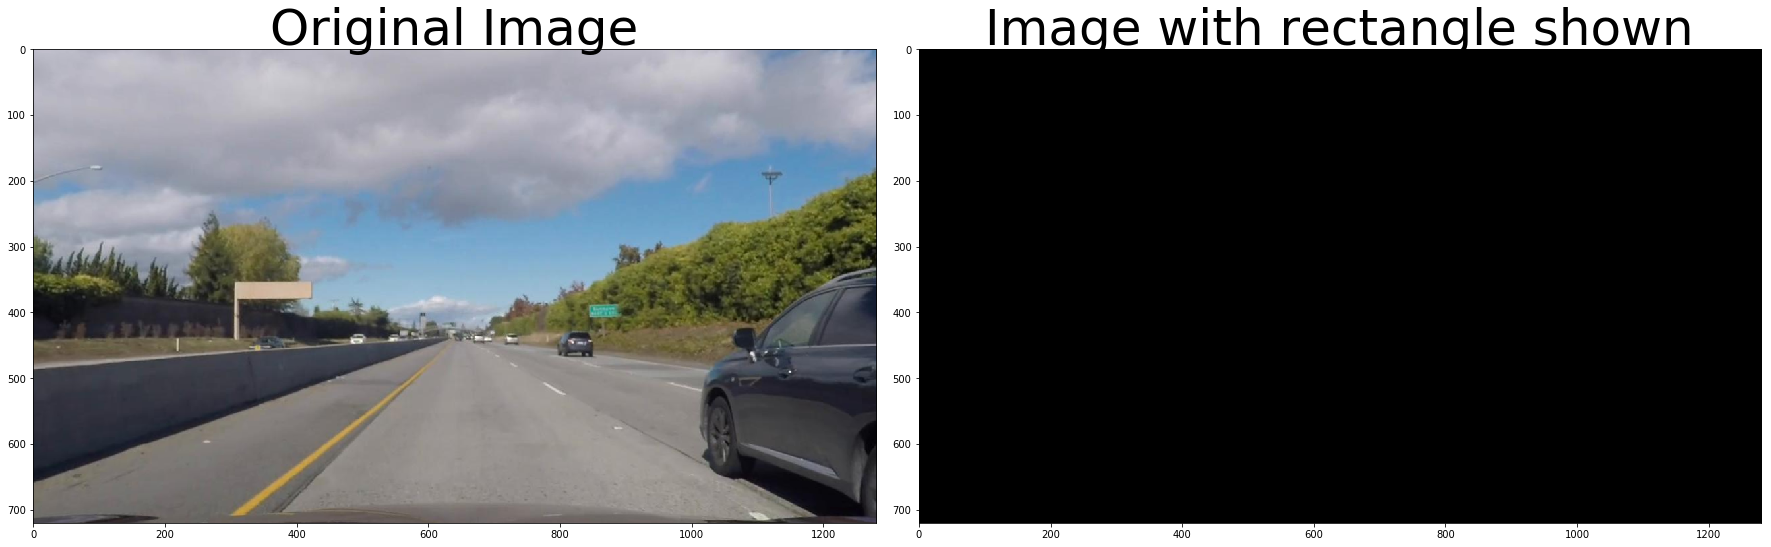

In [17]:
# plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(LeftLane.windowingImage, cv2.COLOR_GRAY2RGB))
ax2.set_title('Image with rectangle shown', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)